Code d'analyse de tracking. Il permet de récupérer les fichiers issus du tracking et d'en tirer les trajectoires pertinentes et d'en faire l'étude statistique. 

In [464]:
%reset

In [465]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  1 12:46:56 2023.

@author: souchaud
"""
# %%
import os
import time
import math
import pandas as pd
import numpy as np
from skimage import io
from PIL import Image
from scipy.stats import norm
from scipy import stats
from scipy.signal import find_peaks
from scipy.optimize import curve_fit, minimize_scalar
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import trackpy as tp
import functions_analyze as lib
import warnings
import importlib
from collections import defaultdict
from colorama import init, Fore, Style
from typing import List, Optional, Union, Any, Dict, Tuple
importlib.reload(lib)

init(autoreset=True)
# from matplotlib.cm import ScalarMappable
# import pdb; pdb.set_trace()
# warnings.simplefilter("always")  # This will always display warnings
# warnings.simplefilter('error', RuntimeWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

Initialisation des variables et constantes de travail.

In [466]:
# set initial time
INITIAL_TIME = time.time()

# experiment parameters
TIME_FRAME = 15  # 75
SIZE_PIX = 0.637# 1.2773  # 1.634  # 4.902
FPS = 1/TIME_FRAME

# File to study
file_name = 'features'  # 'filtered'Any
# number of frame kept
N_FRAME = 1
N_FRAME_MIN_STUDY = 200  # Nombre minimal de frame sur laquelle la cellule doit être suivie

# nber hours of stydy:
LONG_TIME = False

# Study parameters
ROLLING_MEAN = False
PIXELISATION = False
TIME_FRAME_STUDY = False
DRIFT = False

# plot parameters
IMG_TYPE = 'jpg'
ALPHA = 0.5
LINEWIDTH = 0.1
COLOR_SUP = 'blue'
COLOR_INF = 'red'
color_sup_inf = (COLOR_SUP, COLOR_INF)

# % de présences de la particules sur le total de frame étudiées

FRAME_PARTICULE = 1

# ##########
# % de présences des courbes dans les frames

FRAME_PARTICULE = 0.8

Définition des path et dossiers de travails / enregistrements.

In [467]:
# ##########################   GENERAL PATH   #################################
GENERAL_PATH = '/Users/souchaud/Desktop/Analyses/'
GENERAL_PATH_PICTURES = '/Users/souchaud/Desktop/A_analyser/'
# GENERAL_PATH_PICTURES = '/Volumes/Labo_Alex_Mac/A_analyser/'

In [468]:
############# CONDITION SIMPLE ################
# CONDITION_simple = 'CytoOne_SorC'
# CONDITION_simple = 'NonT_SorC'
CONDITION_simple = 'CytoOne_HL5_10x'
# CONDITION_simple = 'CytoOne_HL5'

############### CONDITION ################
CONDITION = f'{CONDITION_simple}_new_param' # _longtime_new_param'
# CONDITION = 'ASMOT035_fiji'
###########################################

In [469]:
# list of pathway to the experiments
PATHWAY_EXPERIMENT = []

if len(PATHWAY_EXPERIMENT) == 0:
    PATHWAY_EXPERIMENT = [f for f in os.listdir(GENERAL_PATH + CONDITION) if
                          os.path.isdir(os.path.join(GENERAL_PATH + CONDITION, f))]
# ##########################   Path Exp final  ###############################

PATHWAY_EXPERIMENT = [f'{GENERAL_PATH}{CONDITION}/' +
                      elem + '/mosaic/' for elem in PATHWAY_EXPERIMENT]

# ##########################   Path to Save pic  ##############################

path_save_pic = f'{GENERAL_PATH}résultats_{CONDITION}_ALL_OK_x5_15s/'

# création d'un dossier spécific d'enregistrement.
if not os.path.exists(path_save_pic):
    os.mkdir(path_save_pic)
os.chdir(path_save_pic)

Lecture des données expériementales

In [470]:
importlib.reload(lib)
DATA = lib.read_hdf5_all(pathway_experiment=PATHWAY_EXPERIMENT, name_file=file_name,
                         nbr_frame_min=N_FRAME_MIN_STUDY, condition=CONDITION, drift=DRIFT,
                         search_range=200, memory=30)

Frame 339: 109 trajectories present.
ASMOT110  :  104
Nombre de particules récoltées avant tri:  162


On décide de travailler que sur un certain nombre de frame. Ici je décide de travailler sur les 240 première frames. 
Donc la cellules doit être suivi sur N_MIN_STUDY sur les 240 premières frames. 

In [471]:
print("Nombre de particule avant tri: ", DATA['particle'].nunique())
DATA = DATA[DATA['frame'] < 240]

filter_data = DATA.groupby('particle').filter(lambda x: len(x) >= N_FRAME_MIN_STUDY)
print("Nombre de particule après le premier tri sur le temps suivi des cellules: ", filter_data['particle'].nunique())
DATA = filter_data

Nombre de particule avant tri:  162
Nombre de particule après le premier tri sur le temps suivi des cellules:  124


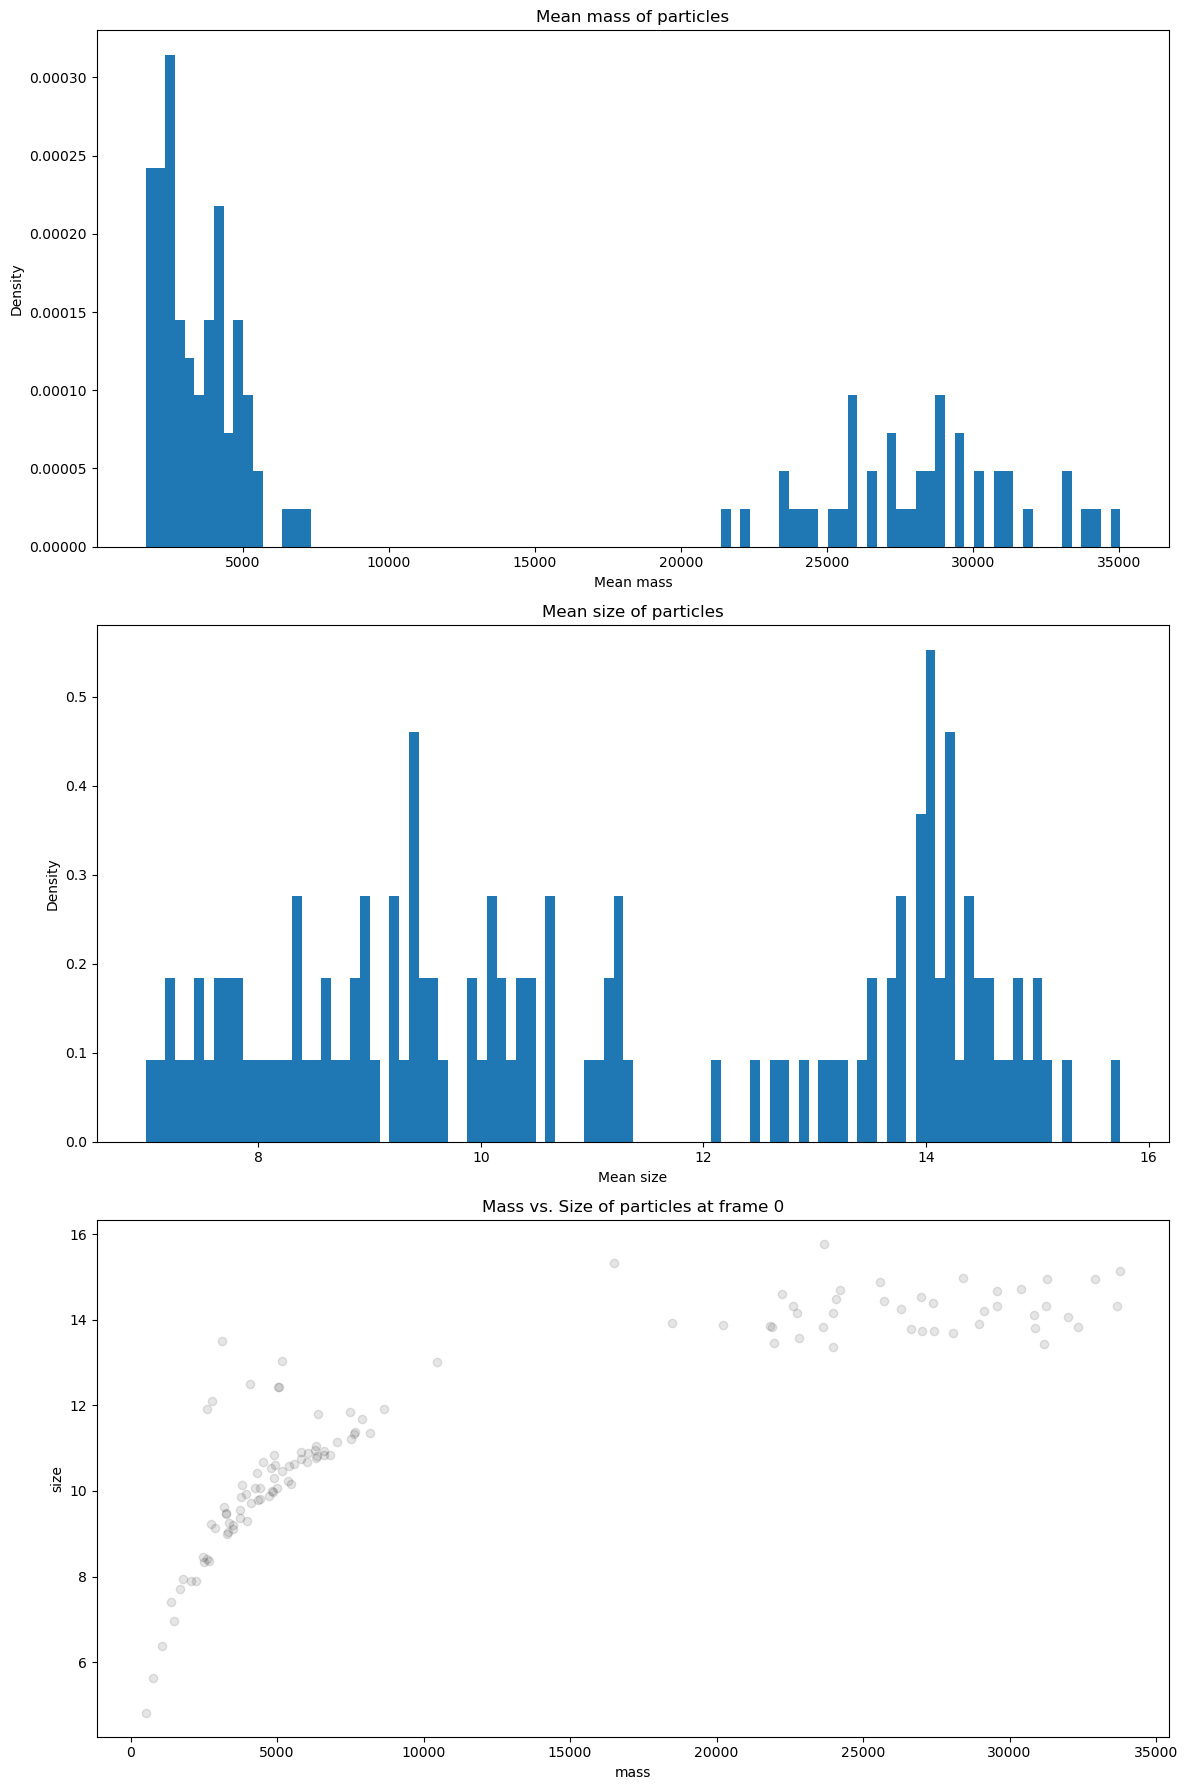

In [472]:
import matplotlib.pyplot as plt
import trackpy as tp

# Grouper par 'particle' et calculer la masse moyenne pour chaque groupe
mass_means = DATA.groupby('particle')['mass'].mean()

# Créer une figure avec 3 sous-graphiques
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

# Premier sous-graphique pour la masse moyenne
axes[0].hist(mass_means, bins=100, density=True)
axes[0].set_title("Mean mass of particles")
axes[0].set_xlabel("Mean mass")
axes[0].set_ylabel("Density")

# Deuxième sous-graphique pour la taille moyenne
size_means = DATA.groupby('particle')['size'].mean()
axes[1].hist(size_means, bins=100, density=True)
axes[1].set_title("Mean size of particles")
axes[1].set_xlabel("Mean size")
axes[1].set_ylabel("Density")

# Troisième sous-graphique pour mass_size
filtered_data = DATA[DATA['frame'] == 0]
tp.mass_size(filtered_data, ax=axes[2])
axes[2].set_title("Mass vs. Size of particles at frame 0")

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher la figure
plt.show()

# # Filtrer les particules avec une masse moyenne supérieure à 2000
# particles_with_high_mass = mass_means[mass_means > 5000].index

# # Utiliser ces particules pour filtrer le DataFrame original
# DATA = filter_data[filter_data['particle'].isin(particles_with_high_mass)]

# # Afficher le résultat
# print("Nombre de particule avant tri: ", DATA['particle'].nunique())

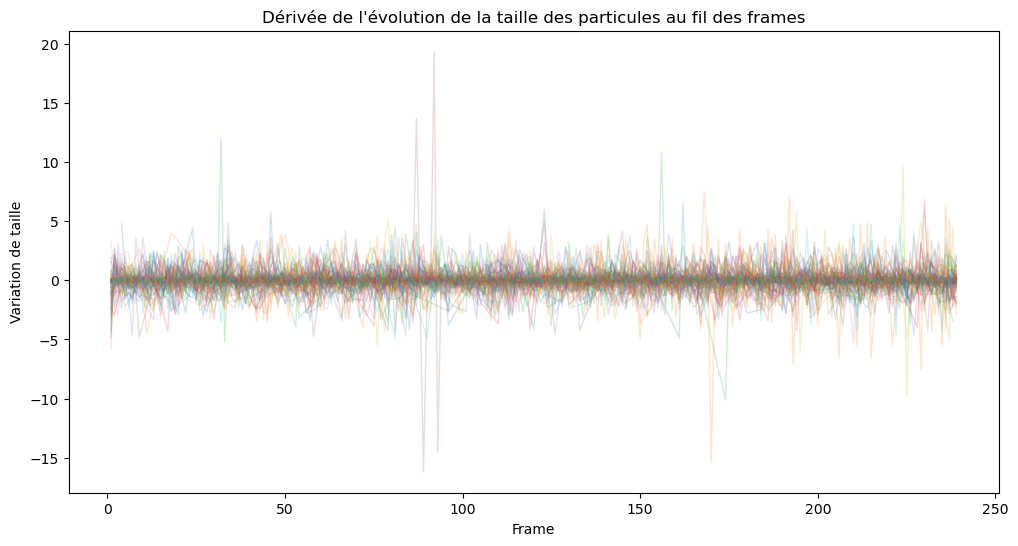

In [473]:
# Créer un graphique
plt.figure(figsize=(12, 6))

# Grouper les données par particule
grouped = DATA.groupby('particle')

# Tracer la dérivée de l'évolution de la taille pour chaque particule
for particle, group in grouped:
    # Calculer la différence de taille entre les frames consécutives
    size_diff = group['size'].diff()

    # Tracer la dérivée de la taille
    plt.plot(group['frame'], size_diff, linewidth=1, alpha=0.2, label=f'Particule {particle}')

# Ajouter des légendes et des titres
plt.xlabel('Frame')
plt.ylabel('Variation de taille')
plt.title('Dérivée de l\'évolution de la taille des particules au fil des frames')
# Commentez la ligne suivante si vous avez trop de légendes
# plt.legend()

# Afficher le graphique
plt.show()

/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_2299/1791106529.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path)


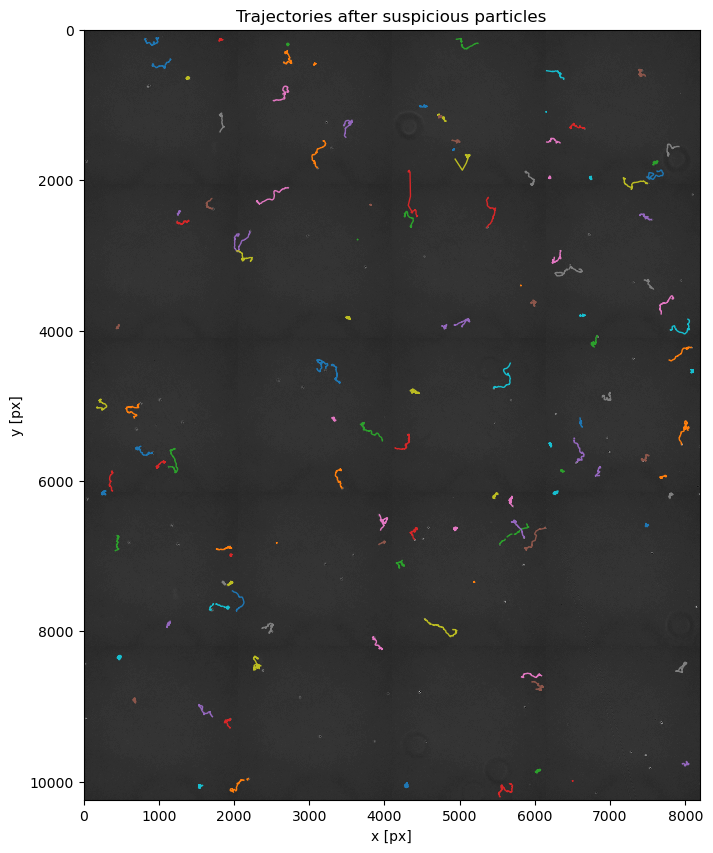

In [474]:
image_path = '/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x/2023_12_07_ASMOT110_AX3_P0_x10_15x_CytoOne_HL5/mosaic/mosaic_total_0.tif'
frame = imageio.imread(image_path)
# %% [Plot all the trajectories]
fig, axis = plt.subplots(figsize=(10, 10))
# Assurer une échelle égale pour les axes
axis.set_aspect('equal', 'box')
plt.title('Trajectories after suspicious particles')
tp.plot_traj(DATA, superimpose=frame, label=(False))
plt.show()

In [475]:
# # In[Filter on mass]
# if 'mass' in DATA.columns:
#     mask = DATA.groupby('particle')['mass'].transform('mean') >= 1000
#     DATA = DATA[mask]
# if 'level_0' in DATA.columns:
#     DATA = DATA.drop('level_0', axis=1)
# DATA.reset_index(inplace=True)
# # In[Compute some datas as instant displacement /speed / centering trajectories ...]


On trace le nombre de particules par frame en fonction du temps pour chaque manips. Ca permets de repérer des anomalies. 

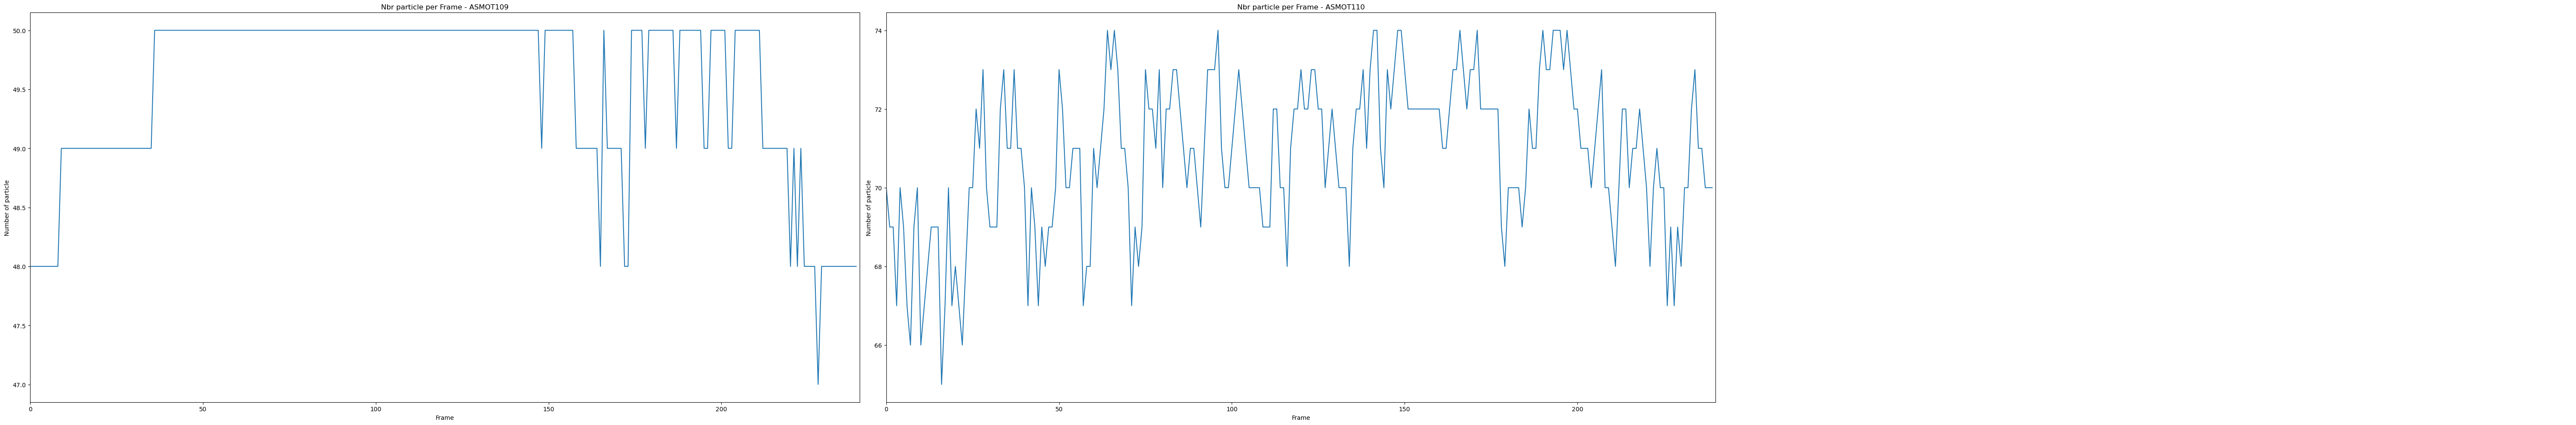

In [476]:
# Obtenir les expériences uniques pour les itérations
experiments = DATA['experiment'].unique()

# Déterminer le nombre de lignes et de colonnes pour les sous-graphiques
# Vous pouvez ajuster cela en fonction du nombre total d'expériences
n_cols = 3  # Nombre de colonnes, ajustez selon le besoin
n_rows = (len(experiments) + n_cols - 1) // n_cols  # Nombre de lignes

# Créer une figure et des axes pour les sous-graphiques
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20 * n_cols, 10 * n_rows))
axs = axs.flatten()  # Aplatir le tableau d'axes si nécessaire

# Tracer les graphiques pour chaque expérience
for i, exp in enumerate(experiments):
    # Grouper les données par 'frame' et calculer le nombre de particules par frame
    nbr_part_per_frame = DATA[DATA['experiment'] == exp].groupby('frame')['particle'].nunique()

    # Tracer le graphique sur le sous-graphique correspondant
    ax = axs[i]
    ax.plot(nbr_part_per_frame.index, nbr_part_per_frame.values)
    ax.set_title(f'Nbr particle per Frame - {exp}')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Number of particle')
    ax.set_xlim([0, 240])
    # ax.set_ylim([0, 2000])  # Ajustez selon vos données

# Masquer les axes non utilisés s'il y en a
for ax in axs[len(experiments):]:
    ax.axis('off')

# Ajustement de la mise en page
plt.tight_layout()
# Ajustement de l'espacement et des marges
# plt.subplots_adjust(hspace=0.4, wspace=0.4)
# Enregistrer la figure entière
plt.savefig(f"{path_save_pic}Nbr_particle_per_Frame_manip_par_manip.jpg", format='jpg')

# Afficher la figure
plt.show()


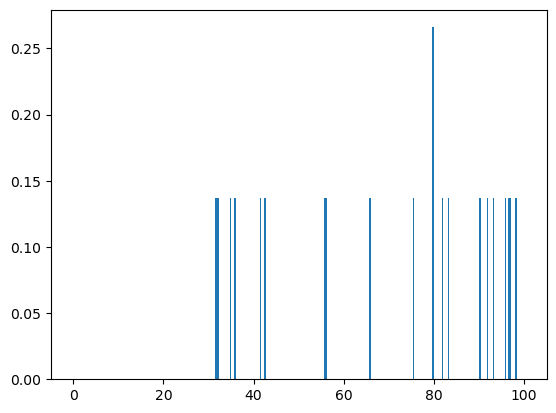

In [477]:
# Example usage
path_data = lib.calculate_total_path_first_frames(DATA, first_n_frames=100)
plt.hist(path_data['total_path_first_n'], bins=300, range=[0, 100], density=True)
plt.show()  # Ceci assure l'affichage du graphique sans retourner de valeur

Si besoin de crérer un gif de la manip, surtout sur une cellules bien aprticulière.

In [478]:
def create_cropped_tracking_gif(datas: pd.DataFrame, target_particle: int = None,
                                condition: str = None, manip: str = None,
                                crop_size: int = None, 
                                dot_size: int = 15, gif: bool = False,
                                pathway_saving: str = None,
                                pathway_initial: str = None):
    """
    Creates cropped images around a target particle and saves them as a GIF or individual images.
    """
    if not isinstance(datas, pd.DataFrame):
        raise ValueError("Data must be a pandas DataFrame.")

    if pathway_initial is None:
        pathway_initial = '/Users/souchaud/Desktop/A_analyser/'

    # if manip is not None:
    #     dossier_manip = glob.glob(f'{pathway_initial}{condition}/*{manip}*') 
    #     pathway_experiment = dossier_manip[0] + '/mosaic/'
    # else:
    #     dossier_manip = glob.glob(f'{pathway_initial}{condition}/*{}')
    #     pathway_experiment = dossier_manip[0] + f'/{}mosaic/'
    #     if not dossier_manip:
    #         print("No such file")
    #         return
    #     print(dossier_manip)
        

    if pathway_saving is None:
        path = '/users/souchaud/Desktop/Analyses/gif_particle_seule/'
        os.makedirs(path, exist_ok=True)
        pathway_saving = path + f'/{condition}_part_n{target_particle}/'

    os.makedirs(pathway_saving, exist_ok=True)

    for filename in os.listdir(pathway_saving):
        file_path = os.path.join(pathway_saving, filename)
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

    if target_particle is None and crop_size is None:
        if manip is None:
            print("Please, focus on a specific experiment.")
            return
        dossier_manip = glob.glob(f'{pathway_initial}{condition}/*{manip}*') 
        pathway_experiment = dossier_manip[0] + '/mosaic/'
        datas = datas[datas['experiment'] == manip]
        for frame_number in range(datas['frame'].min(), datas['frame'].max() + 1):
            image_path = os.path.join(pathway_experiment, f"mosaic_total_{frame_number}.tif")
            with Image.open(image_path) as img:
                img_width, img_height = img.size
                dpi = img.info.get('dpi', (196, 196))[0]  # Utiliser le DPI de l'image, sinon 96 par défaut
                figsize = (img_width / dpi, img_height / dpi)
                fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
                ax.imshow(img, cmap='gray')

                frame_data = datas[datas['frame'] == frame_number]
                for _, particle in frame_data.iterrows():
                    ax.plot(particle['x'], particle['y'], 'ro', markersize=dot_size, alpha=0.2)
                    # ax.plot(0, 0, 'bo', markersize=2000)
                ax.axis('off')

                output_path = os.path.join(pathway_saving, f"frame_{frame_number}.tif")
                plt.savefig(output_path, format="tif", dpi=dpi)
                plt.close(fig)

    elif target_particle is not None and crop_size is not None:
        particle_infos = datas[datas['particle'] == target_particle].iloc[0].to_dict()
        manip = particle_infos['experiment']
        dossier_manip = glob.glob(f'{pathway_initial}{condition}/*{manip}*')
        pathway_experiment = dossier_manip[0] + f'/mosaic/'
        if not dossier_manip:
            print("No such file")
            return
        print(dossier_manip)
        traj = datas[(datas['experiment'] == particle_infos['experiment']) & 
                     (datas['position'] == particle_infos['position']) & 
                     (datas['particle'] == target_particle)]

        frame_data_init = traj.iloc[0]
        x_0, y_0 = int(frame_data_init['x']), int(frame_data_init['y'])

        for frame_number in range(traj['frame'].min(), traj['frame'].max() + 1):
            frame_data = traj[traj['frame'] == frame_number]
            if frame_data.empty:
                continue

            image_path = os.path.join(pathway_experiment, f"mosaic_total_{frame_number}.tif")
            with Image.open(image_path) as img:
                x_max, y_max = img.size
                if crop_size is not None and crop_size > 0:
                    left, upper, right, lower = max(0, x_0 - crop_size // 2), max(0, y_0 - crop_size // 2), \
                                                 min(img.width, x_0 + crop_size // 2), min(img.height, y_0 + crop_size // 2)
                    cropped_img = img.crop((left, upper, right, lower))
                    rel_x, rel_y = x_0 - left, y_0 - upper
                else:
                    cropped_img = img
                    rel_x, rel_y = x_0, y_0

                fig, ax = plt.subplots()
                ax.imshow(cropped_img, cmap='gray')
                ax.plot(rel_x, rel_y, 'ro', markersize=dot_size)
                ax.axis('off')

                cropped_img_path = os.path.join(pathway_saving, f"cropped_{frame_number}.png")
                plt.savefig(cropped_img_path, bbox_inches='tight')
                plt.close(fig)

    if gif and target_particle is not None:
        with Image.open(os.path.join(pathway_saving, f"cropped_{traj['frame'].min()}.png")) as first_image:
            first_image.save(os.path.join(pathway_saving, f"tracking_particle_{target_particle}.gif"),
                             format='GIF',
                             append_images=[Image.open(os.path.join(pathway_saving, f"cropped_{frame}.png")) 
                                            for frame in range(traj['frame'].min()+1, traj['frame'].max() + 1)],
                             save_all=True,
                             duration=200,
                             loop=0)
        print(f"GIF saved at {pathway_saving}")

    return

In [479]:
# filtered_df_total_path = path_data[path_data['total_path_first_n']<18]
filtered_df_total_path = path_data
gif = False
if gif == True:
    importlib.reload(lib)
    for numero_particule in filtered_df_total_path['particle'].unique():
        print(numero_particule)
        print("Etude de la particule : ", numero_particule, ' dans la manip', DATA[DATA['particle']==numero_particule]['experiment'].iloc[0])
        lib.create_cropped_tracking_gif(datas=DATA, target_particle = None, # numero_particule,
                                        condition = CONDITION_simple,
                                        dot_size= 20,
                                        crop_size= None, #100, 
                                        gif=False,
                                        pathway_saving=None,
                                        pathway_initial= None)
                                        #'/Volumes/Labo_Alex_Mac/A_analyser/')

In [480]:

# create_cropped_tracking_gif(datas=DATA, target_particle=None,
#                             condition=CONDITION_simple,
#                             manip='ASMOT052',
#                             dot_size=2000,
#                             crop_size=None, 
#                             gif=False,
#                             pathway_saving=None,
#                             pathway_initial= '/users/souchaud/Desktop/A_analyser/')
# #'/Volumes/Labo_Alex_Mac/A_analyser/')

Calcul du nombre de cellules ayant un déplacement inférieur à une valeur.

In [481]:
# Nombre de cellules avec un déplacement total inférieur à 10 sur les 20 premières frames
num_cells_low_displacement = path_data[path_data['total_path_first_n'] < 18]['particle'].nunique()

print("Nombre de cellules dont le déplacement est trop faible : " , num_cells_low_displacement)

Nombre de cellules dont le déplacement est trop faible :  0


In [482]:
# let's select the datas we want to study. For long time, we want to keep
# experiment with at least 350 frames. This could be change easely.
# This is to keep particles that are followed at least a certain % of the frame. 
# Instead, if there is a basic experiment, the number of minimal frame is already fixed (previously)
if LONG_TIME:
    DATA = lib.select_data(DATA=DATA, nbr_frame_min=200)
    print('Nbr of particles after selecting datas function : ', DATA['particle'].nunique())

Détermination des "swaps" :

In [483]:
# # Get the indices of rows to drop
# to_drop = find_swaps_with_return(DATA)

# print(len(to_drop), " movements to delete there while the run is too much.")

# # # Drop the rows from DATA
# DATA = DATA.drop(to_drop)
DATA.reset_index(inplace=True)

In [484]:
# DATA = lib.vit_instant_new(traj=DATA, lag_time=TIME_FRAME, pix_size=SIZE_PIX, triage=1)

# # 1. Calculer la différence entre les valeurs consécutives de frame
# DATA['frame_diff'] = DATA['frame'].diff().fillna(0)

# # 2. Calculer la limite maximale pour displacement [pix]
# DATA['max_displacement'] = DATA['frame_diff'] * 5

# # 3. Créer un masque pour les lignes où displacement [pix] dépasse max_displacement
# mask = DATA['displacement [pix]'] > DATA['max_displacement']

# # 4. Supprimer les lignes identifiées par ce masque
# DATA = DATA[~mask]


# mask = DATA['displacement [pix]'] > float(6)
# DATA.drop(DATA[mask].index, inplace=True)
# DATA.dropna(inplace=True)

Calcul des vitesses instantanées et des trajectoires recentrées

In [485]:
DATA = lib.vit_instant_new(traj=DATA, lag_time=TIME_FRAME, pix_size=SIZE_PIX, triage=1)

# DATA = DATA[DATA['displacement [pix]'] < 5]
DATA = lib.center(traj=DATA)

print("\n"*2)
print(f"Le temps de lecture et de préparation des données pour la condition {CONDITION} est : ",
      (time.time() - INITIAL_TIME), 'min')
print("\n"*2)





Le temps de lecture et de préparation des données pour la condition CytoOne_HL5_10x_new_param est :  5.038877964019775 min





In [486]:
# %% [Compute the DATAS according to some parameters]
if ROLLING_MEAN:
    DATA = lib.rolling_mean(datas=DATA, roll=3)
if PIXELISATION:
    DATA = lib.pixelisation(datas=DATA, size_pix=SIZE_PIX)
if TIME_FRAME_STUDY:
    DATA, TIME_FRAME = lib.keep_nth_image(traj=DATA, n=N_FRAME, time_frame=TIME_FRAME)

In [487]:
# #############################################################################
# %% [Calculation of total and cumulative displacement]
# #############################################################################

DATA, start_end = lib.length_displacement(traj=DATA, size_pix=SIZE_PIX)


In [488]:
# # %% [Recalcul du max displacement]
# # ###################Erasing the suspicious displacements #####################
# grouped_data = DATA.groupby('particle')
# # Obtenir la valeur maximale de 'displacement' pour chaque groupe
# max_displacements = SIZE_PIX*grouped_data['displacement [pix]'].max()
# # Sélectionner les groupes dont la valeur maximale de 'displacement' est supérieure à 10
# selected_particles = max_displacements.loc[max_displacements > 50].index.tolist()
# bool_mask = DATA['particle'].isin(selected_particles)
# DATA_HIGH_DISP = DATA[bool_mask]
# if len(DATA_HIGH_DISP) > 0:
#     lib.plot_msd(msd=tp.imsd(traj=DATA_HIGH_DISP, mpp=SIZE_PIX, fps=FPS),
#                  fps=FPS, name='MSD with HIGHT DISP (sup at 10)', color_plot=COLOR_SUP,
#                  save=True, pathway_saving=path_save_pic, alpha=ALPHA, linewidth=LINEWIDTH)
# # Erasing the spurious traectories with too high displacement
# DATA = DATA[~bool_mask]

In [489]:
# %% [MSD computation]
IMSD = tp.imsd(traj=DATA[DATA['frame'] < 240],
               mpp=SIZE_PIX, fps=FPS,
               max_lagtime=200, statistic='msd',
               pos_columns=None)

In [490]:
# %% [Exclusion des particules de MSD constante]
print("\n"*2)
print("Nombre de particules étudiées avant tri sur MSD : ", DATA['particle'].nunique())

DATA, data_exclues, IMSD = lib.exclusion_on_msd(datas=DATA, imsd=IMSD,
                                                level=2)

DATA.reset_index(inplace=True, drop=True)
print("\n"*2)
print("Nombre de particules étudiées au final : ", DATA['particle'].nunique())




Nombre de particules étudiées avant tri sur MSD :  124



Nombre de particules étudiées au final :  124


# #############################################################################
# #############################################################################
# We now Consider having all the good particles and all good datas.
# #############################################################################
# #############################################################################

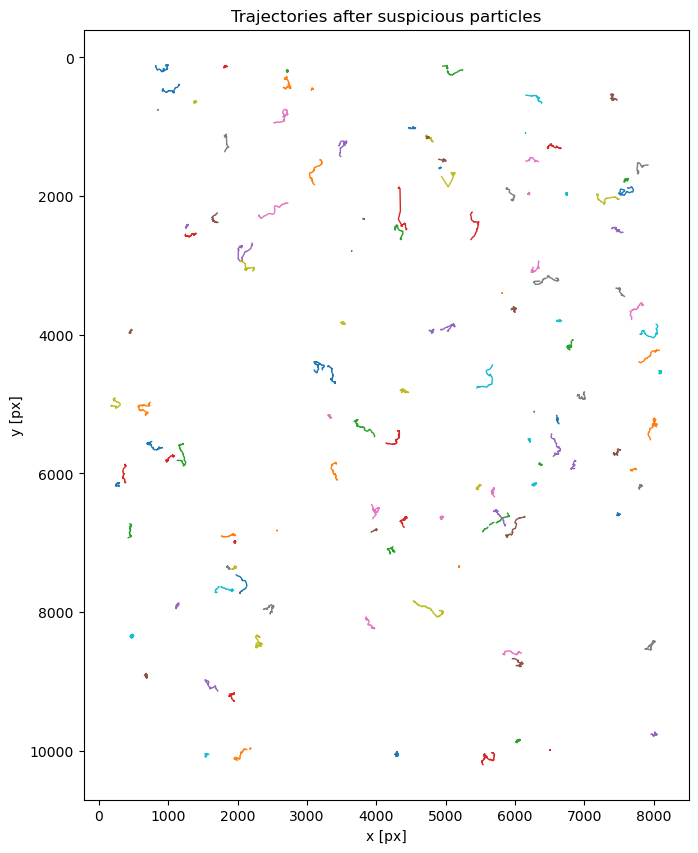

In [491]:
# %% [Plot all the trajectories]
fig, axis = plt.subplots(figsize=(10, 10))
# Assurer une échelle égale pour les axes
axis.set_aspect('equal', 'box')
plt.title('Trajectories after suspicious particles')
tp.plot_traj(DATA, label=(False))
plt.show()
fig.savefig(path_save_pic +
            'Trajectories after removing suspicious particles.jpg', format='jpg')

/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_2299/1453841345.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path)
/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_2299/1453841345.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path)


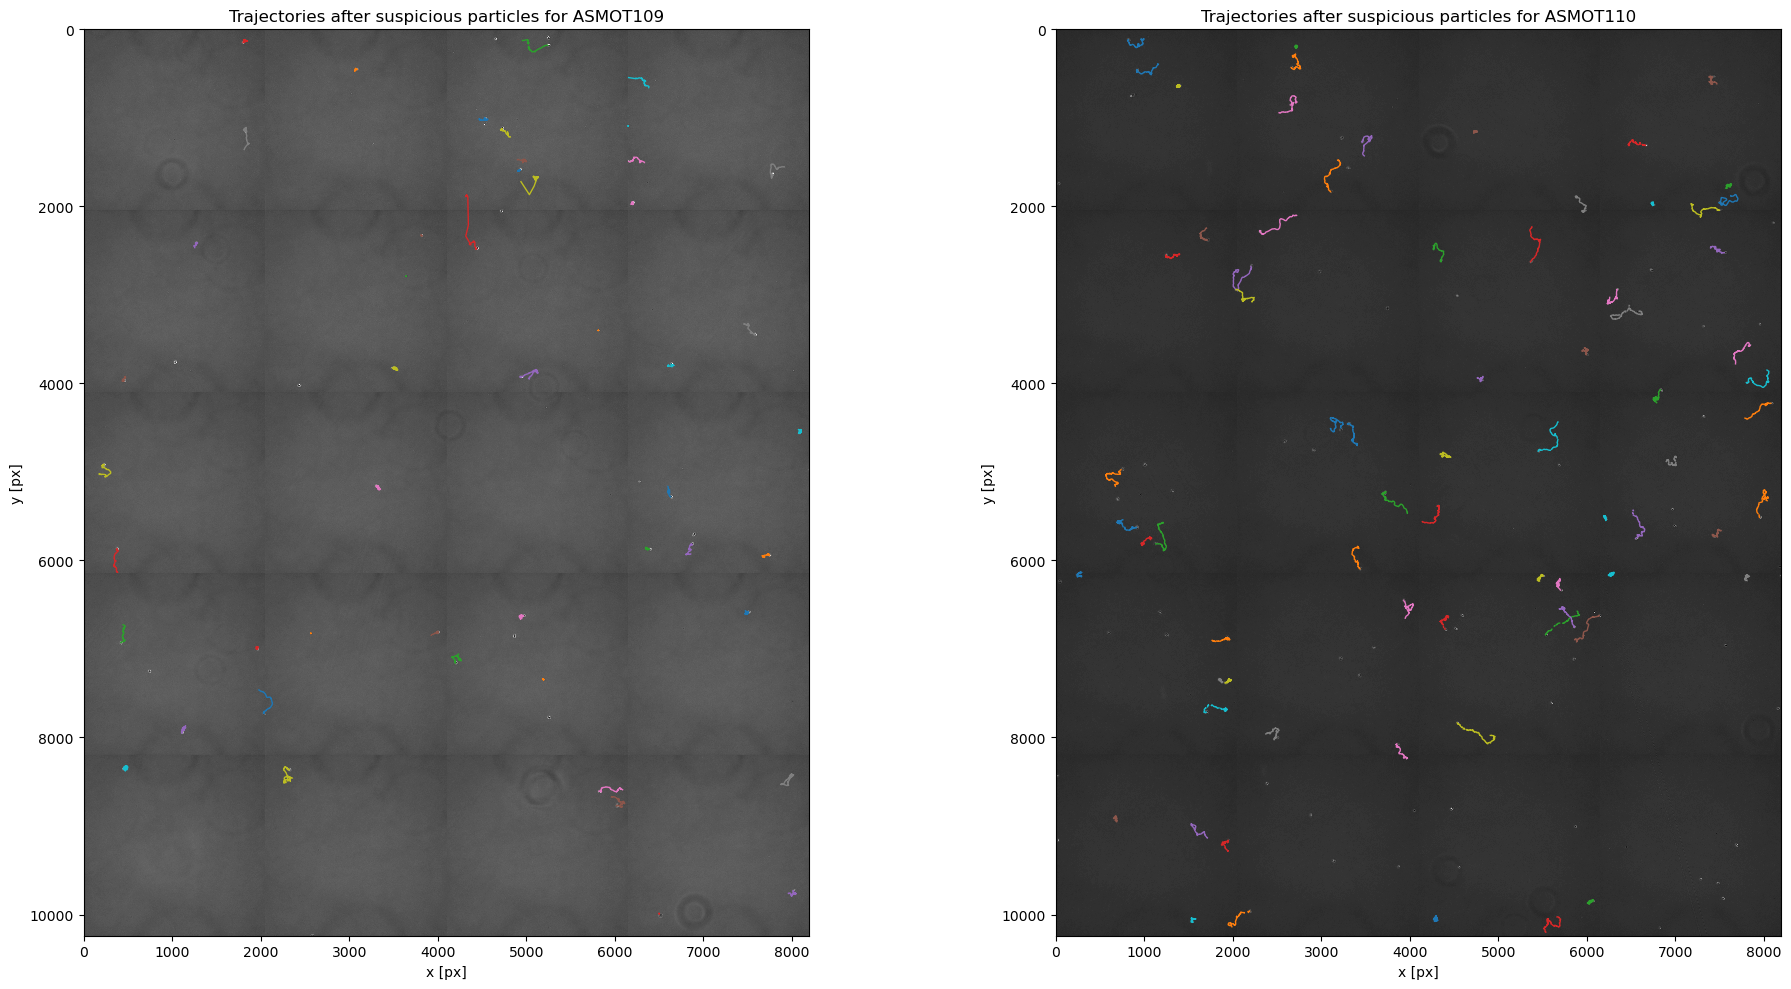

In [492]:
import trackpy as tp
import matplotlib.pyplot as plt

# Supposons que DATA est votre DataFrame
plot_exp = DATA.groupby('experiment')

# Déterminer le nombre de sous-graphiques basé sur le nombre d'expériences
num_experiments = len(plot_exp)
num_cols = 2  # Par exemple, vous pouvez définir 2 colonnes pour vos sous-graphiques
num_rows = (num_experiments + num_cols - 1) // num_cols  # Calculer le nombre de lignes nécessaire

# Créer la figure et les axes pour les sous-graphiques
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 10))  # Ajustez la taille selon vos besoins
axes = axes.flatten()  # Aplatir le tableau d'axes pour une itération facile

for ax, (exp_name, exp_data) in zip(axes, plot_exp):
    image_path = os.path.join(GENERAL_PATH_PICTURES, CONDITION_simple)
    exp_directories = []

    for dirpath, dirnames, filenames in os.walk(image_path):
        for dirname in dirnames:
            if exp_name in dirname:
                full_path = os.path.join(dirpath, dirname)
                exp_directories.append(full_path)

    if exp_directories:
        image_path = f'{exp_directories[0]}/mosaic/mosaic_total_0.tif'
        frame = imageio.imread(image_path)
        ax.set_aspect('equal', 'box')
        ax.set_title(f'Trajectories after suspicious particles for {exp_name}')
        tp.plot_traj(exp_data, superimpose=frame, label=False, ax=ax)
    else:
        print(f"No directory found for {exp_name}")
        ax.axis('off')
# Ajuster la mise en page pour éviter le chevauchement
plt.tight_layout()
plt.show()
fig.savefig(path_save_pic + 'trajectories_on_frame_all_experiment.pdf', format='pdf')


In [493]:

for ax, (exp_name, exp_data) in zip(axes, plot_exp):
    # Construire le chemin complet
    image_path = os.path.join(GENERAL_PATH_PICTURES, CONDITION_simple)
    print(image_path)

/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x
/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x


In [494]:
# plot_exp = DATA.groupby('experiment')
# for exp_name, exp_data in plot_exp:
#     fig, axis = plt.subplots(figsize=(10, 10))
#     # Assurer une échelle égale pour les axes
#     axis.set_aspect('equal', 'box')
#     plt.title(f'Trajectories after suspicious particles for {exp_name}')
#     tp.plot_traj(exp_data, label=(False))
#     plt.show()

# negative slope 0


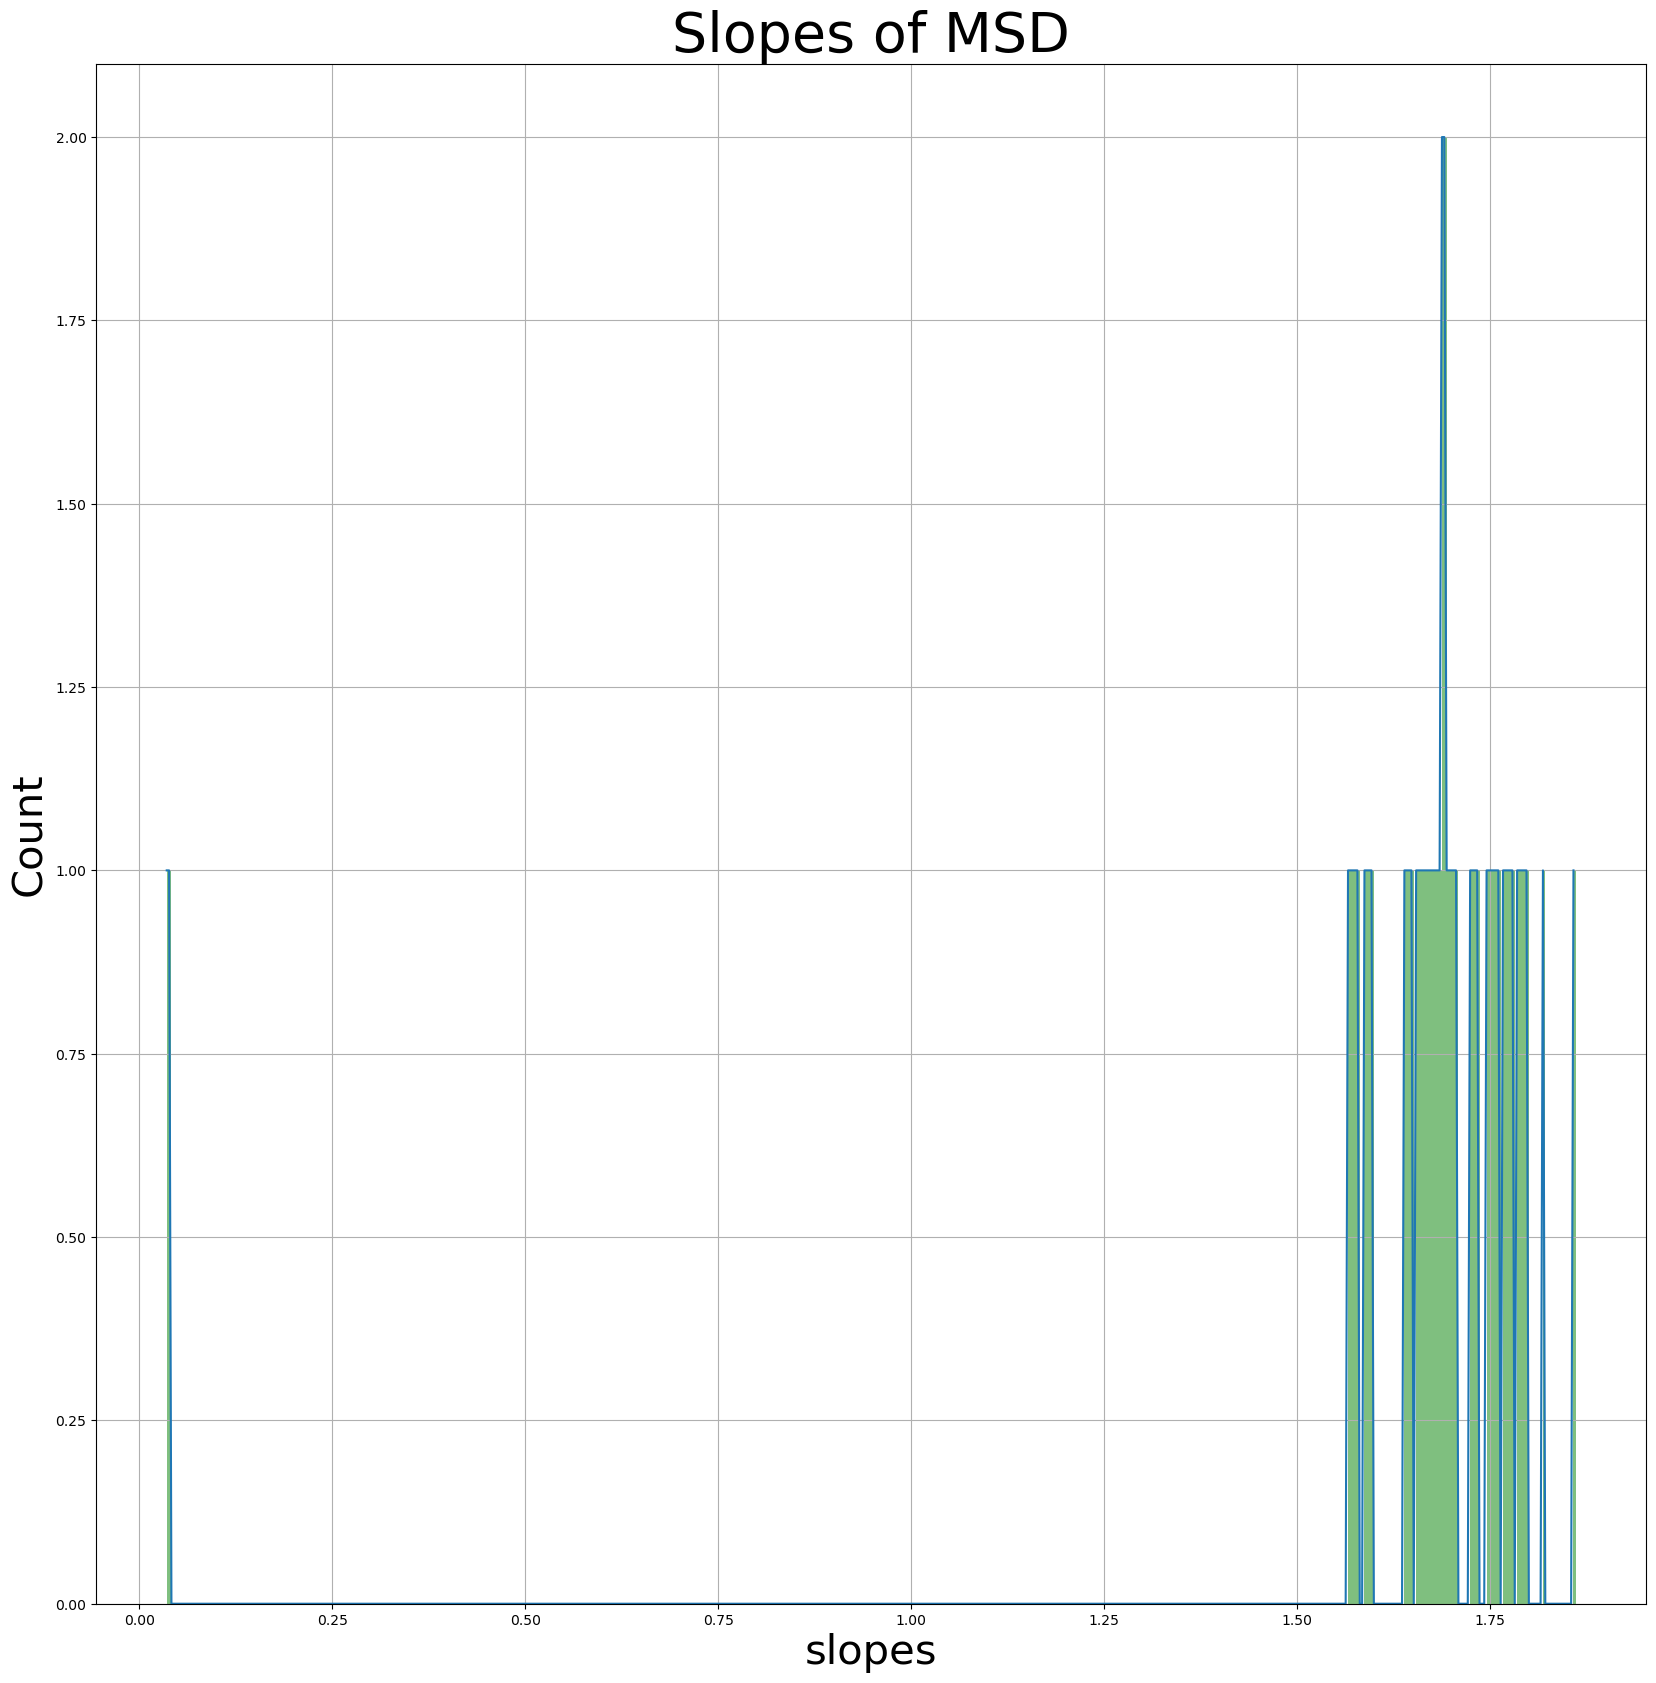

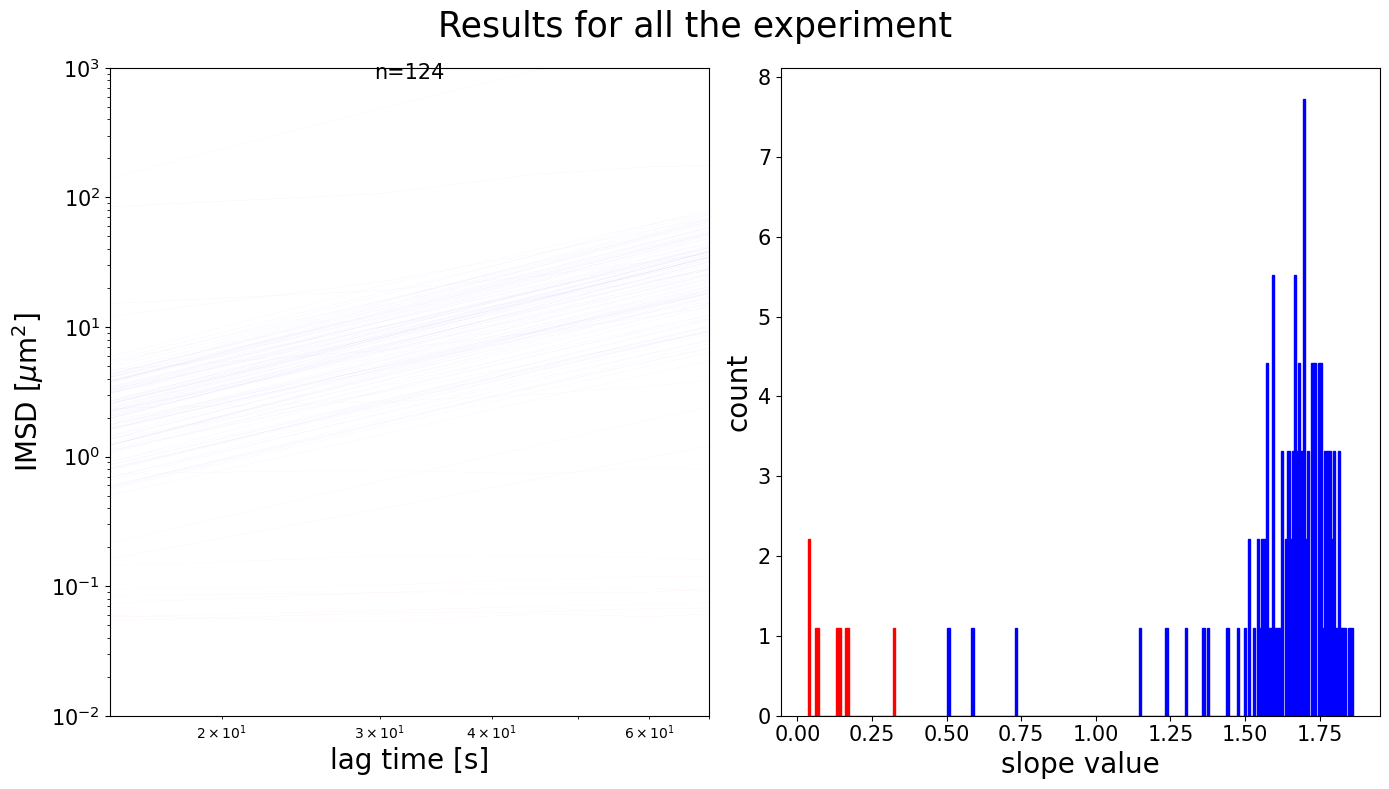

In [495]:
# %% [traj clustering with fit and defining a cutoff]
LAG_TIME_FIT = 5
# Compute et plot the director factor of the imsd

COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF =\
    lib.traj_clustering_with_fit_cutoff(DATA[DATA['frame'] < 240], imsd=IMSD, hist=True,
                                        lag_time_fit=LAG_TIME_FIT,
                                        micronperpixel=SIZE_PIX,
                                        fps=FPS, binsize=600,
                                        peak_height=50, peak_width=1,
                                        save=True, pathway_fig=path_save_pic,
                                        name='all the experiment', img_type="jpg",
                                        plot=True, color_sup_inf=color_sup_inf,
                                        cutoff_default=0.5
                                        )

# DATA_INF, DATA_SUP, IMSD_INF, IMSD_SUP,
DATA_INF = DATA[DATA['particle'].isin(PART_COEF_INF)]
DATA_SUP = DATA[DATA['particle'].isin(PART_COEF_SUP)]
IMSD_INF = IMSD.loc[:, IMSD.columns.isin(PART_COEF_INF)]
IMSD_SUP = IMSD.loc[:, IMSD.columns.isin(PART_COEF_SUP)]

In [496]:
series_y = DATA.groupby('experiment')['y'].max().div(2048).apply(math.ceil).astype(int)
series_x = DATA.groupby('experiment')['x'].max().div(2048).apply(math.ceil).astype(int)
# Multiplication élément par élément entre les deux séries
result = series_y * series_x

In [497]:
6871948*0.001/100

68.71948

In [498]:
for exp_name, group in DATA.groupby('experiment'):
    message = ""
    # On doit définir le nombre de cellules que l'on voudrait pas superficie
    # Pour cela calculons : 
    # On a des fenêtres de 2048x1,28um2 = 6871948um2.
    # On a également des cellules de 10*10 = 100um2. 
    # On veut qu'elles soient espacées, donc avec une packing fraction de 0.001.
    # donc finalement 6871948*0.001 = 6872um
    # soit : 6852/100 = 68 cellules. On arrondit à 50 en moyenne. 
    # On se laisse ainsi une marche de +/-33% pour évaluer si on est dans un e
    # zone critique de densité, ou  non. Sachant qu'une densité trop faible ne serait
    # problématique que si on a un problème de tracking.
    if int(result[exp_name]*50*(1 + 0.333)) < group['particle'].nunique():
        message = "TOO DENSE?"
        COLOR = Fore.RED
    elif int(result[exp_name]*50*(1 - 0.333)) > group['particle'].nunique():
        message = "ENOUGH?"
        COLOR = Fore.RED
    else:
        COLOR = Fore.GREEN
    output = "{}: {} +/- {} um/min: {} < {}{}{}{} < {} {} {} {}x{}".format(
        exp_name,
        round(group.groupby('particle')['VitInst [um/min]'].mean().mean(), 1),
        round(group.groupby('particle')['VitInst [um/min]'].mean().std(), 1),
        int(result[exp_name]*50*(1-0.333)),
        COLOR, Style.BRIGHT,
        group['particle'].nunique(),
        Style.RESET_ALL,
        int(result[exp_name]*50*(1+0.333)),
        message,
        "size:",
        series_x[exp_name],
        series_y[exp_name],
        )
    print(output)
    # On inclu que si le message apparait, alors on peut faire une action.
    # Si je mets message == "cococirco", c'est que on décide de ne pas agir ici
    # poue le moment, mais je garde le code en cas de besoin.
    if message == "soooo":
        # Supprimer toutes les données de l'expériment
        DATA = DATA[DATA['experiment'] != exp_name]

        print("\n"*2)
        print("Donc on a :", DATA['particle'].nunique(), "particle etudiees après tout ça mdrrr")
        # In[MSD computation re-computation]
        IMSD = tp.imsd(traj=DATA[DATA['frame'] < 240],
                       mpp=SIZE_PIX, fps=FPS,
                       max_lagtime=200, statistic='msd',
                       pos_columns=None)
        # In[traj clustering with fit and defining a cutoff]
        LAG_TIME_FIT = 5
        # Compute et plot the director factor of the imsd

        COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF =\
            lib.traj_clustering_with_fit_cutoff(DATA, imsd=IMSD, hist=True,
                                                lag_time_fit=LAG_TIME_FIT,
                                                micronperpixel=SIZE_PIX,
                                                fps=FPS, binsize=600,
                                                peak_height=15, peak_width=1,
                                                save=True, pathway_fig=path_save_pic,
                                                name='all the experiment', img_type="jpg",
                                                plot=True, color_sup_inf=color_sup_inf,
                                                cutoff_default=0.75
                                                )

        # DATA_INF, DATA_SUP, IMSD_INF, IMSD_SUP,
        DATA_INF = DATA[DATA['particle'].isin(PART_COEF_INF)]
        DATA_SUP = DATA[DATA['particle'].isin(PART_COEF_SUP)]
        IMSD_INF = IMSD.loc[:, IMSD.columns.isin(PART_COEF_INF)]
        IMSD_SUP = IMSD.loc[:, IMSD.columns.isin(PART_COEF_SUP)]

        print("\n"*2)
        if (len(DATA_SUP) != 0) & (len(DATA_INF) != 0):
            print("proportion de hight/low : ",
                  DATA_SUP['particle'].nunique()
                  / (DATA_INF['particle'].nunique() + DATA_SUP['particle'].nunique()))
            print("Cutoff : ", round(CUTOFF, 2))

            print("Mean speed for high slopes : ",
                  round(DATA_SUP.groupby('particle')['VitInst [um/min]'].mean().mean(), 2), " +/- ",
                  round(DATA_SUP.groupby('particle')['VitInst [um/min]'].mean().std(), 2))

            print("Mean speed for low slopes : ",
                  round(DATA_INF.groupby('particle')['VitInst [um/min]'].mean().mean(), 2), " +/- ",
                  round(DATA_INF.groupby('particle')['VitInst [um/min]'].mean().std(), 2))

        else:
            print("Only hight value particles")
        print("\n"*2)

ASMOT109: 3.7 +/- 1.9 um/min: 667 < 50 < 1333 ENOUGH? size: 4x5
ASMOT110: 5.5 +/- 1.5 um/min: 667 < 74 < 1333 ENOUGH? size: 4x5


In [499]:
path_save_pic

'/Users/souchaud/Desktop/Analyses/résultats_CytoOne_HL5_10x_new_param_ALL_OK_x5_15s/'

# negative slope 

0


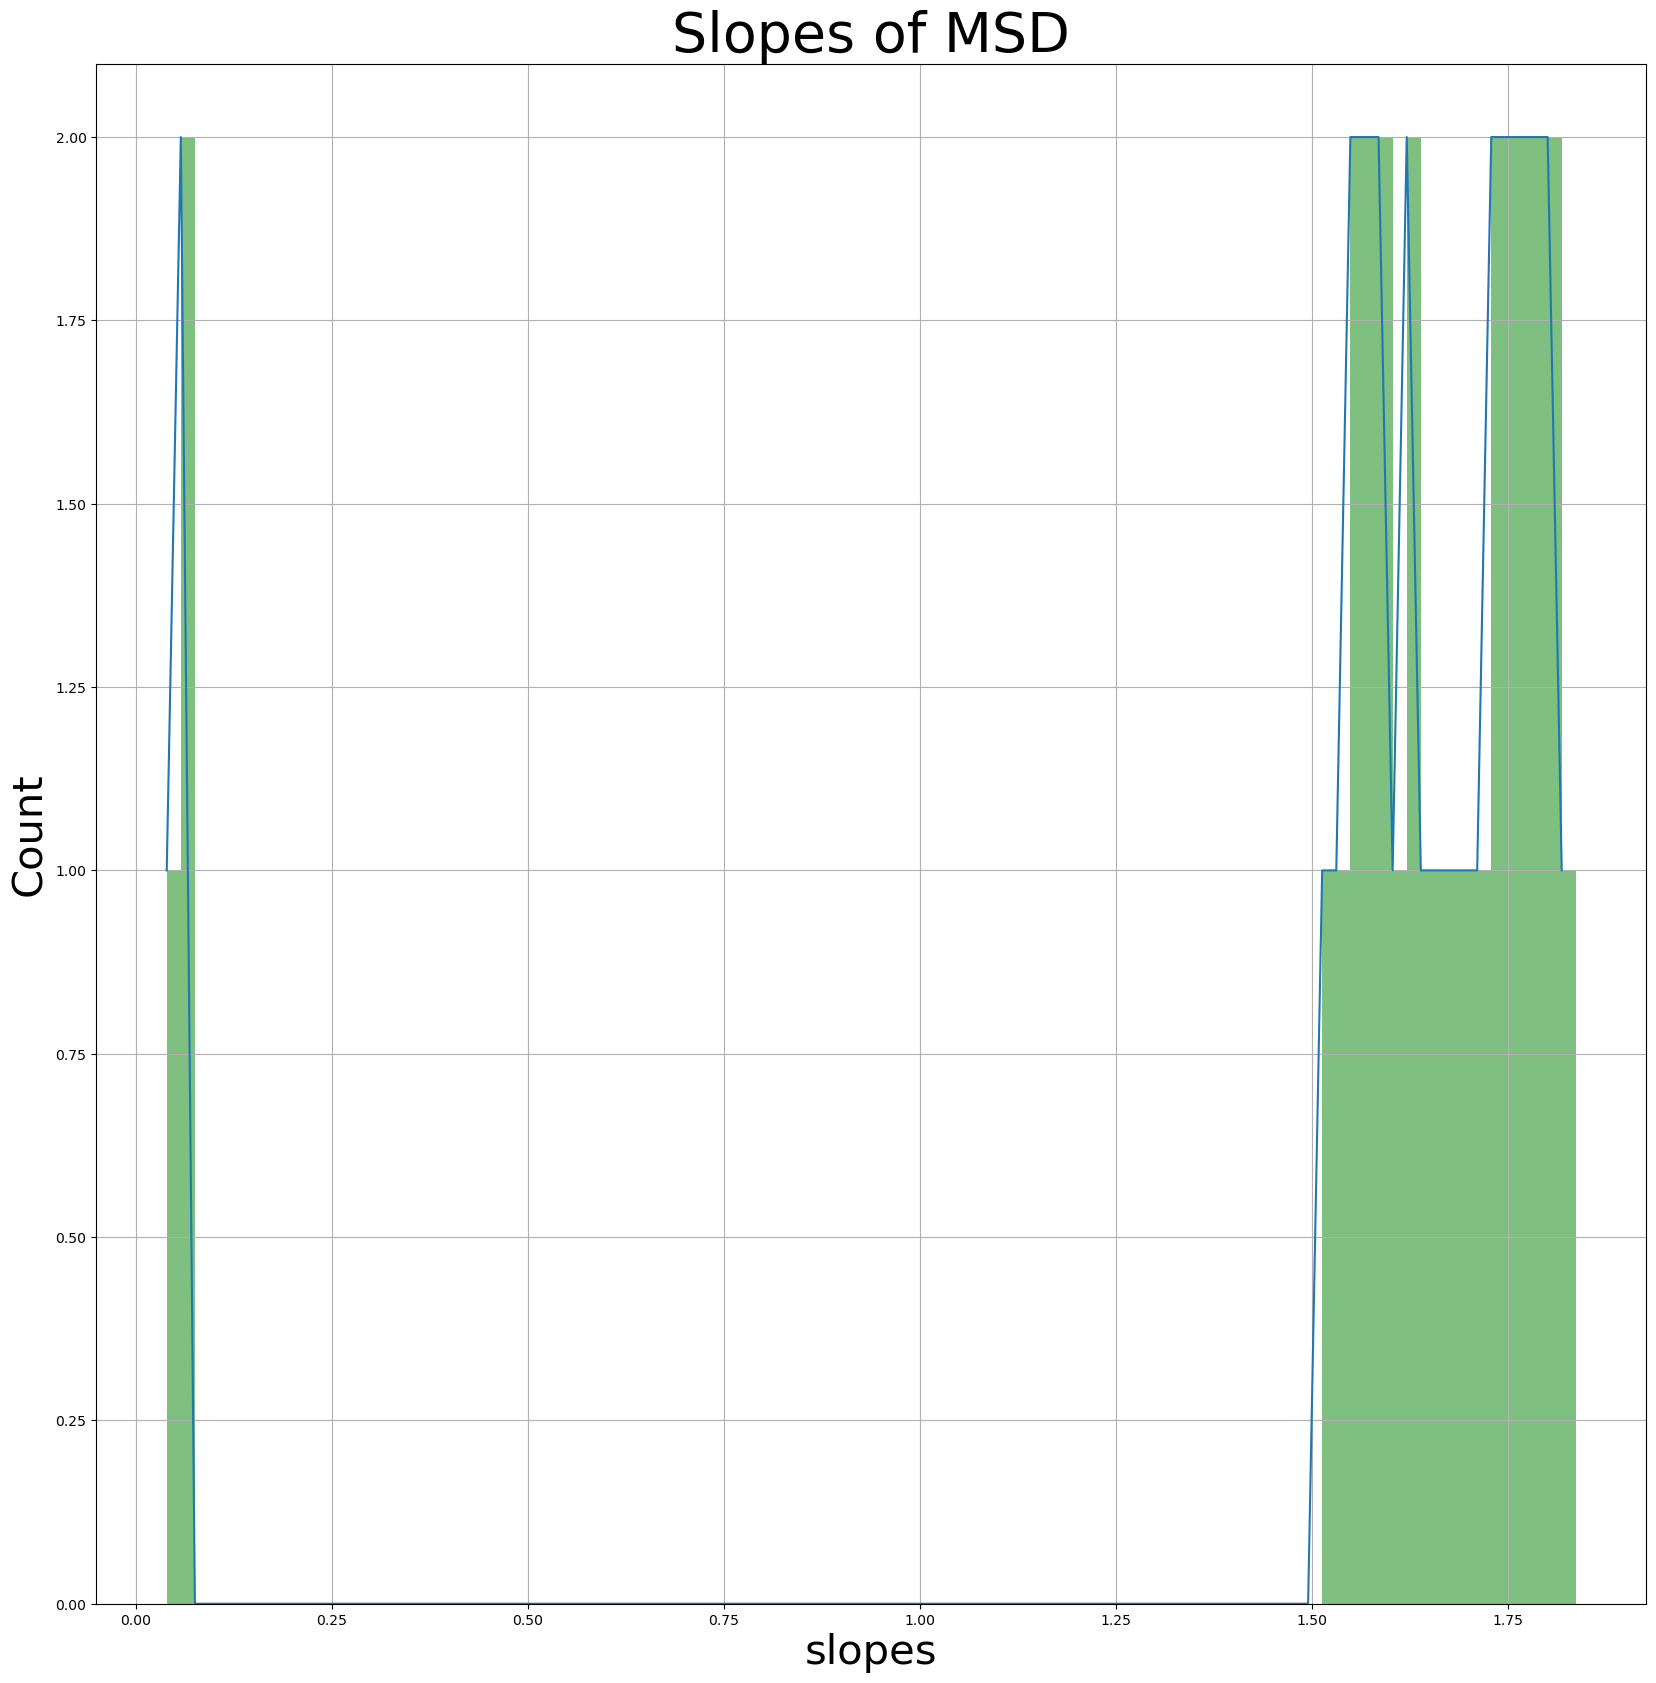

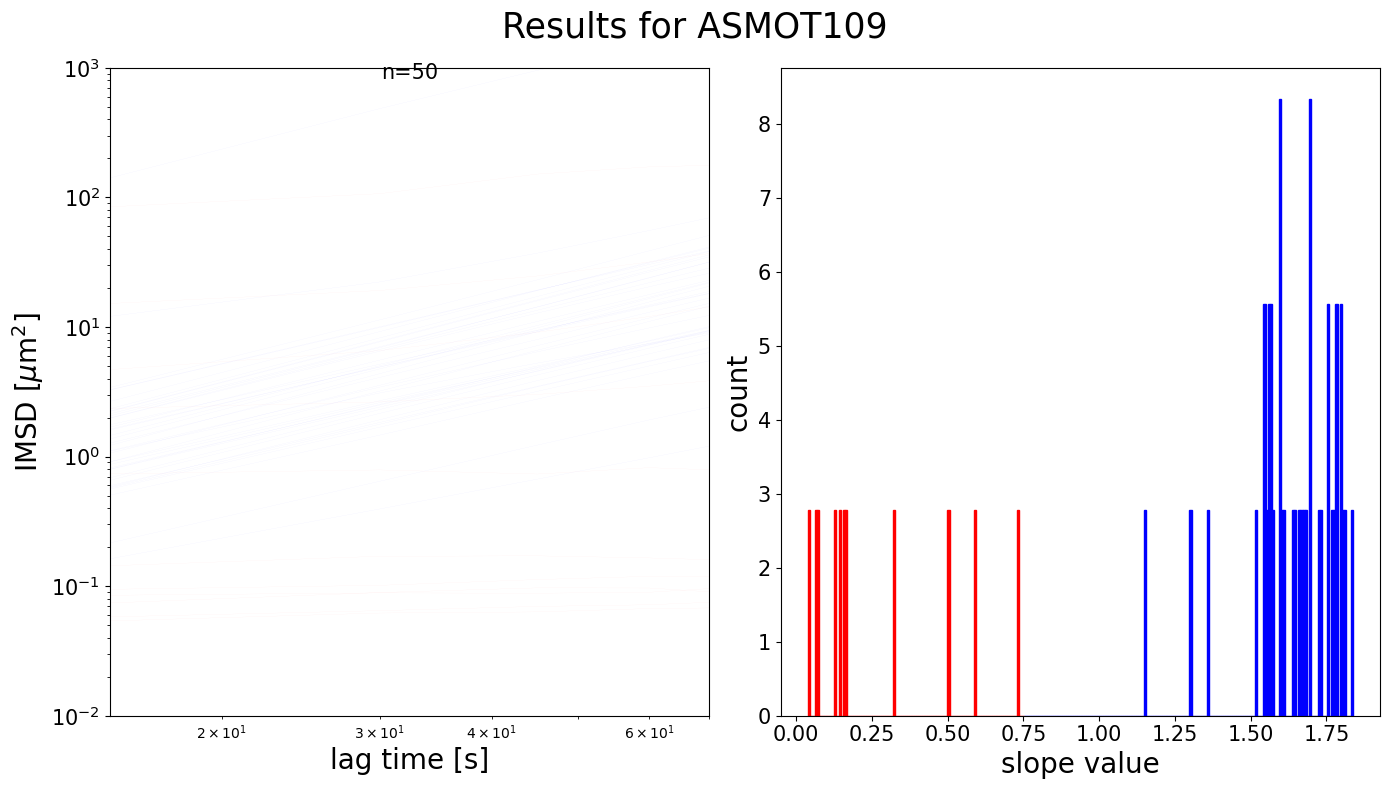

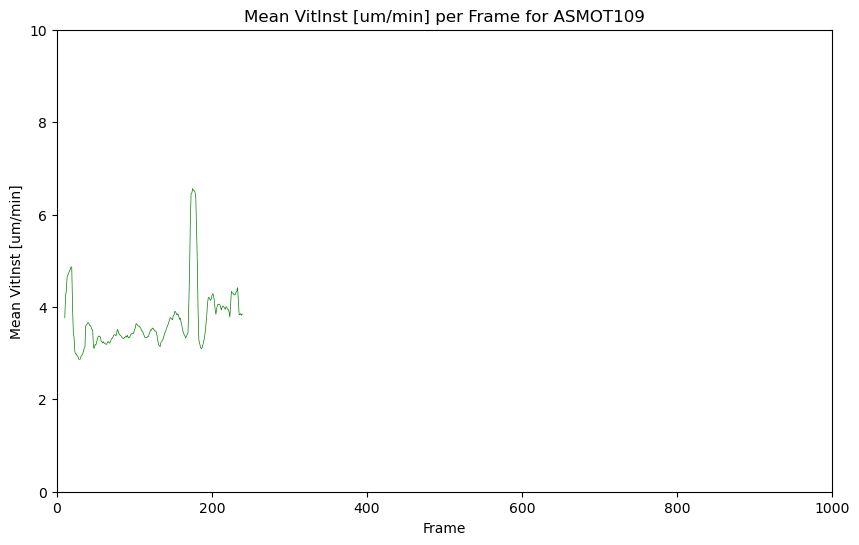

ASMOT109-> MeanSpeed: 3.7 +/- 9.3 um/min with 78.0% of hight particles
# negative slope 0


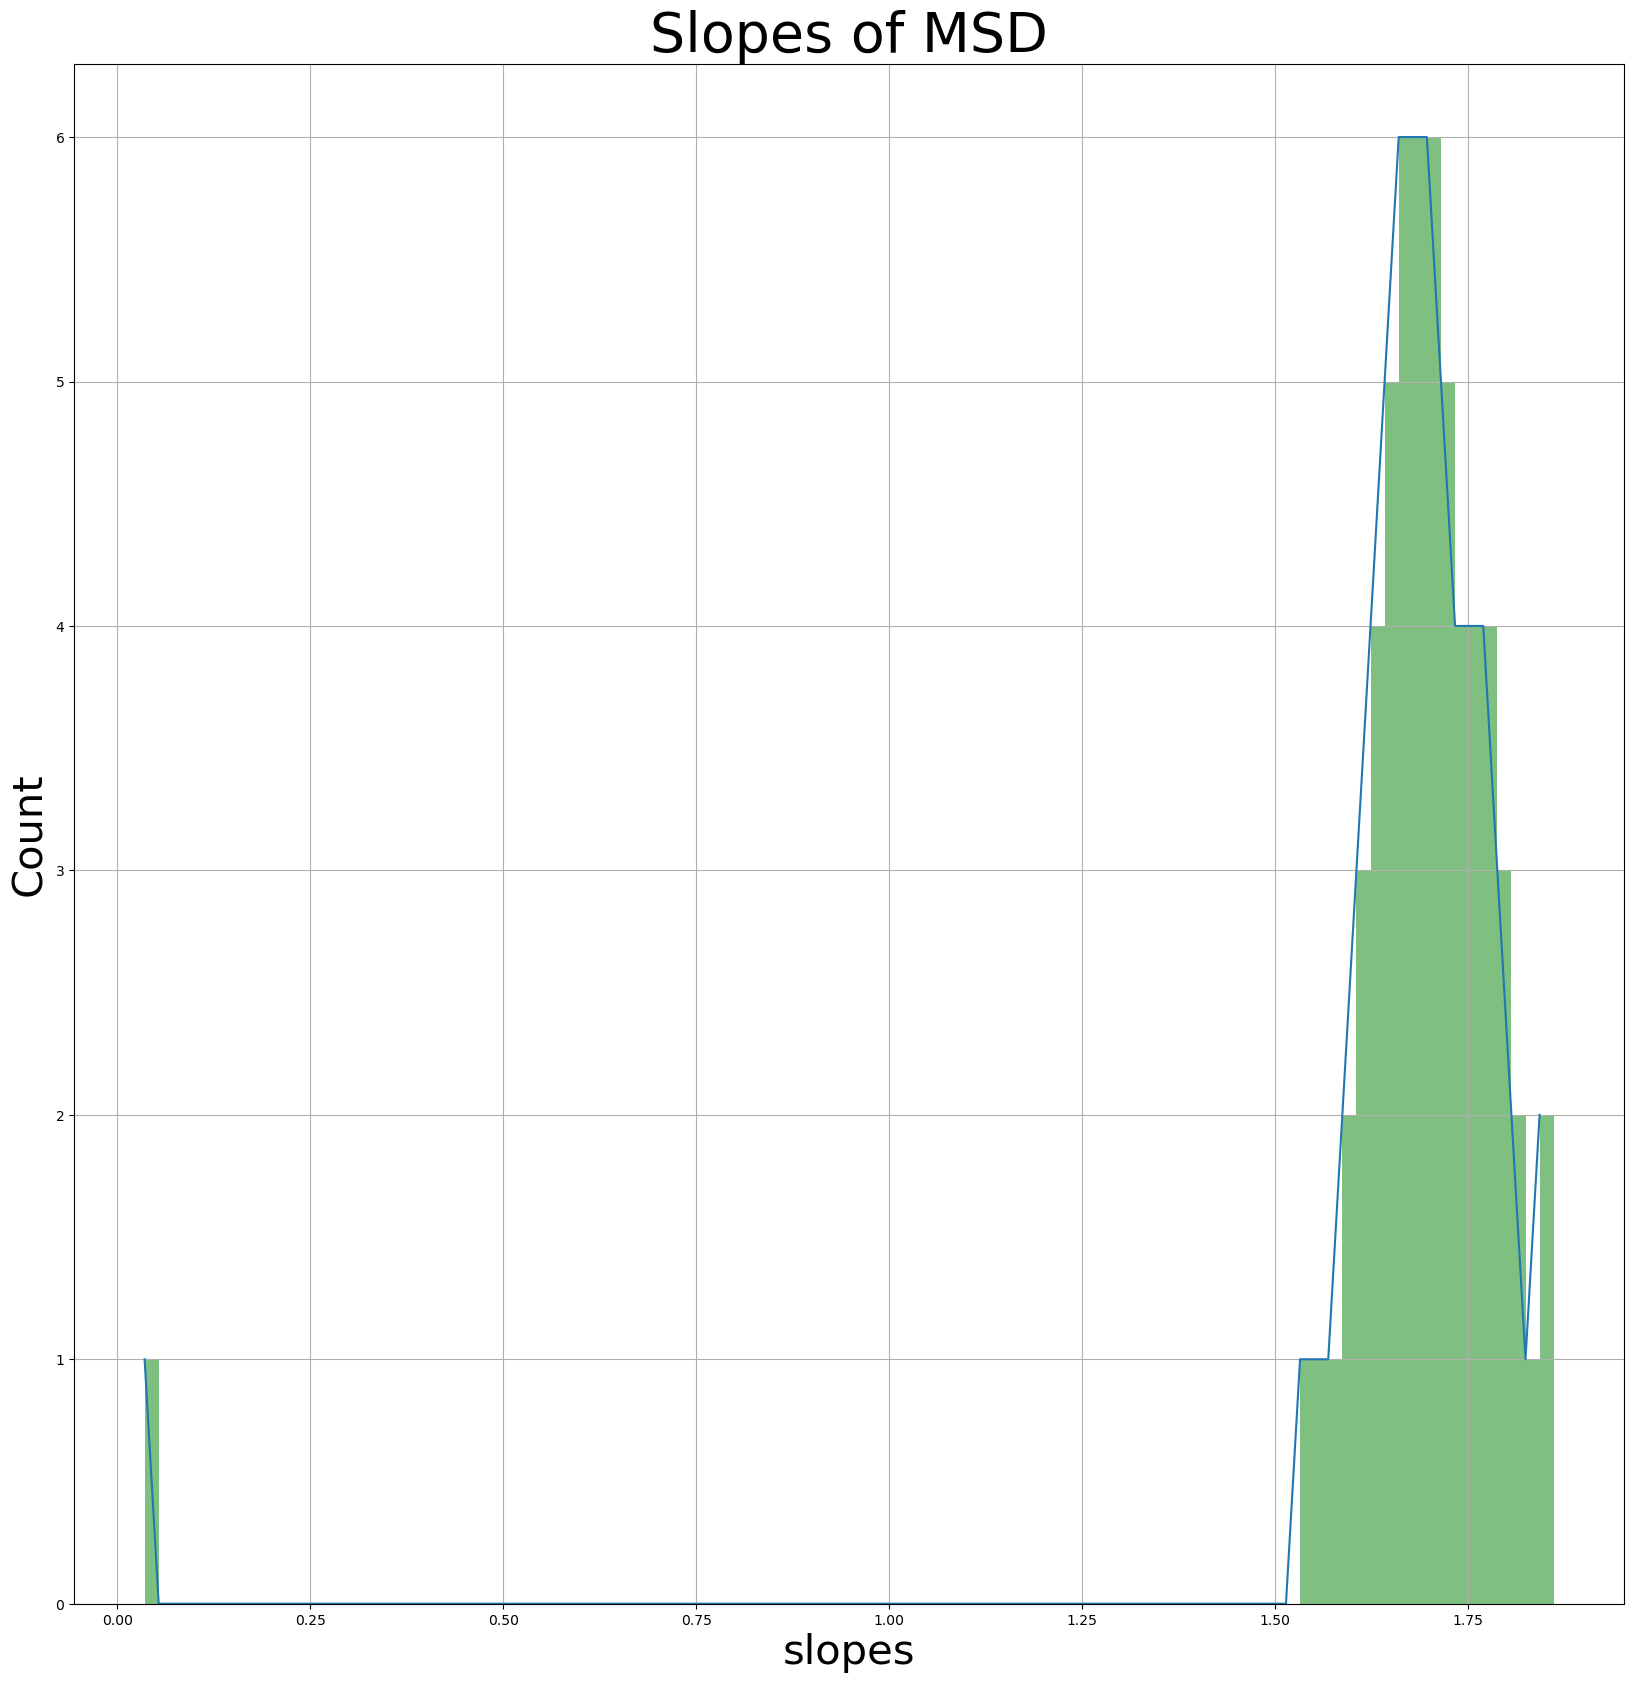

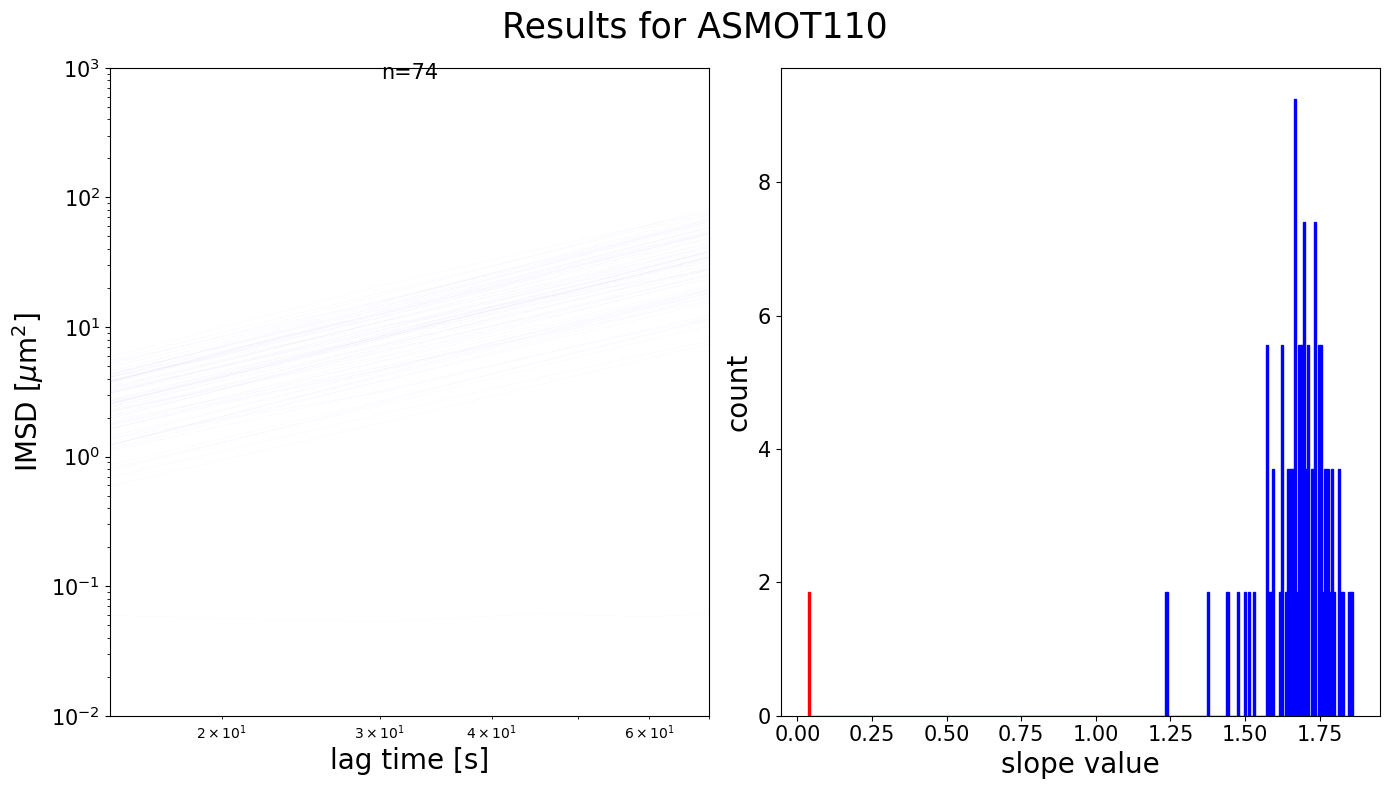

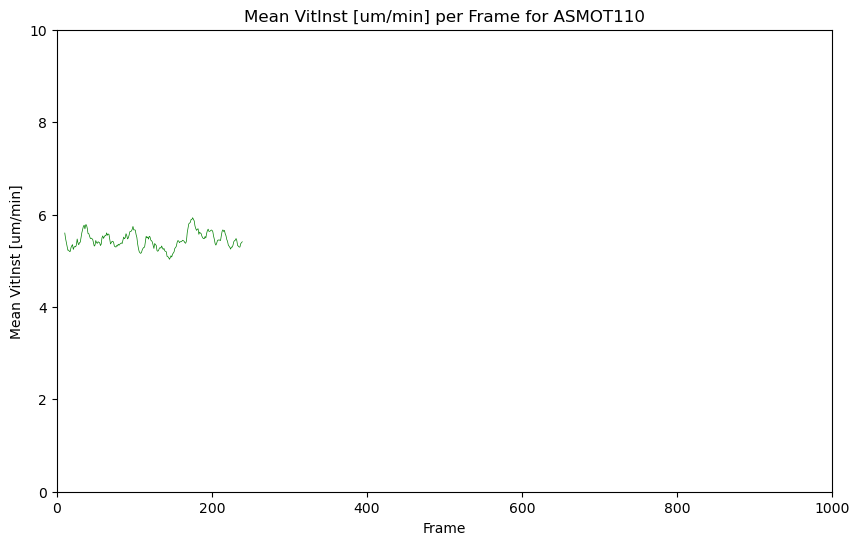

ASMOT110-> MeanSpeed: 5.5 +/- 3.7 um/min with 98.649% of hight particles


In [500]:
# In[clustering for each experiment to be sure]
# Ici on recalcule chaque IMSD et chaque clustering en coef sup et coef inf pour
# identifier d'éventuelles grosses erreurs. Cependant, cela pose un problème du
# clustering et des valeurs de fit.
path_save_fit_manip = path_save_pic + 'msd_fit_manip'
if not os.path.exists(path_save_fit_manip ):
    os.mkdir(path_save_fit_manip )
for exp_name, group in DATA.groupby('experiment'):

    IMSD_temp = tp.imsd(traj=group[group['frame'] < 240],
                        mpp=SIZE_PIX, fps=FPS,
                        max_lagtime=200, statistic='msd',
                        pos_columns=None)

    LAG_TIME_FIT = 5
    # Compute et plot the director factor of the imsd

    COEF_INF_temp, COEF_SUP_temp, PART_COEF_INF_temp, PART_COEF_SUP_temp, CUTOFF_temp =\
        lib.traj_clustering_with_fit_cutoff(group, imsd=IMSD_temp, hist=True,
                                            lag_time_fit=LAG_TIME_FIT,
                                            micronperpixel=SIZE_PIX,
                                            fps=FPS, binsize=100,
                                            peak_height=15, peak_width=1,
                                            save=True, pathway_fig=path_save_fit_manip,
                                            name=f'{exp_name}', img_type="jpg",
                                            plot=True, color_sup_inf=color_sup_inf,
                                            cutoff_default=0.75
                                            )

    # DATA_INF, DATA_SUP, IMSD_INF, IMSD_SUP,
    DATA_INF_temp = group[group['particle'].isin(PART_COEF_INF_temp)]
    DATA_SUP_temp = group[group['particle'].isin(PART_COEF_SUP_temp)]
    IMSD_INF_temp = IMSD_temp.loc[:, IMSD_temp.columns.isin(PART_COEF_INF_temp)]
    IMSD_SUP_temp = IMSD_temp.loc[:, IMSD_temp.columns.isin(PART_COEF_SUP_temp)]

    # Grouper les données par 'frame' et calculer la moyenne de 'VitInst [um/min]'
    mean_VitInst_per_frame_manip = group.groupby('frame')['VitInst [um/min]'].mean()
    mean_VitInst_per_frame_manip = mean_VitInst_per_frame_manip.rolling(10).mean().dropna()

    lib.plot_datas(x_values=mean_VitInst_per_frame_manip.index,
                   y_values=mean_VitInst_per_frame_manip.values,
                   title=f'Mean VitInst [um/min] per Frame for {exp_name}',
                   x_label='Frame', y_label='Mean VitInst [um/min]',
                   x_lim=[0, 1000], y_lim=[0, 10], save=True,
                   path_save_pic=path_save_fit_manip, img_type="jpg")

    proportion = 1
    if (len(DATA_SUP_temp) != 0) & (len(DATA_INF_temp) != 0):
        somme = (DATA_INF_temp['particle'].nunique() + DATA_SUP_temp['particle'].nunique())
        proportion = DATA_SUP_temp['particle'].nunique() / somme

    message = ""
    output = "{}-> MeanSpeed: {} +/- {} um/min with {}% of hight particles".format(
        exp_name,
        round(group['VitInst [um/min]'].mean(), 1),
        round(group['VitInst [um/min]'].std(), 1),
        round(proportion*100, 3)
        )
    print(output)

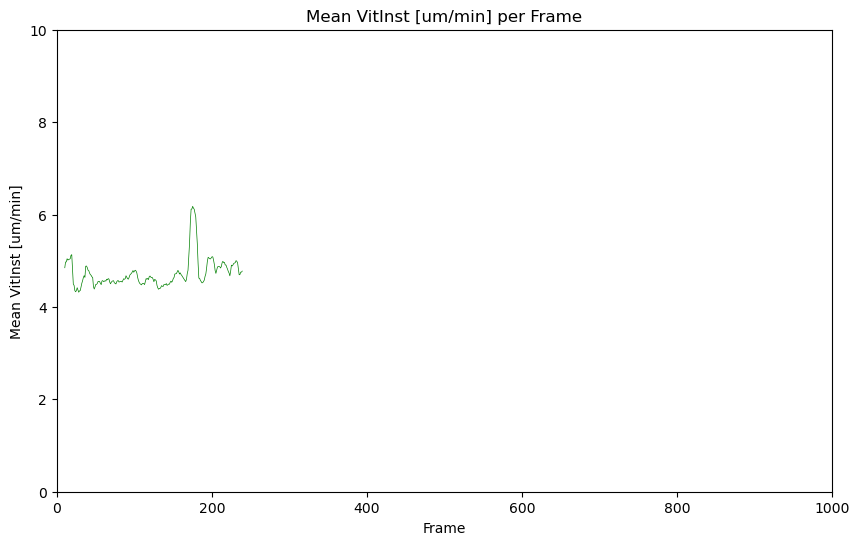

In [501]:
# %% [Mean speed]
# Grouper les données par 'frame' et calculer la moyenne de 'VitInst [um/min]'
mean_VitInst_per_frame = DATA.groupby('frame')['VitInst [um/min]'].mean()
mean_VitInst_per_frame = mean_VitInst_per_frame.rolling(10).mean().dropna()

lib.plot_datas(x_values=mean_VitInst_per_frame.index,
               y_values=mean_VitInst_per_frame.values,
               title='Mean VitInst [um/min] per Frame',
               x_label='Frame', y_label='Mean VitInst [um/min]',
               x_lim=[0, 1000], y_lim=[0, 10], save=True,
               path_save_pic=path_save_pic, img_type="jpg")


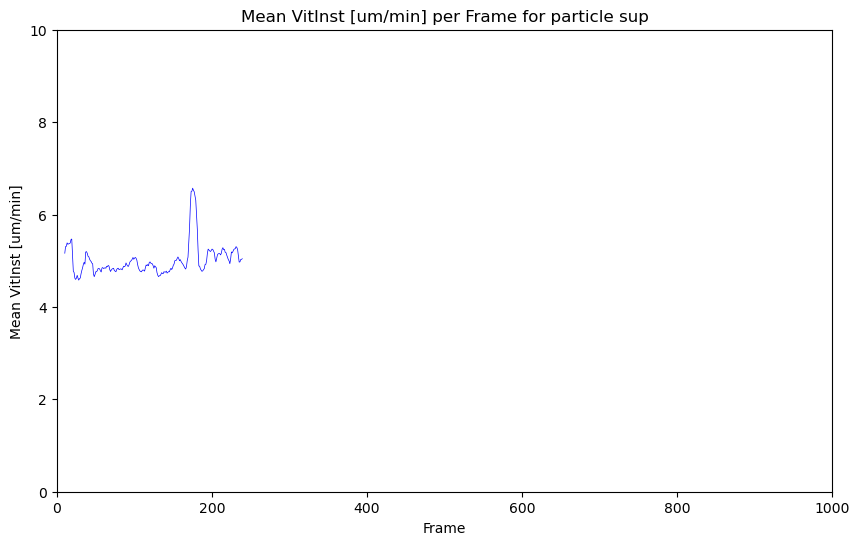

In [502]:

# Mean speed for hight particles
# Grouper les données par 'frame' et calculer la moyenne de 'VitInst [um/min]'
mean_VitInst_per_frame_SUP = DATA_SUP.groupby('frame')['VitInst [um/min]'].mean()
mean_VitInst_per_frame_SUP = mean_VitInst_per_frame_SUP.rolling(10).mean().dropna()

lib.plot_datas(x_values=mean_VitInst_per_frame_SUP.index,
               y_values=mean_VitInst_per_frame_SUP.values,
               title='Mean VitInst [um/min] per Frame for particle sup',
               x_label='Frame', y_label='Mean VitInst [um/min]',
               x_lim=[0, 1000], y_lim=[0, 10], save=True,
               parameters_plot={'color': COLOR_SUP,
                                'linewidth': 0.5,
                                'linestyle': 'solid',
                                },
               path_save_pic=path_save_pic, img_type="jpg")


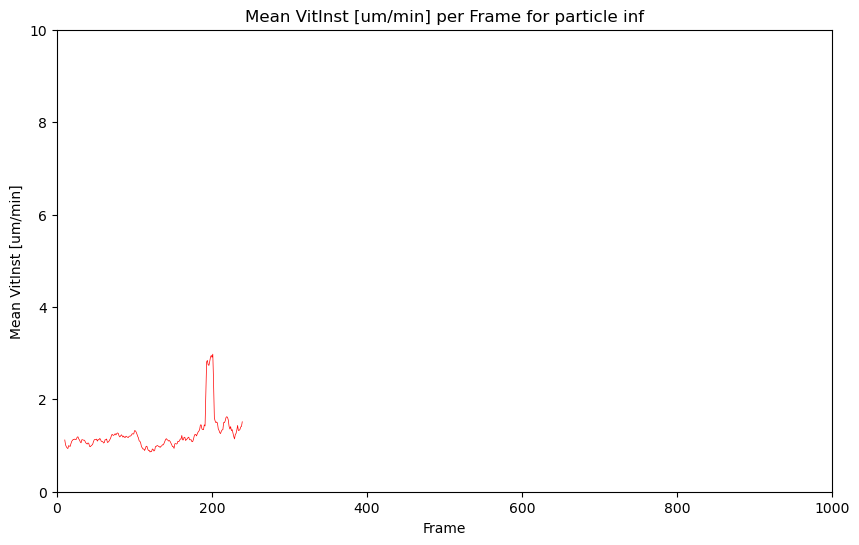

In [503]:

# Mean speed for hight particles
# Grouper les données par 'frame' et calculer la moyenne de 'VitInst [um/min]'
mean_VitInst_per_frame_INF = DATA_INF.groupby('frame')['VitInst [um/min]'].mean()
mean_VitInst_per_frame_INF = mean_VitInst_per_frame_INF.rolling(10).mean().dropna()
lib.plot_datas(x_values=mean_VitInst_per_frame_INF.index,
               y_values=mean_VitInst_per_frame_INF.values,
               title='Mean VitInst [um/min] per Frame for particle inf',
               x_label='Frame', y_label='Mean VitInst [um/min]',
               x_lim=[0, 1000], y_lim=[0, 10], save=True,
               parameters_plot={'color': COLOR_INF,
                                'linewidth': 0.5,
                                'linestyle': 'solid',
                                },
               path_save_pic=path_save_pic, img_type="jpg")


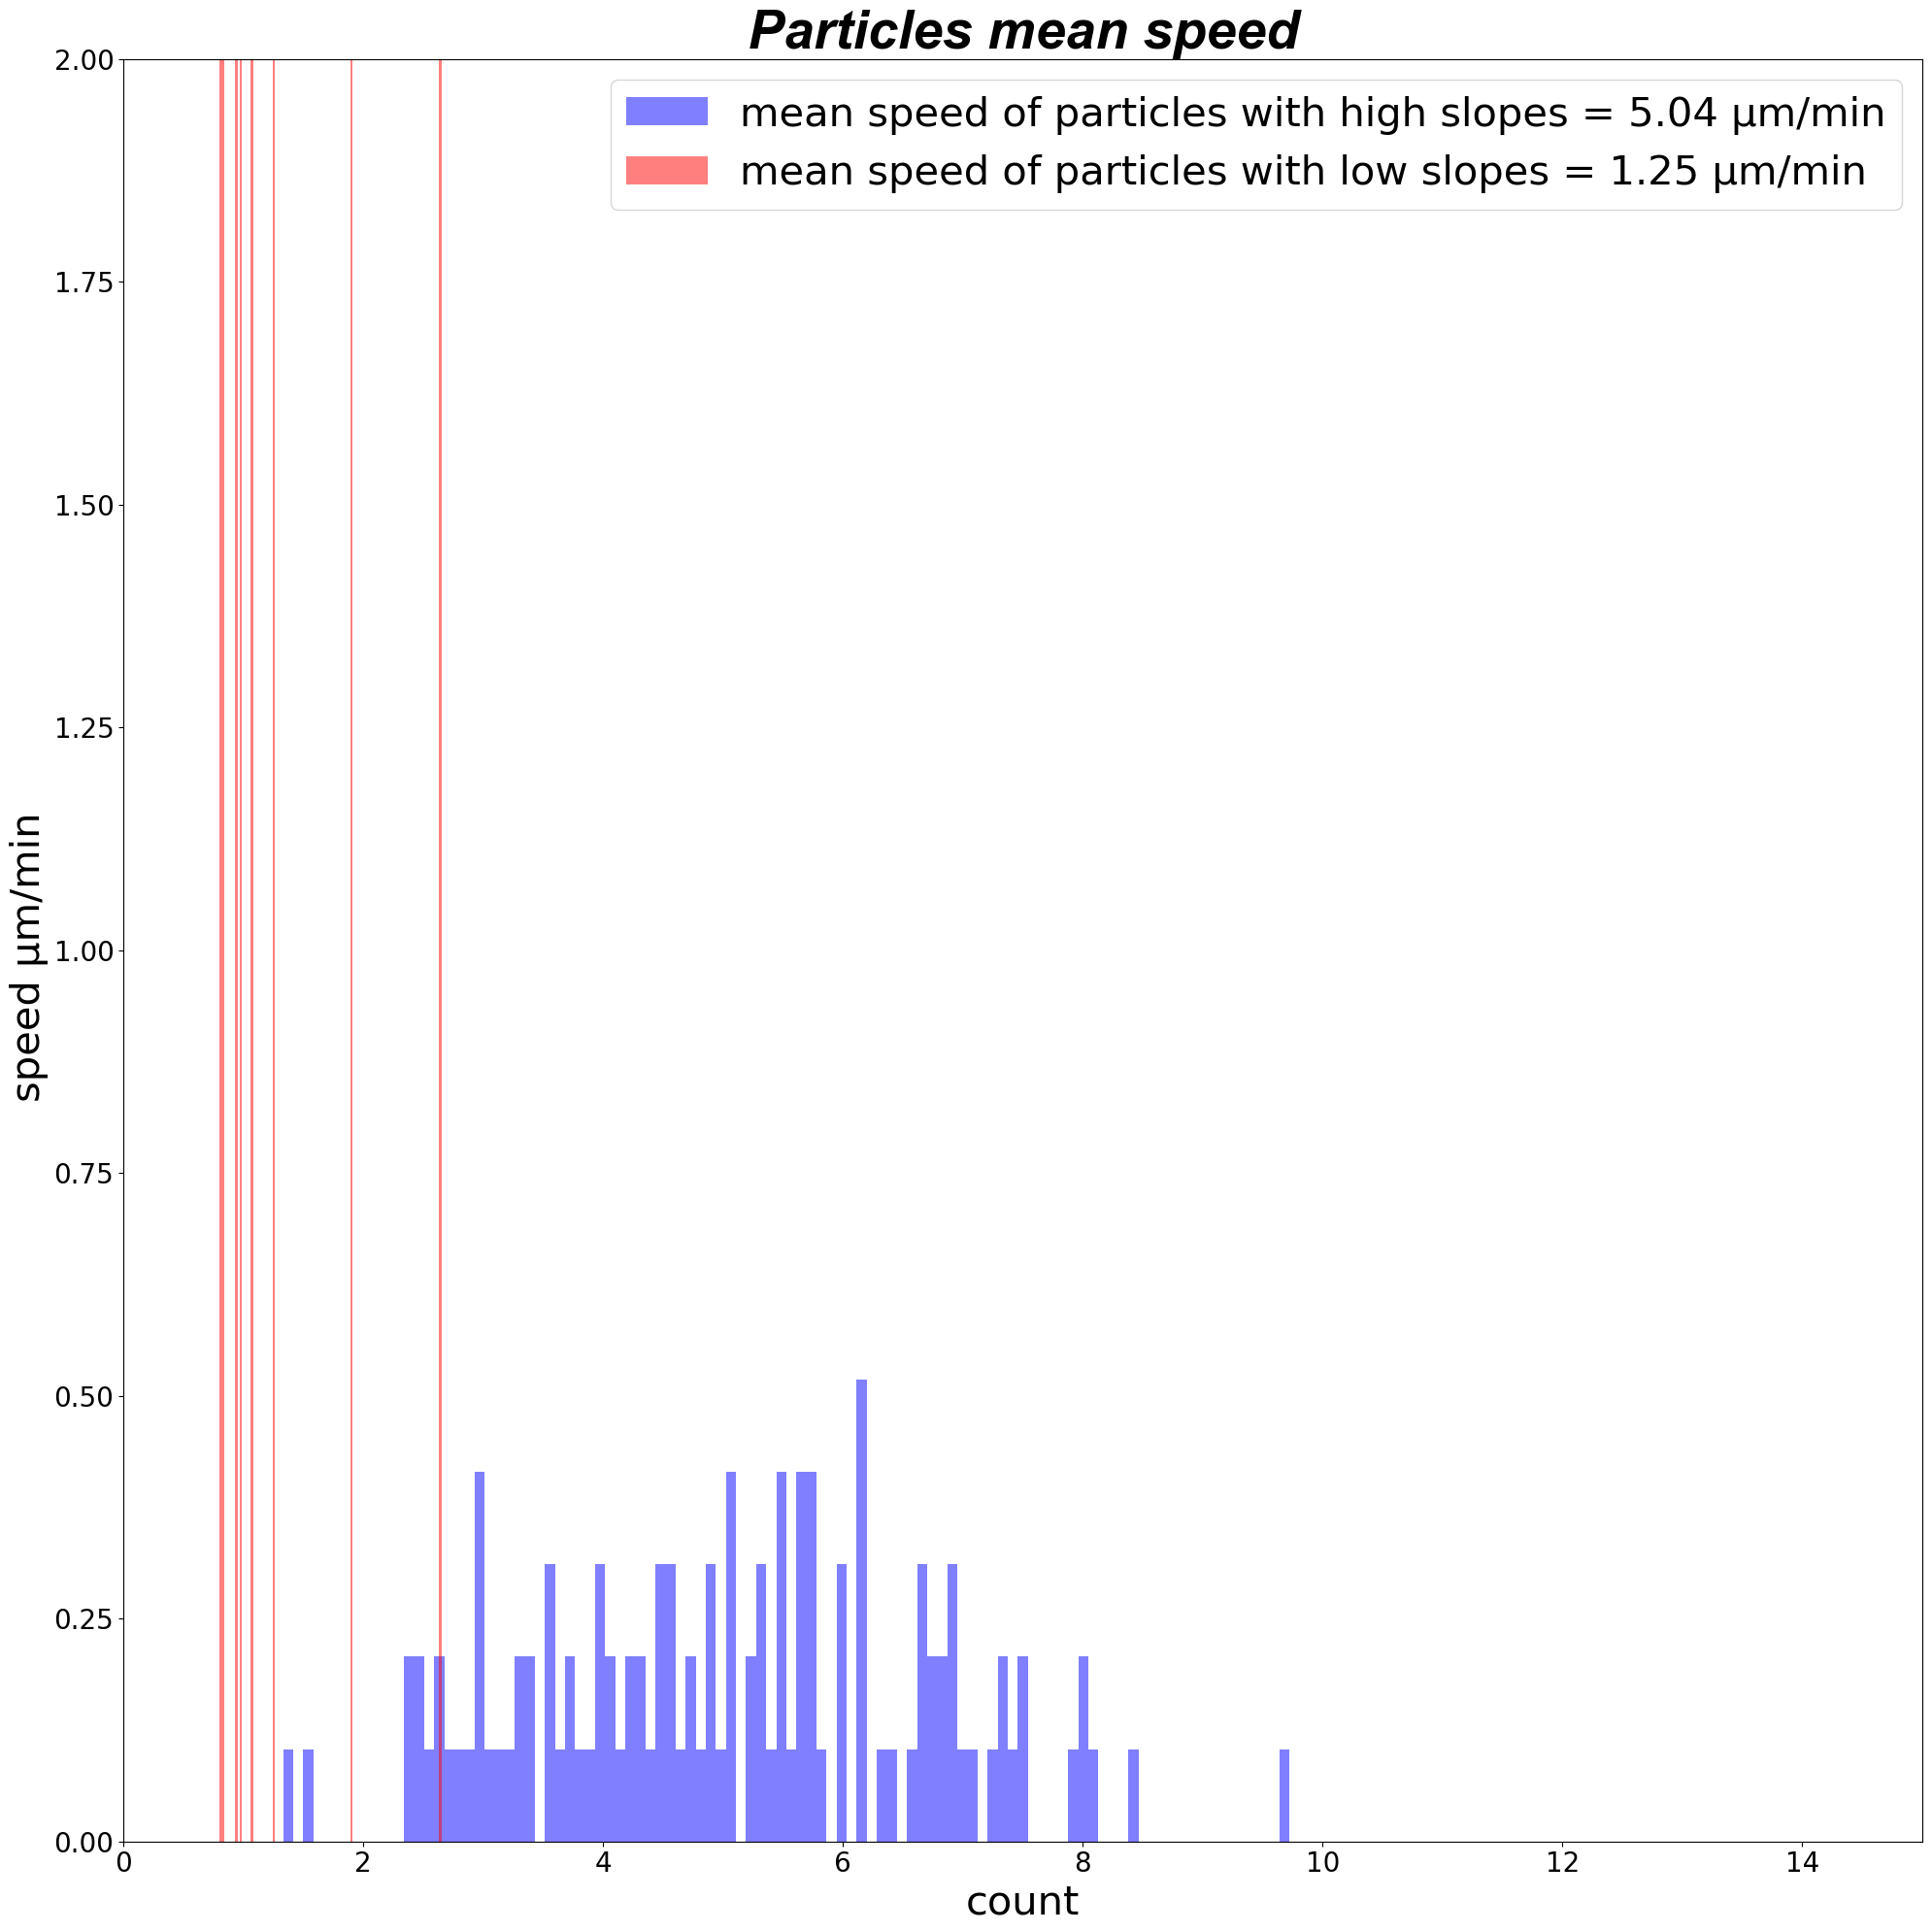

In [504]:

# %% [Mean speed for each particle]

lib.mean_speed(traj=DATA, start_end=start_end,
               part_coef_inf=PART_COEF_INF, part_coef_sup=PART_COEF_SUP,
               pathway_saving=path_save_pic, color_sup_inf=color_sup_inf)
plt.show()


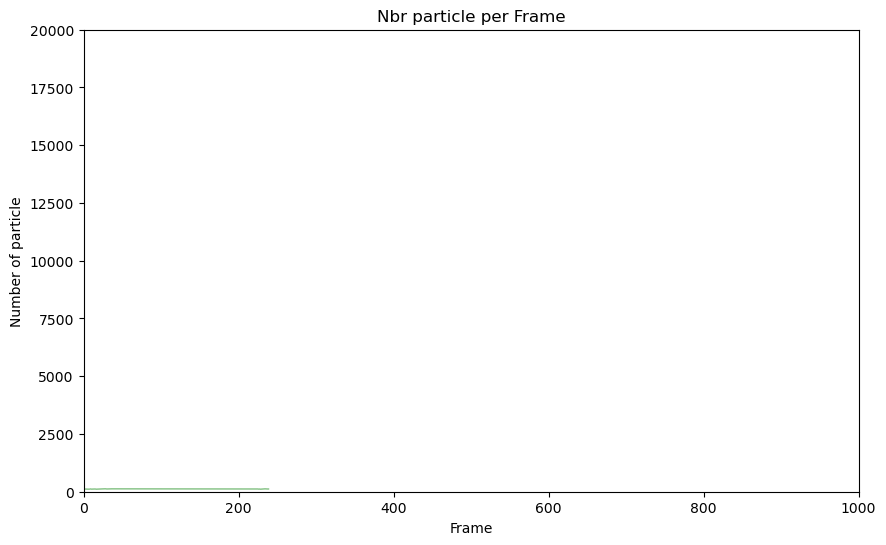

In [505]:
# %% [Number of particle on each frame]

# Grouper les données par 'frame' et calculer la moyenne de 'VitInst [um/min]'
nbr_part_per_frame = DATA.groupby('frame')['particle'].nunique()

lib.plot_datas(x_values=nbr_part_per_frame.index, y_values=nbr_part_per_frame.values,
               title='Nbr particle per Frame',
               x_label='Frame', y_label='Number of particle',
               x_lim=[0, 1000], y_lim=[0, 20000], save=True,
               path_save_pic=path_save_pic, img_type="jpg")

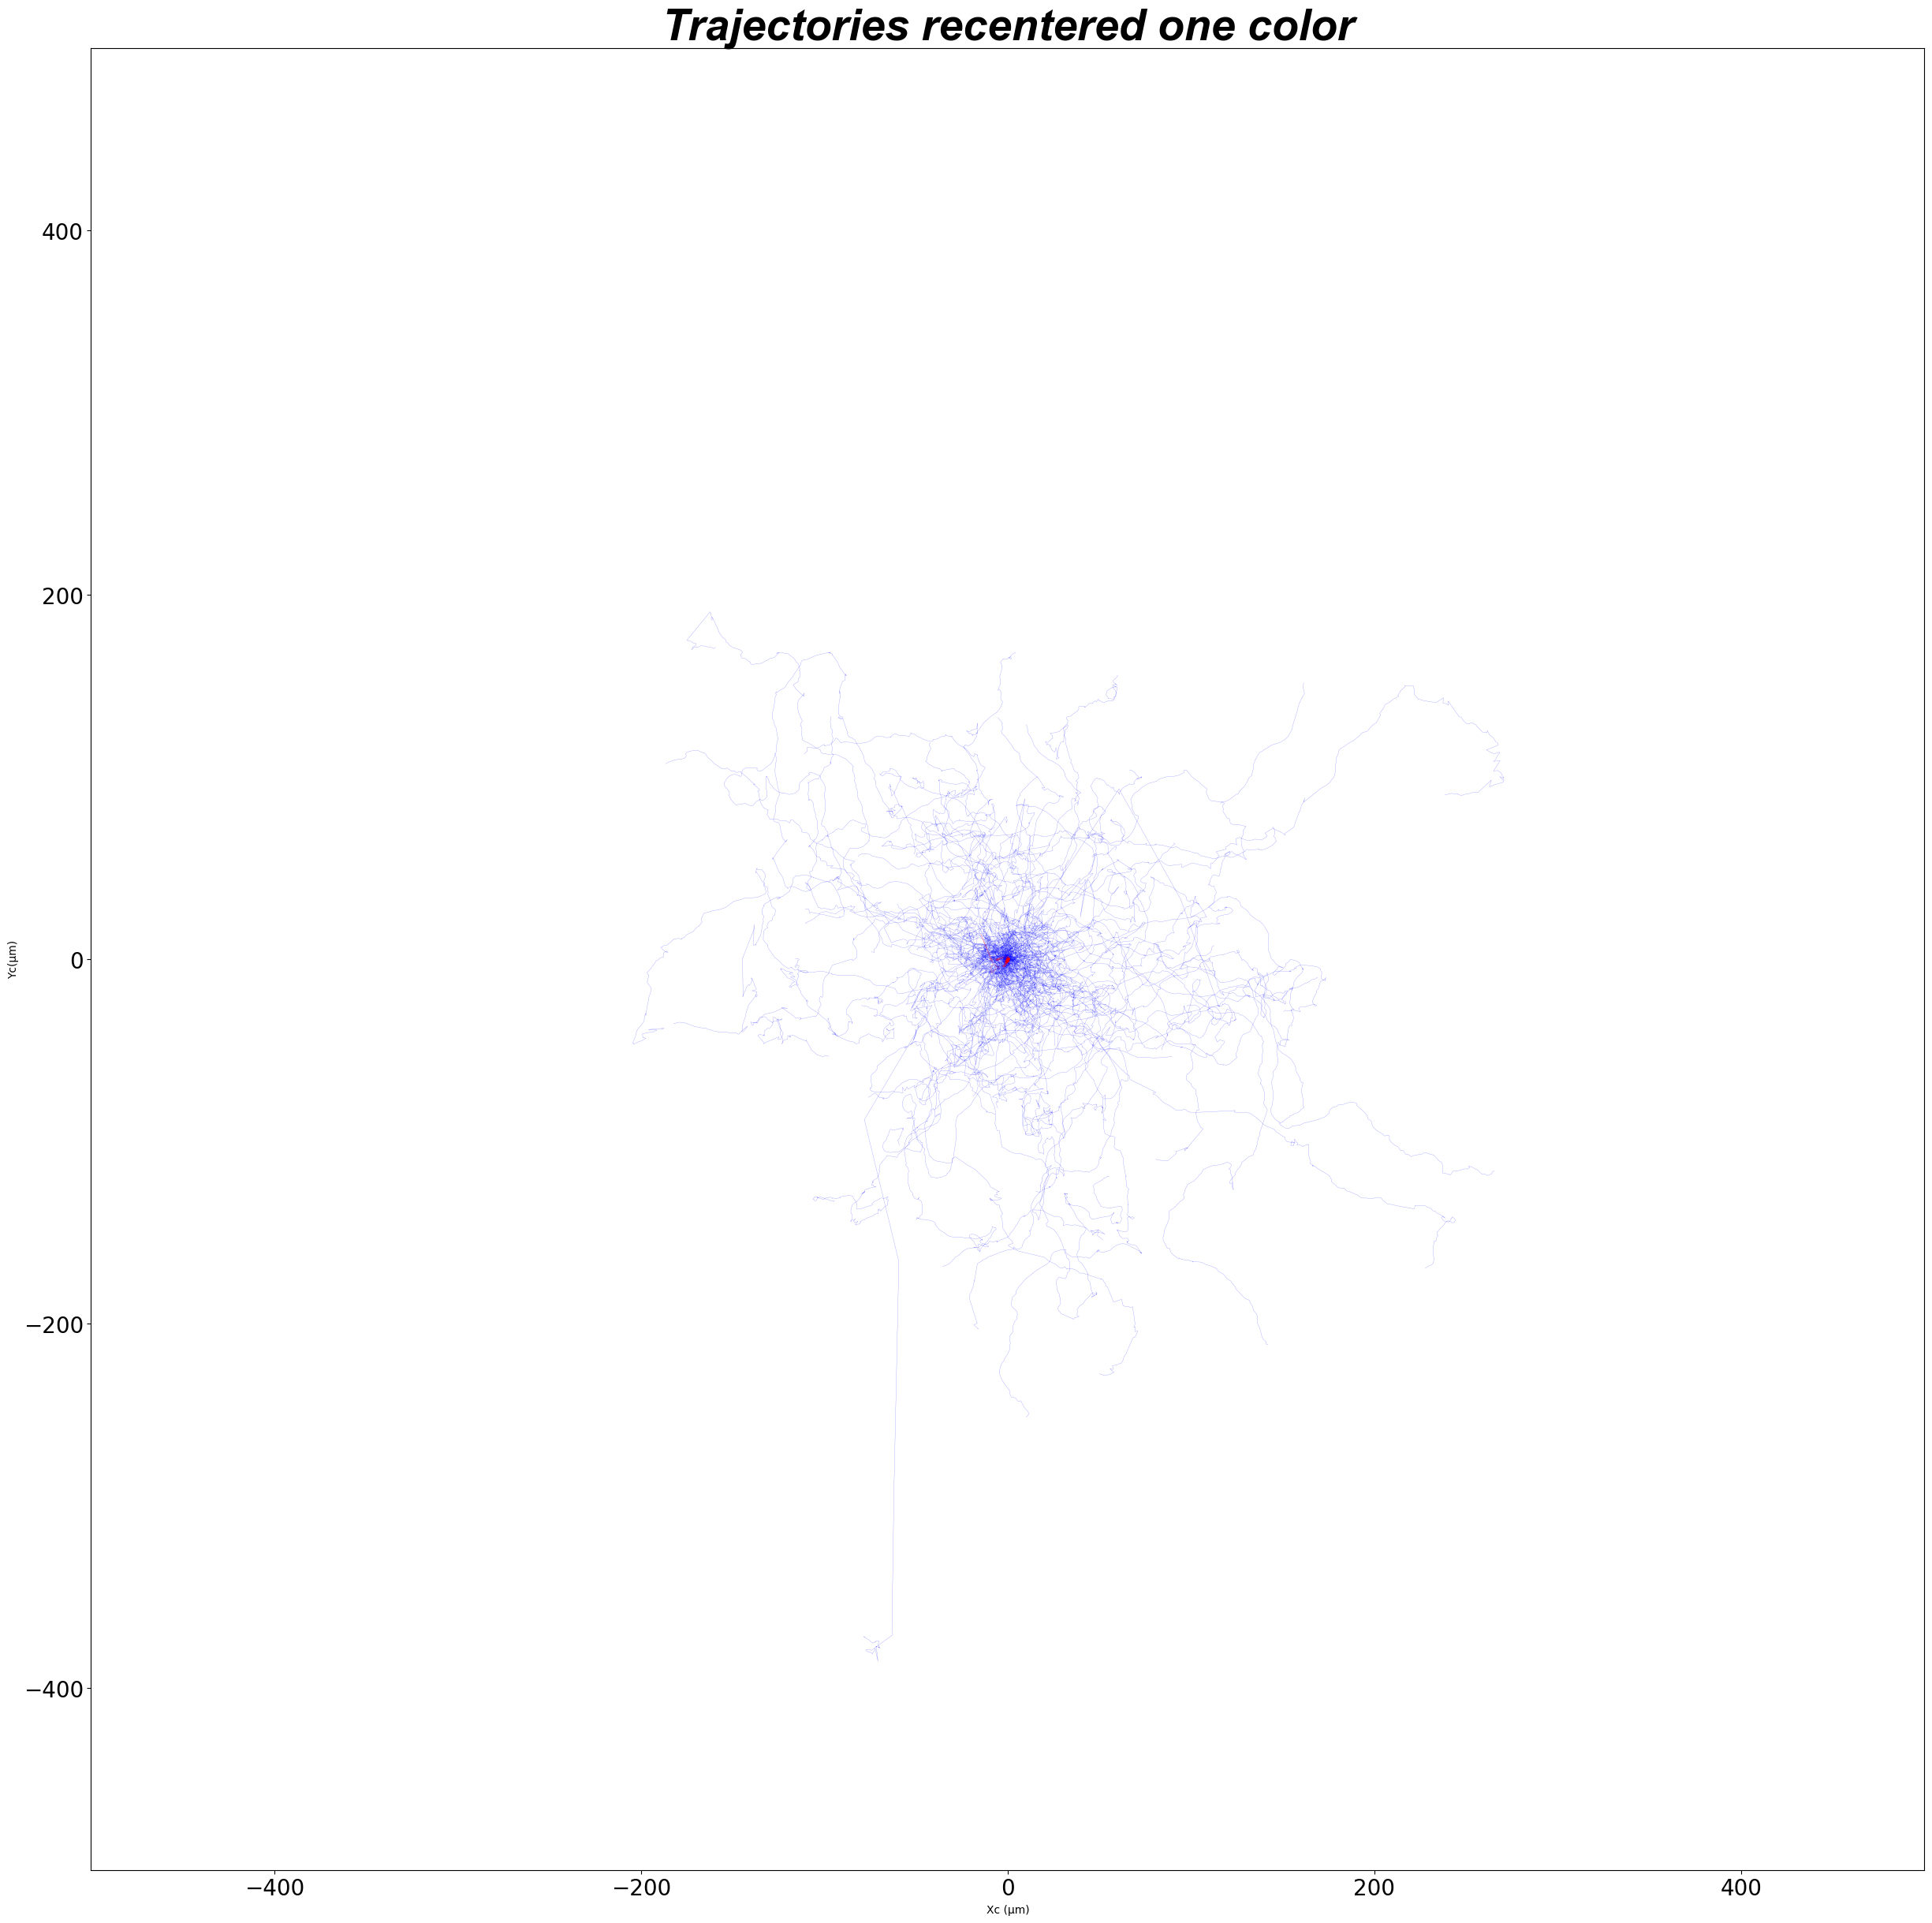

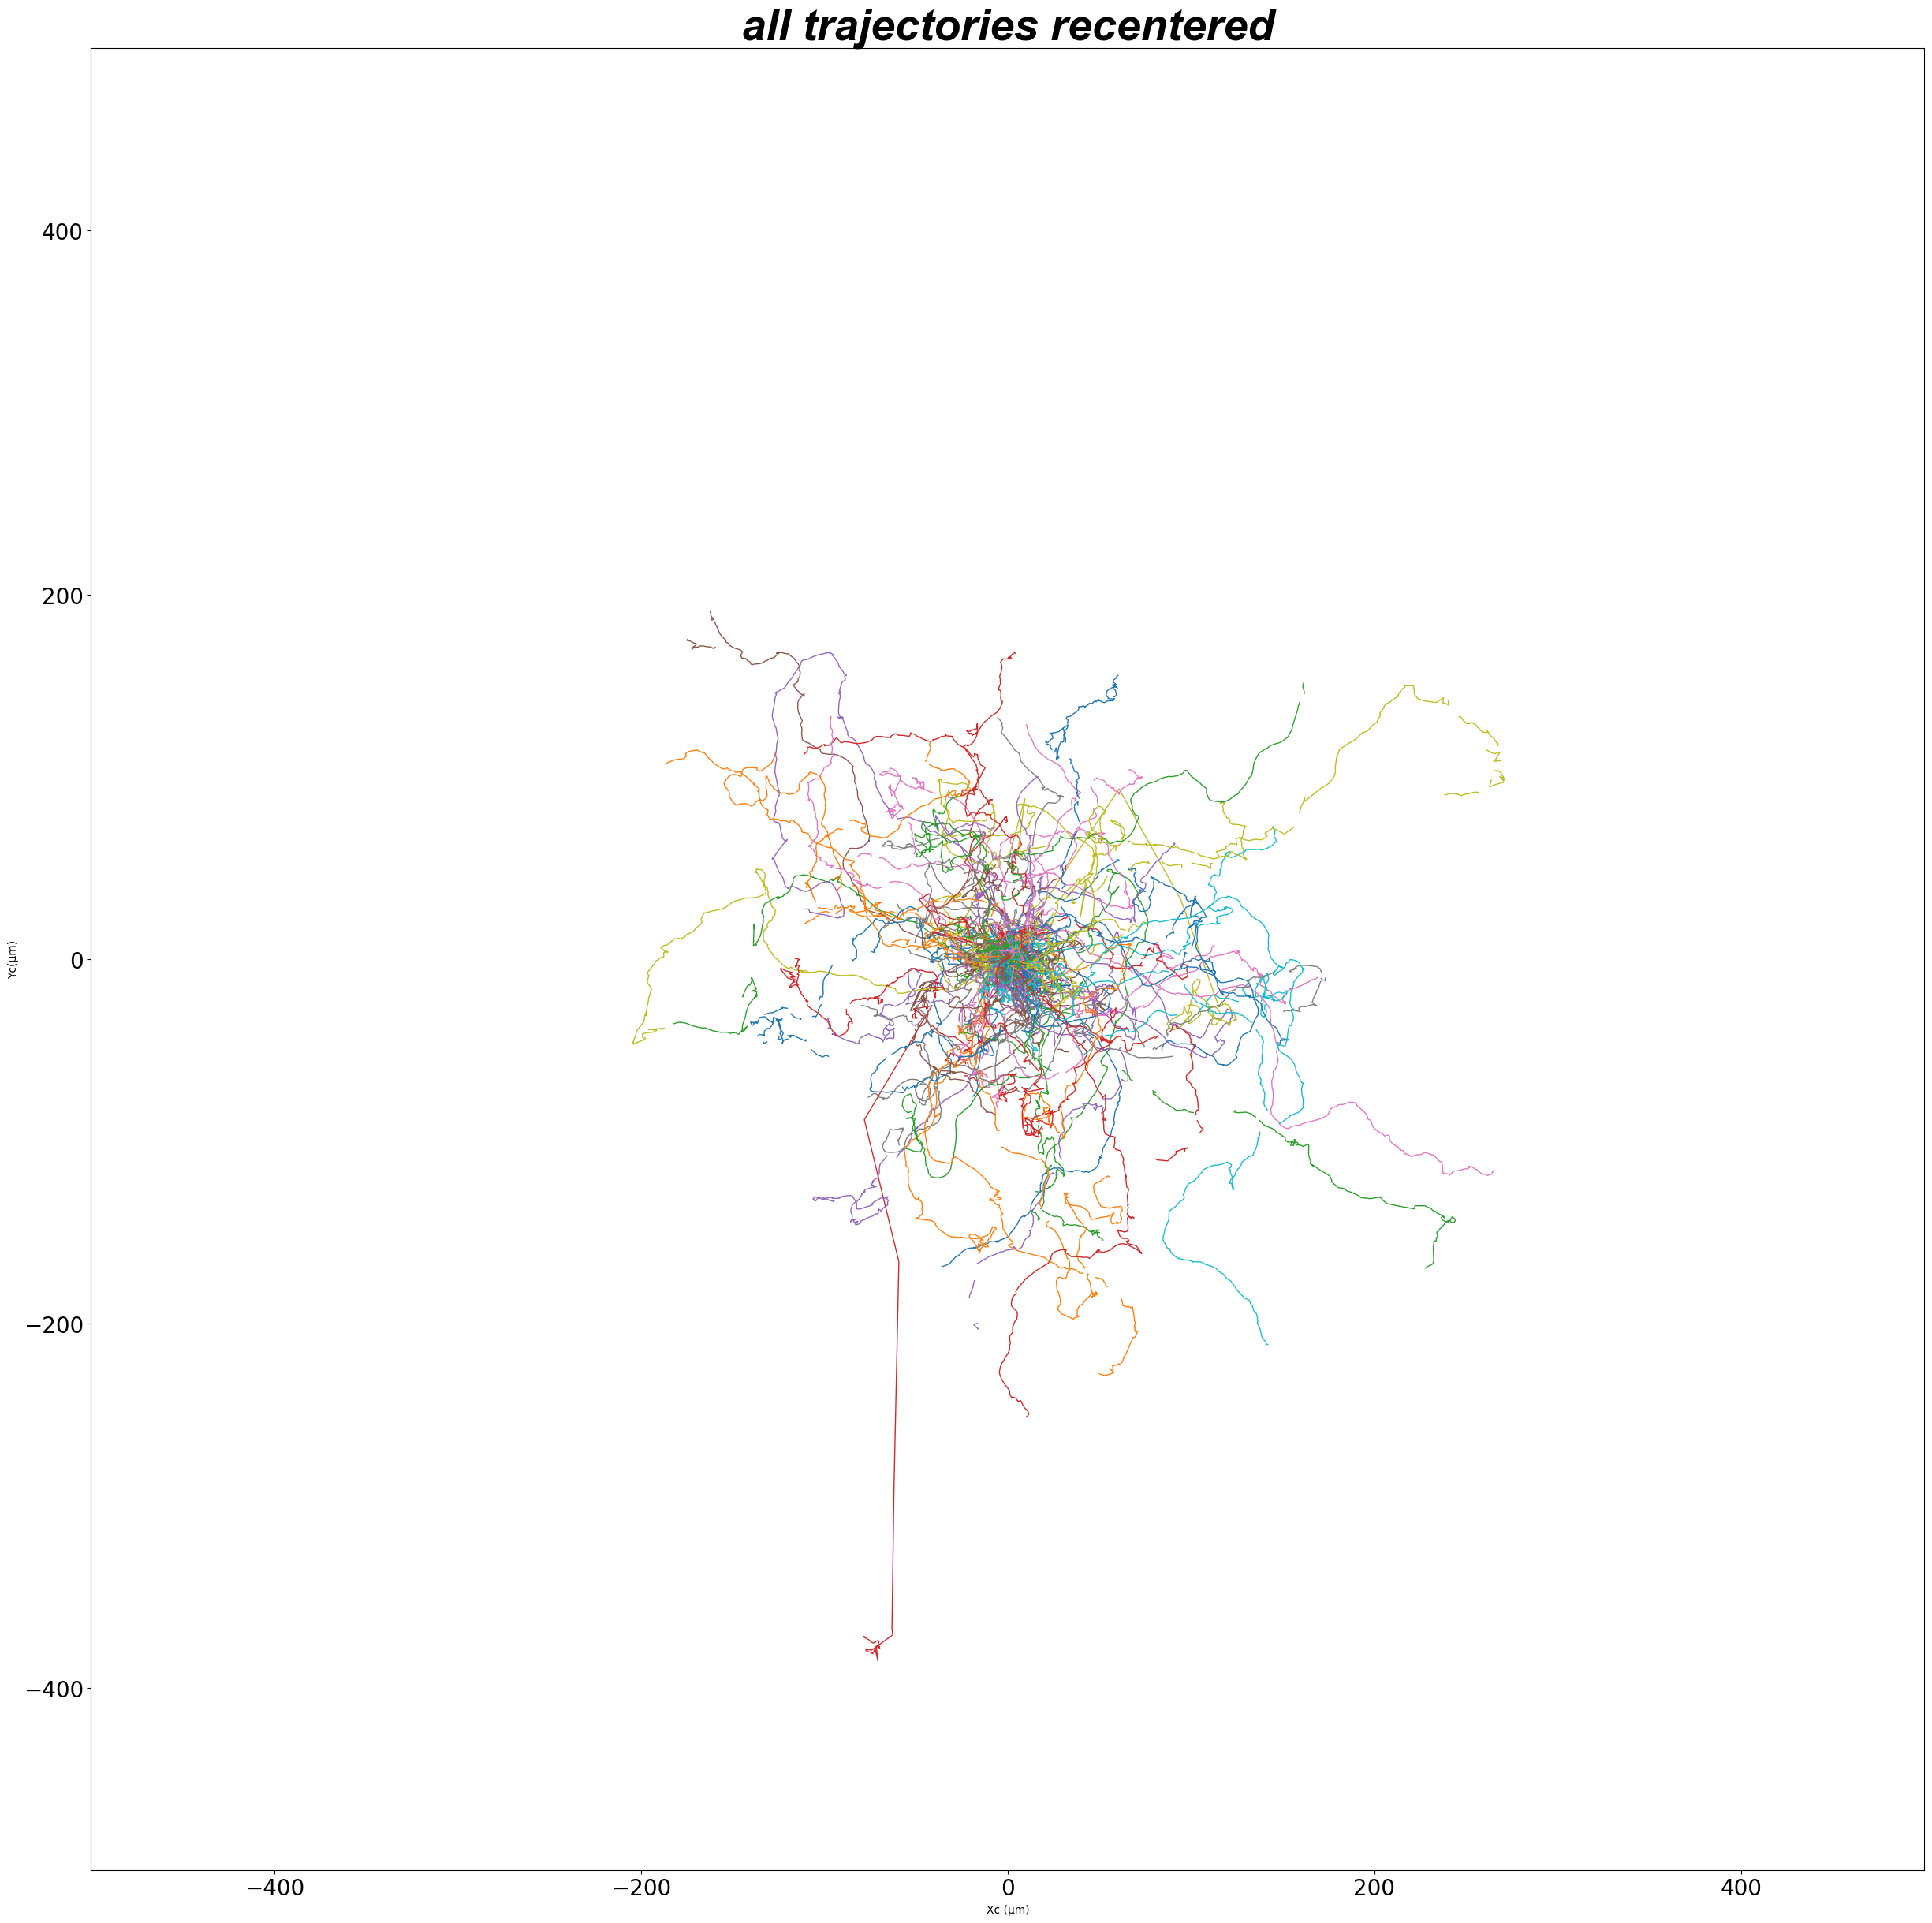

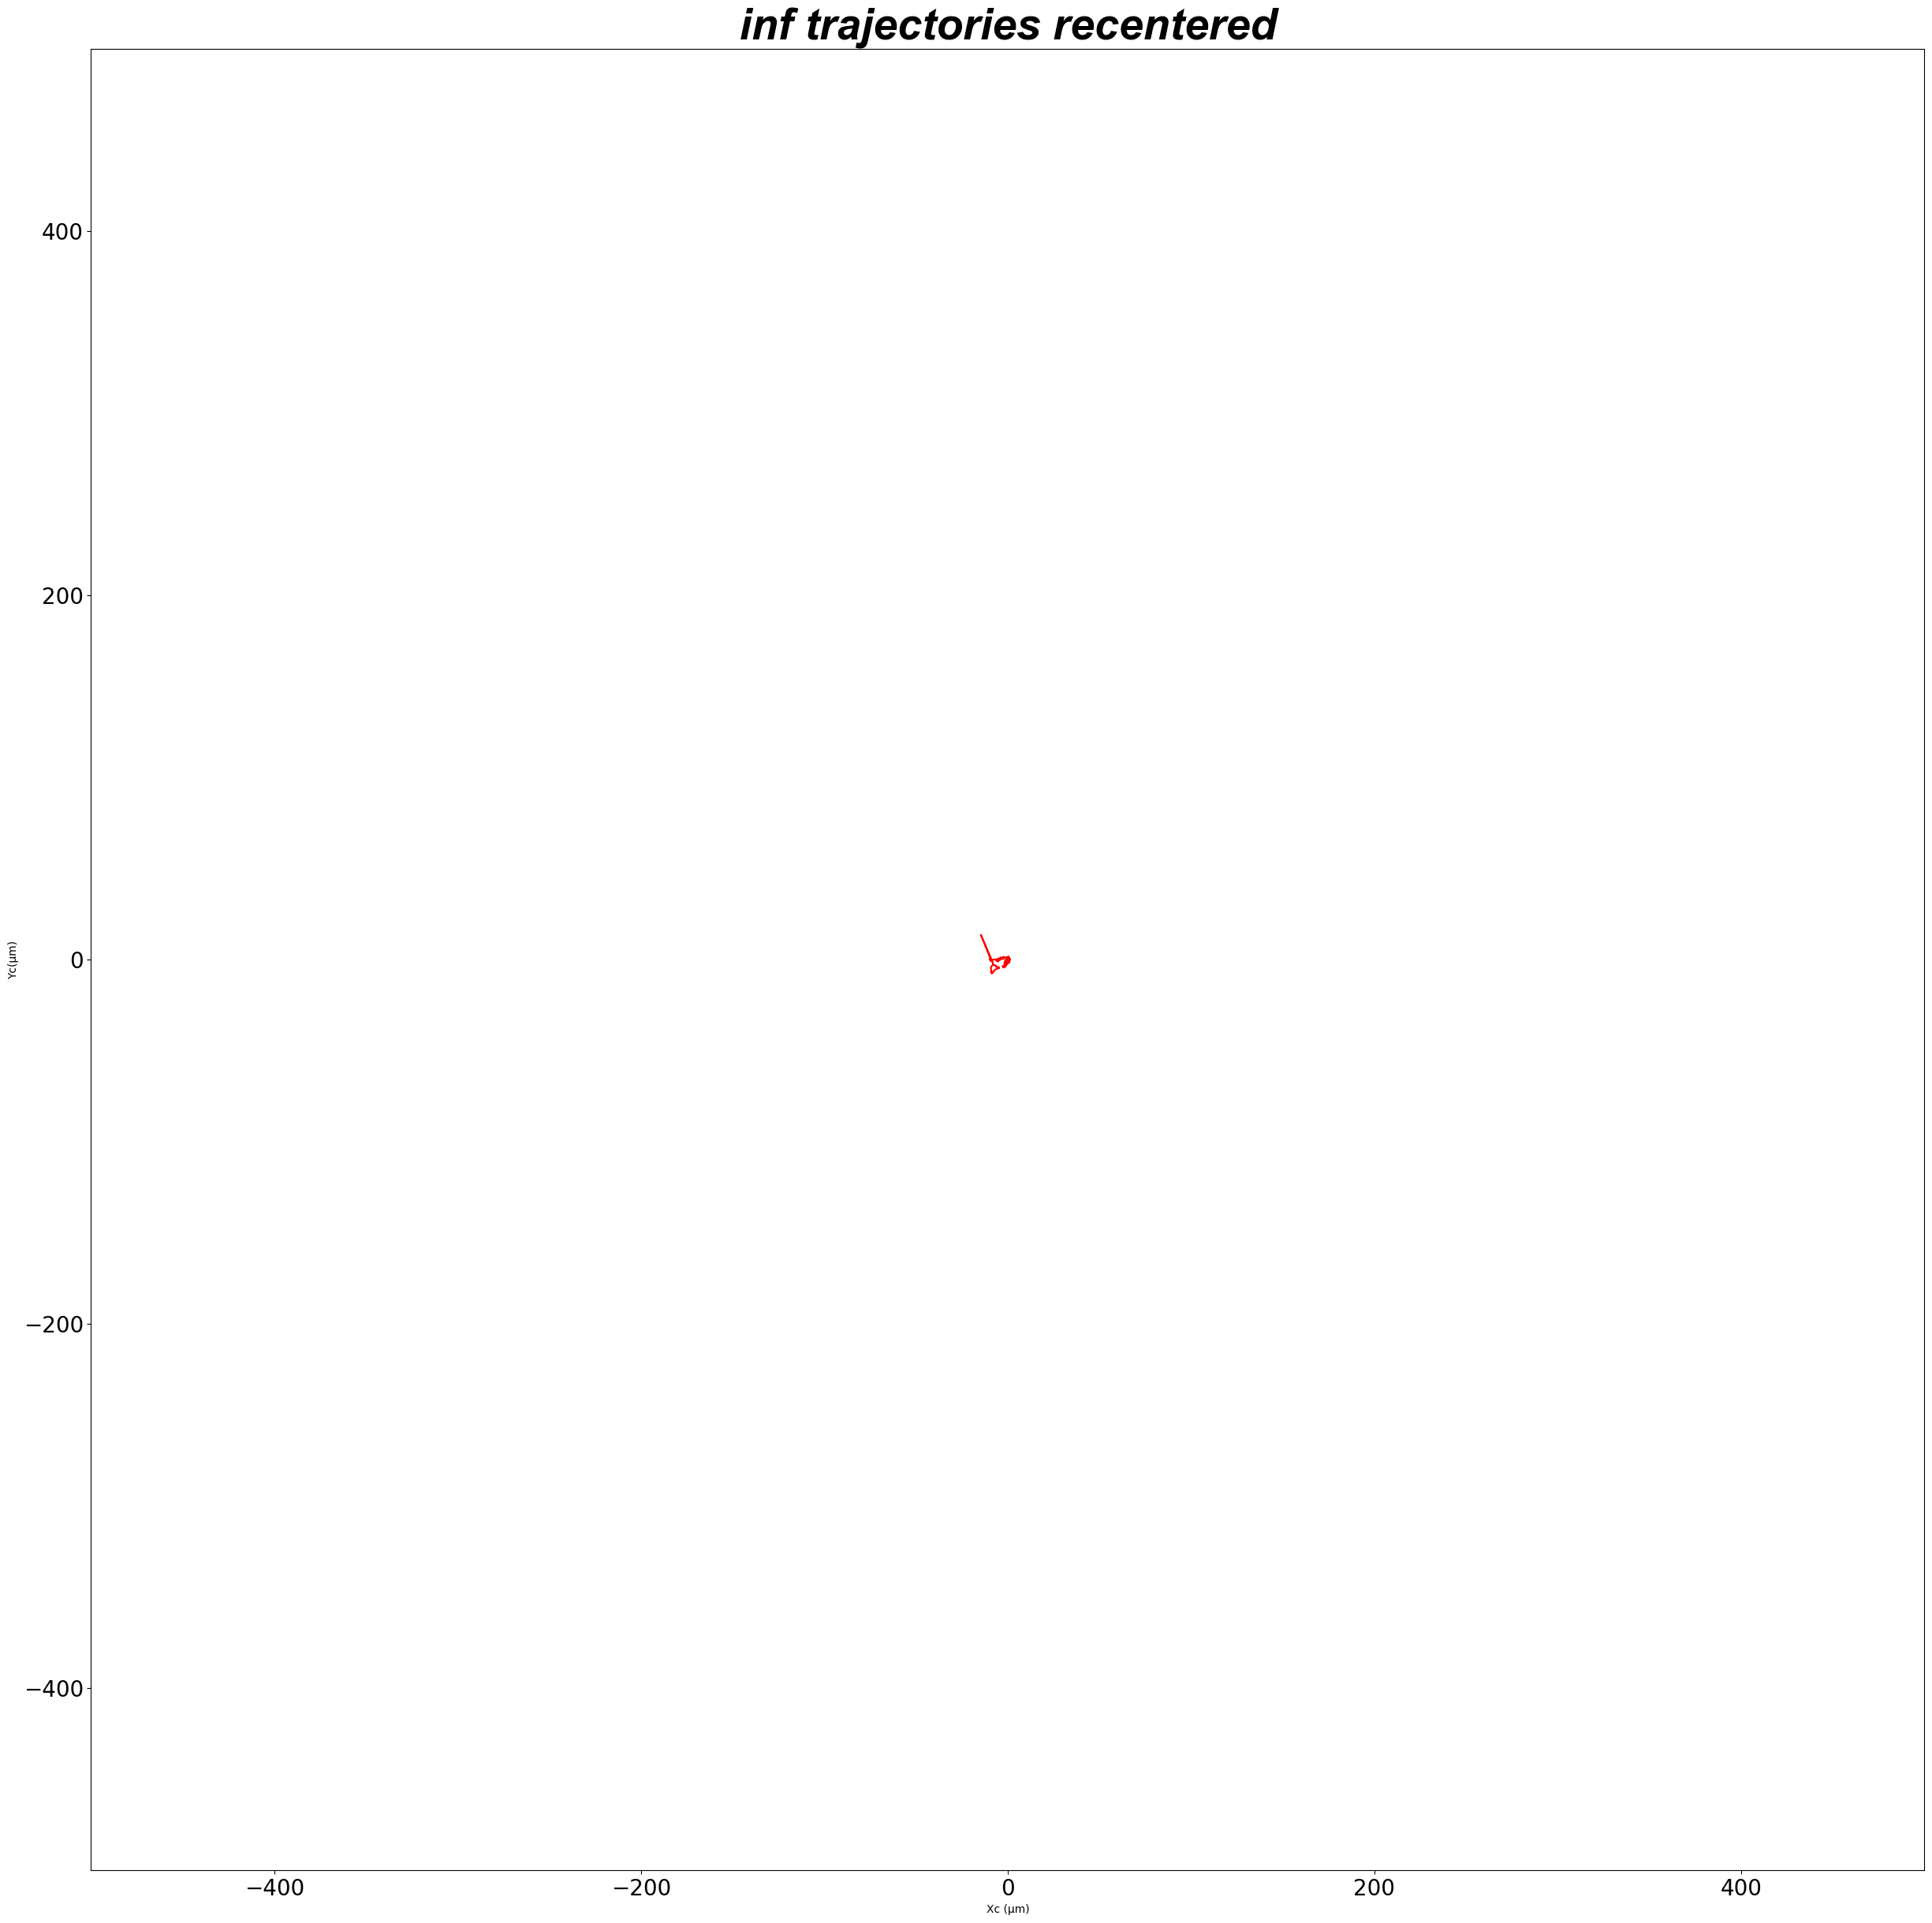

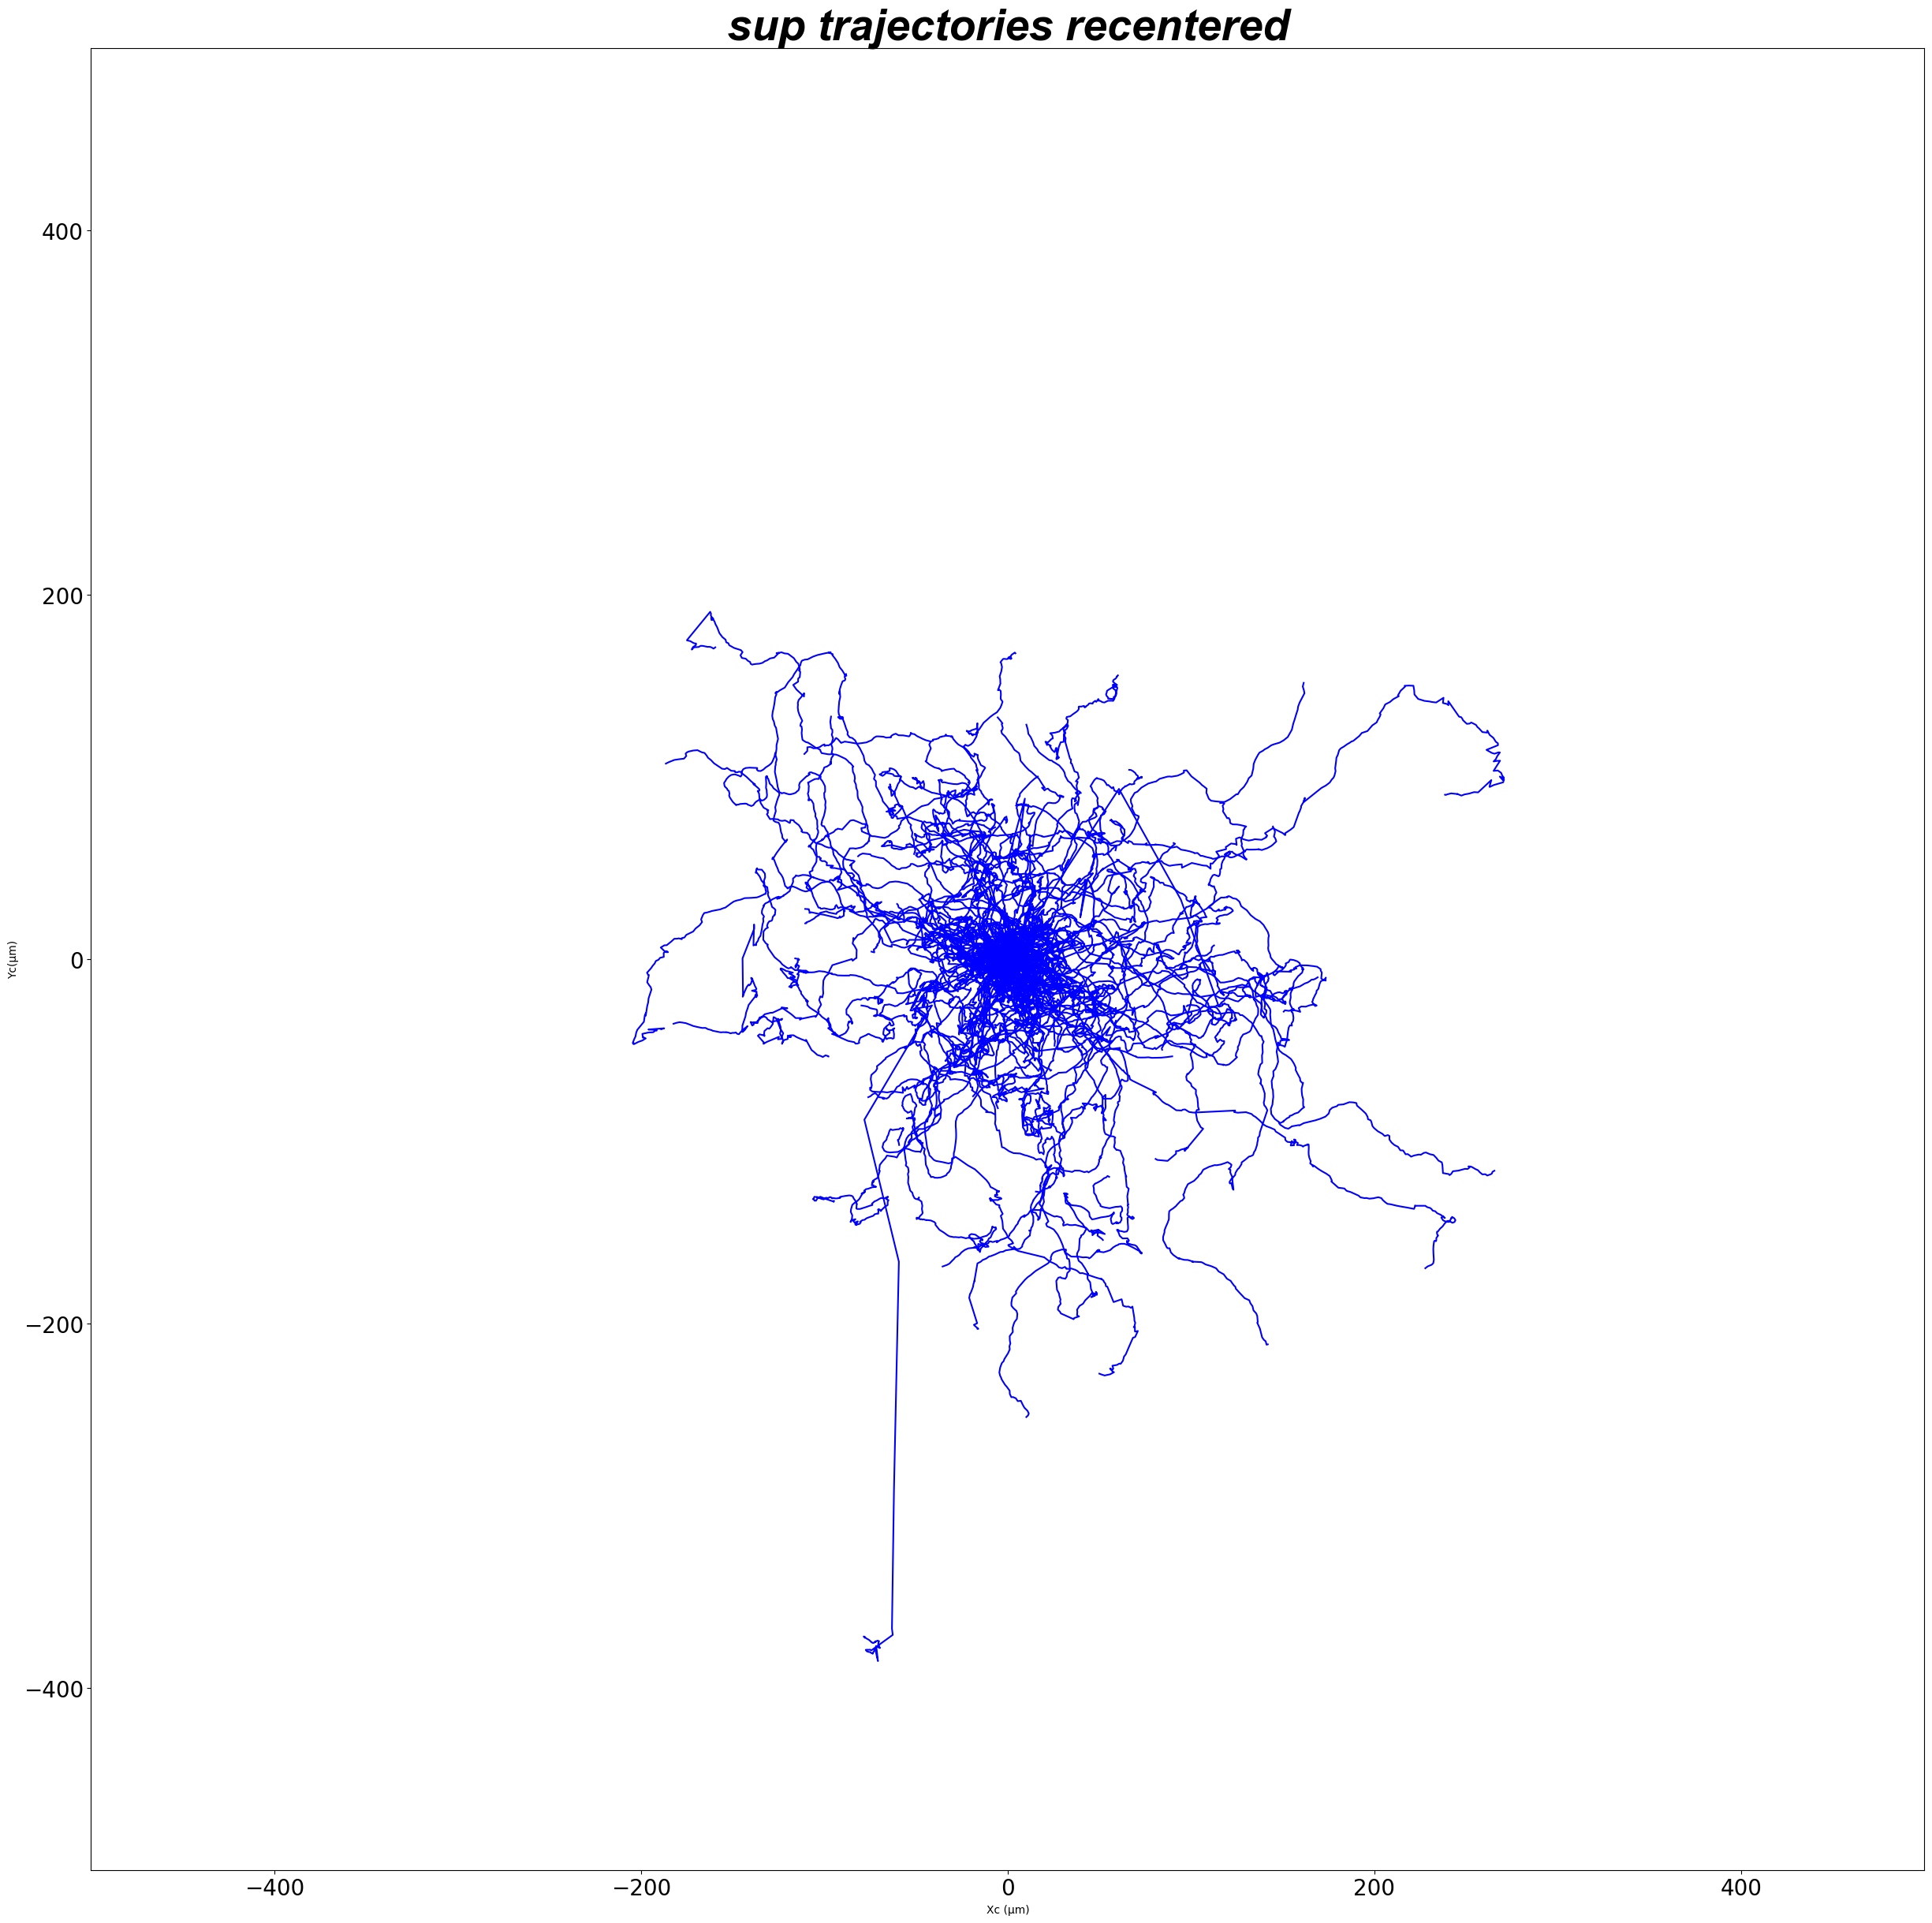

In [506]:
# %%[plot the trajectories centered]
lib.plot_centered_traj_inf_sup(traj=DATA, size_pix=SIZE_PIX,
                               PART_INF=PART_COEF_INF, PART_SUP=PART_COEF_SUP,
                               name='Trajectories recentered one color',
                               xlim=[-500, 500], ylim=[-500, 500],
                               color_sup_inf=(COLOR_SUP, COLOR_INF), save=True,
                               pathway_fig=path_save_pic, img_type="jpg")

lib.plot_centered_traj(traj=DATA.loc[DATA['frame'] <= 240],
                       size_pix=SIZE_PIX, save=True,
                       xlim=[-500, 500], ylim=[-500, 500],
                       pathway_fig=path_save_pic, name="all trajectories recentered")

if len(DATA_INF) > 0:
    lib.plot_centered_traj(traj=DATA_INF.loc[DATA_INF['frame'] <= 240],
                           size_pix=SIZE_PIX, save=True,
                           xlim=[-500, 500], ylim=[-500, 500],
                           linewidth=0.1, alpha=0.5,
                           pathway_fig=path_save_pic, name="inf trajectories recentered",
                           color=COLOR_INF)

if len(DATA_SUP) > 0:
    lib.plot_centered_traj(traj=DATA_SUP.loc[DATA_SUP['frame'] <= 240],
                           size_pix=SIZE_PIX, save=True,
                           xlim=[-500, 500], ylim=[-500, 500],
                           linewidth=0.1, alpha=0.5,
                           pathway_fig=path_save_pic, name="sup trajectories recentered",
                           color=COLOR_SUP,
                           )

In [507]:
def gif_centered_traj(data: pd.DataFrame(), path_save_pic: str,
                      linewidth: float = 0.2, alpha: float = 0.5,
                      last_frame: int = 240, gap_frame: int = 11,
                      save: str = False):
    """
    Generate of a gif for the evolution of the traj.

    Parameters
    ----------
    data : pd.DataFrame()
        DESCRIPTION.
    path_save_pic : str
        DESCRIPTION.
    linewidth : float, optional
        DESCRIPTION. The default is 0.2.
    alpha : float, optional
        DESCRIPTION. The default is 0.5.
    last_frame : int, optional
        DESCRIPTION. The default is 240.
    gap_frame : int, optional
        DESCRIPTION. The default is 10.

    Returns
    -------
    None.

    """
    path = path_save_pic + '/gif_centered/'
    if not os.path.exists(path):
        os.mkdir(path)
    fig, ax = plt.subplots(figsize=(30, 30))
    ax.set(xlabel='Xc (µm)', ylabel='Yc(µm)')
    ax.set_xlim([-500, 500])
    ax.set_ylim([-500, 500])
    ax.tick_params(axis='both', which='major', labelsize=20)

    for i in range(1, last_frame, gap_frame):
        # DATA_centered = DATA.loc[DATA['frame'] <= i]
        DATA_centered = data.loc[(data['frame'] >= i) & (DATA['frame'] < i + 10)]
        plt.title(f'Trajectories recentered {i}', fontsize=40,
                  fontweight="bold", fontstyle='italic', fontname="Arial")

        # Ajout des points de données de la frame courante
        tp.plot_traj(DATA_centered, pos_columns=['Xc [pix]', 'Yc [pix]'],
                     ax=ax, color=None, linewidth=linewidth, alpha=alpha)

        # Sauvegardez la figure
        if save:
            fig.savefig(path + f"Trajectories recentered frame {i}.png", format='png')


In [508]:
print(path_save_pic)

/Users/souchaud/Desktop/Analyses/résultats_CytoOne_HL5_10x_new_param_ALL_OK_x5_15s/


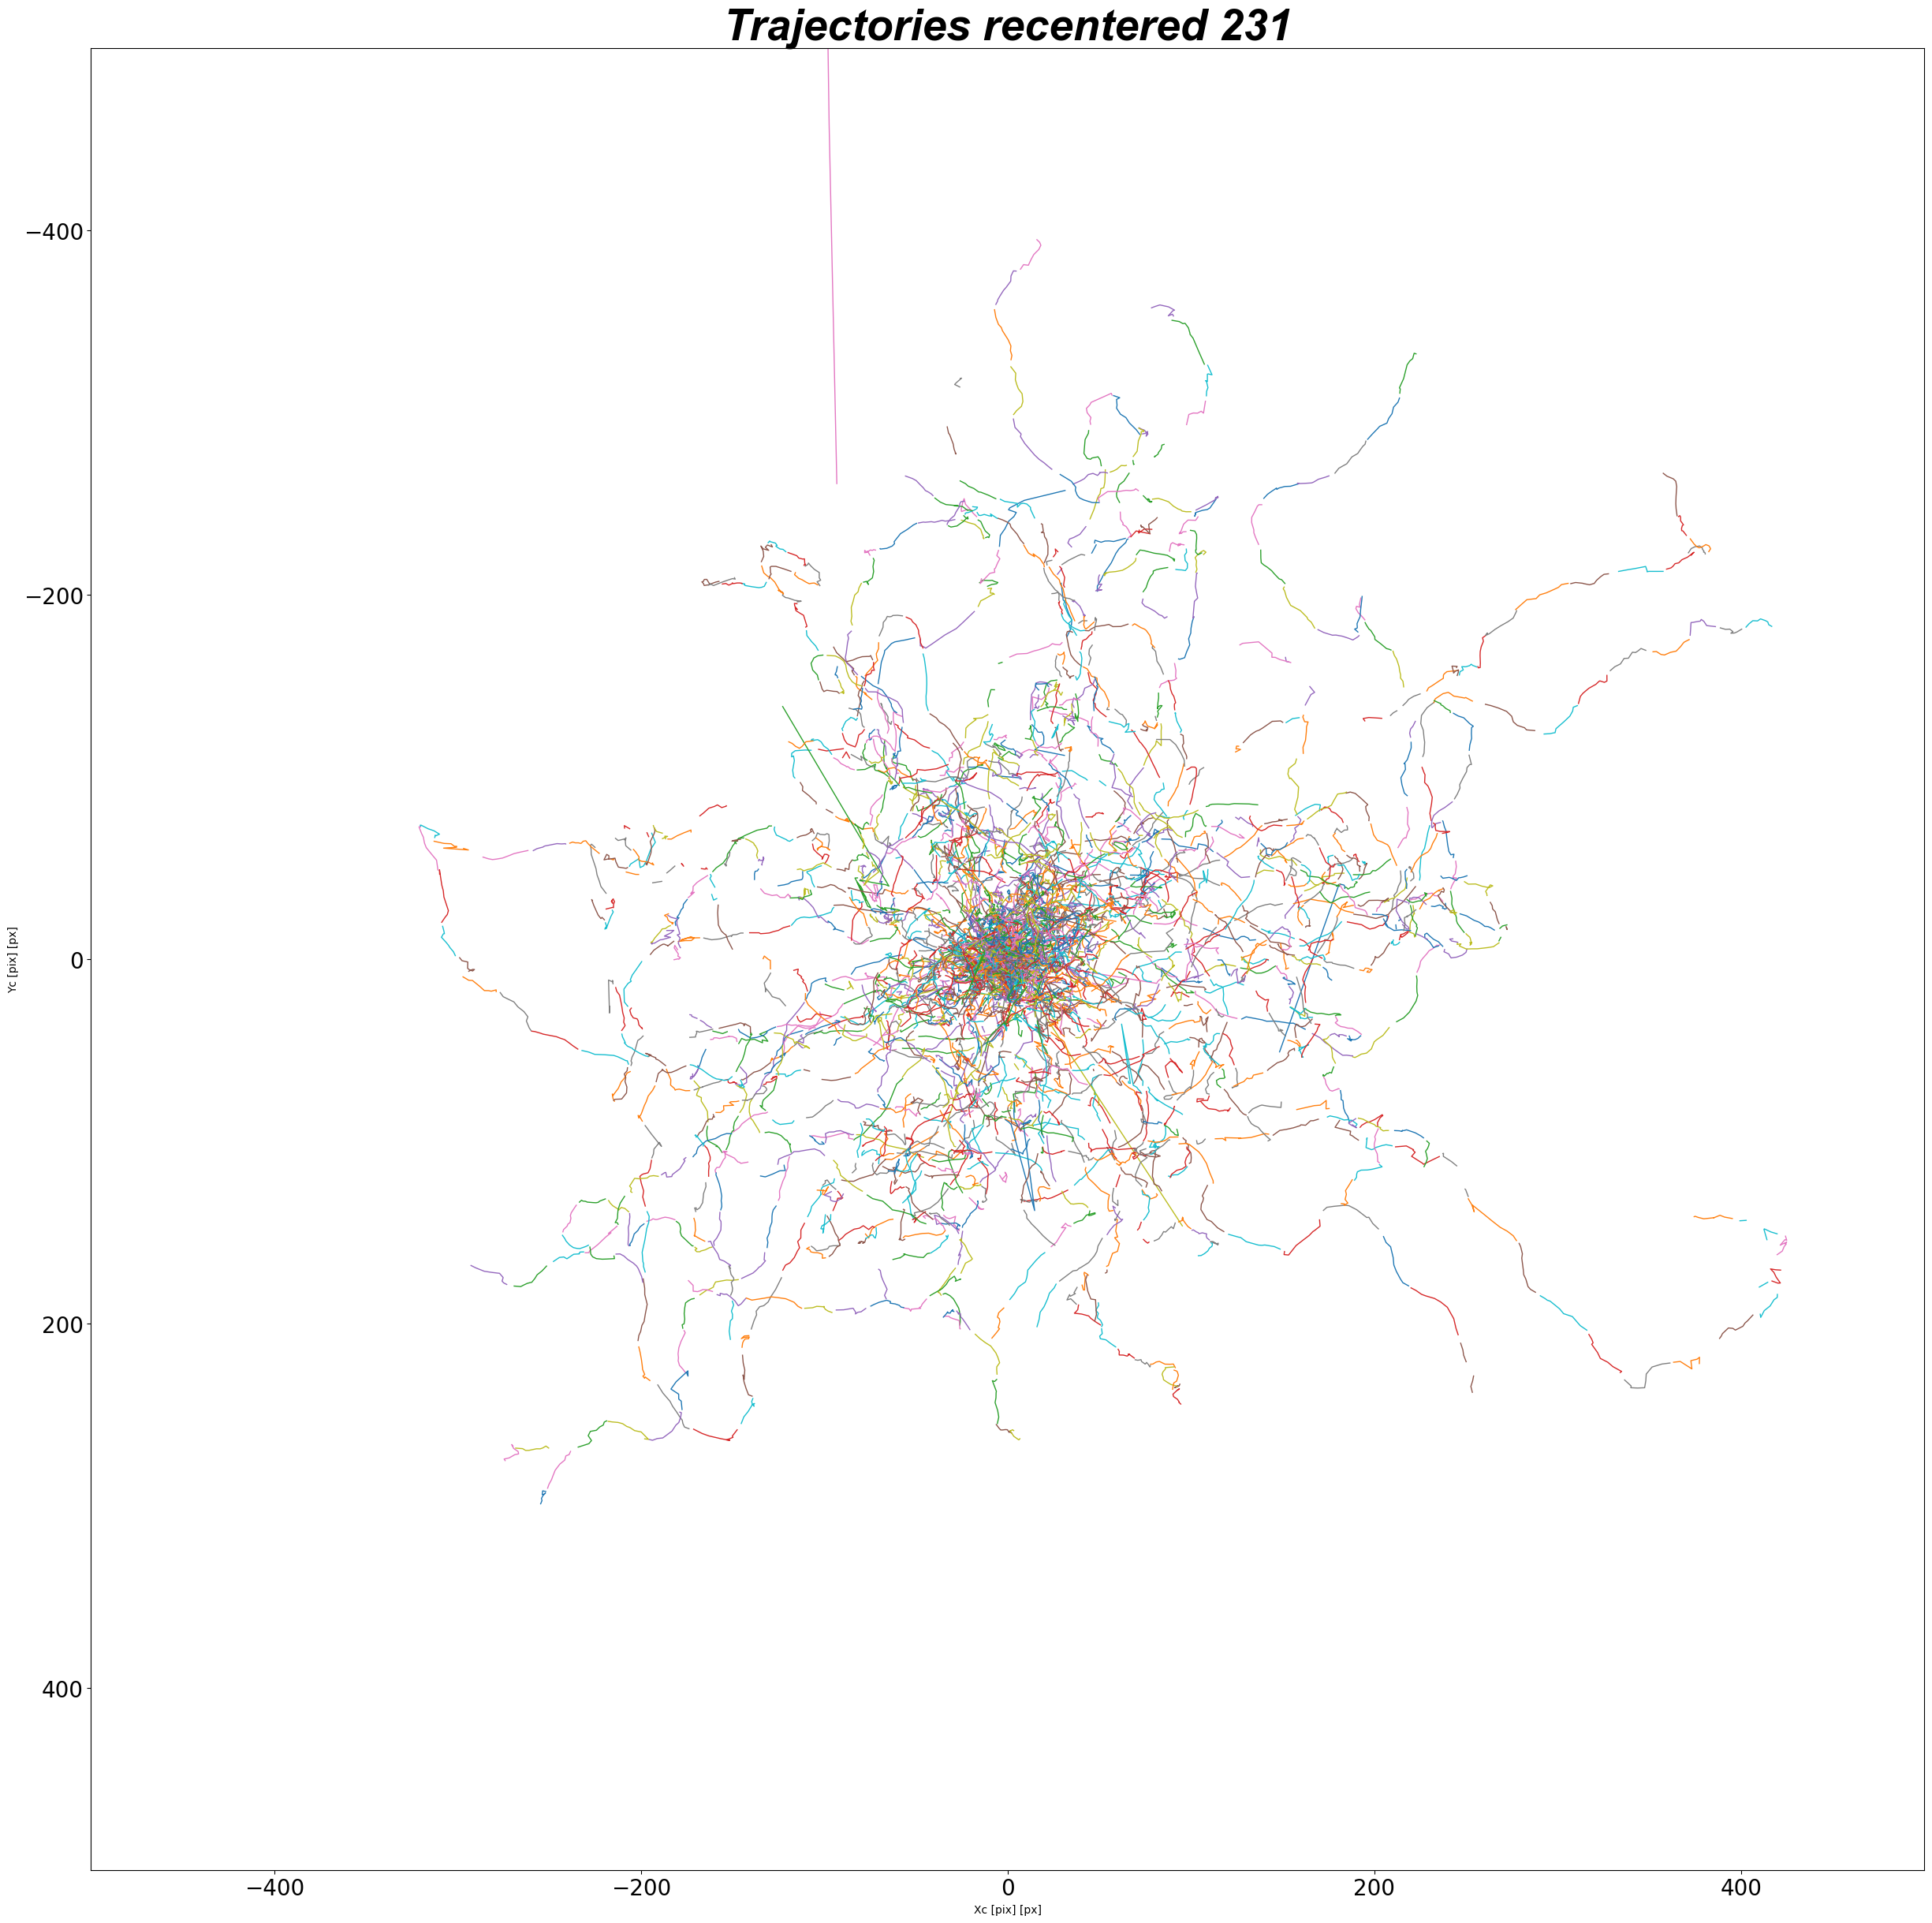

In [509]:
gif_centered_traj(data=DATA, path_save_pic=path_save_pic, linewidth=0.2,
                  alpha=0.5, last_frame=240, gap_frame=10, save=True)

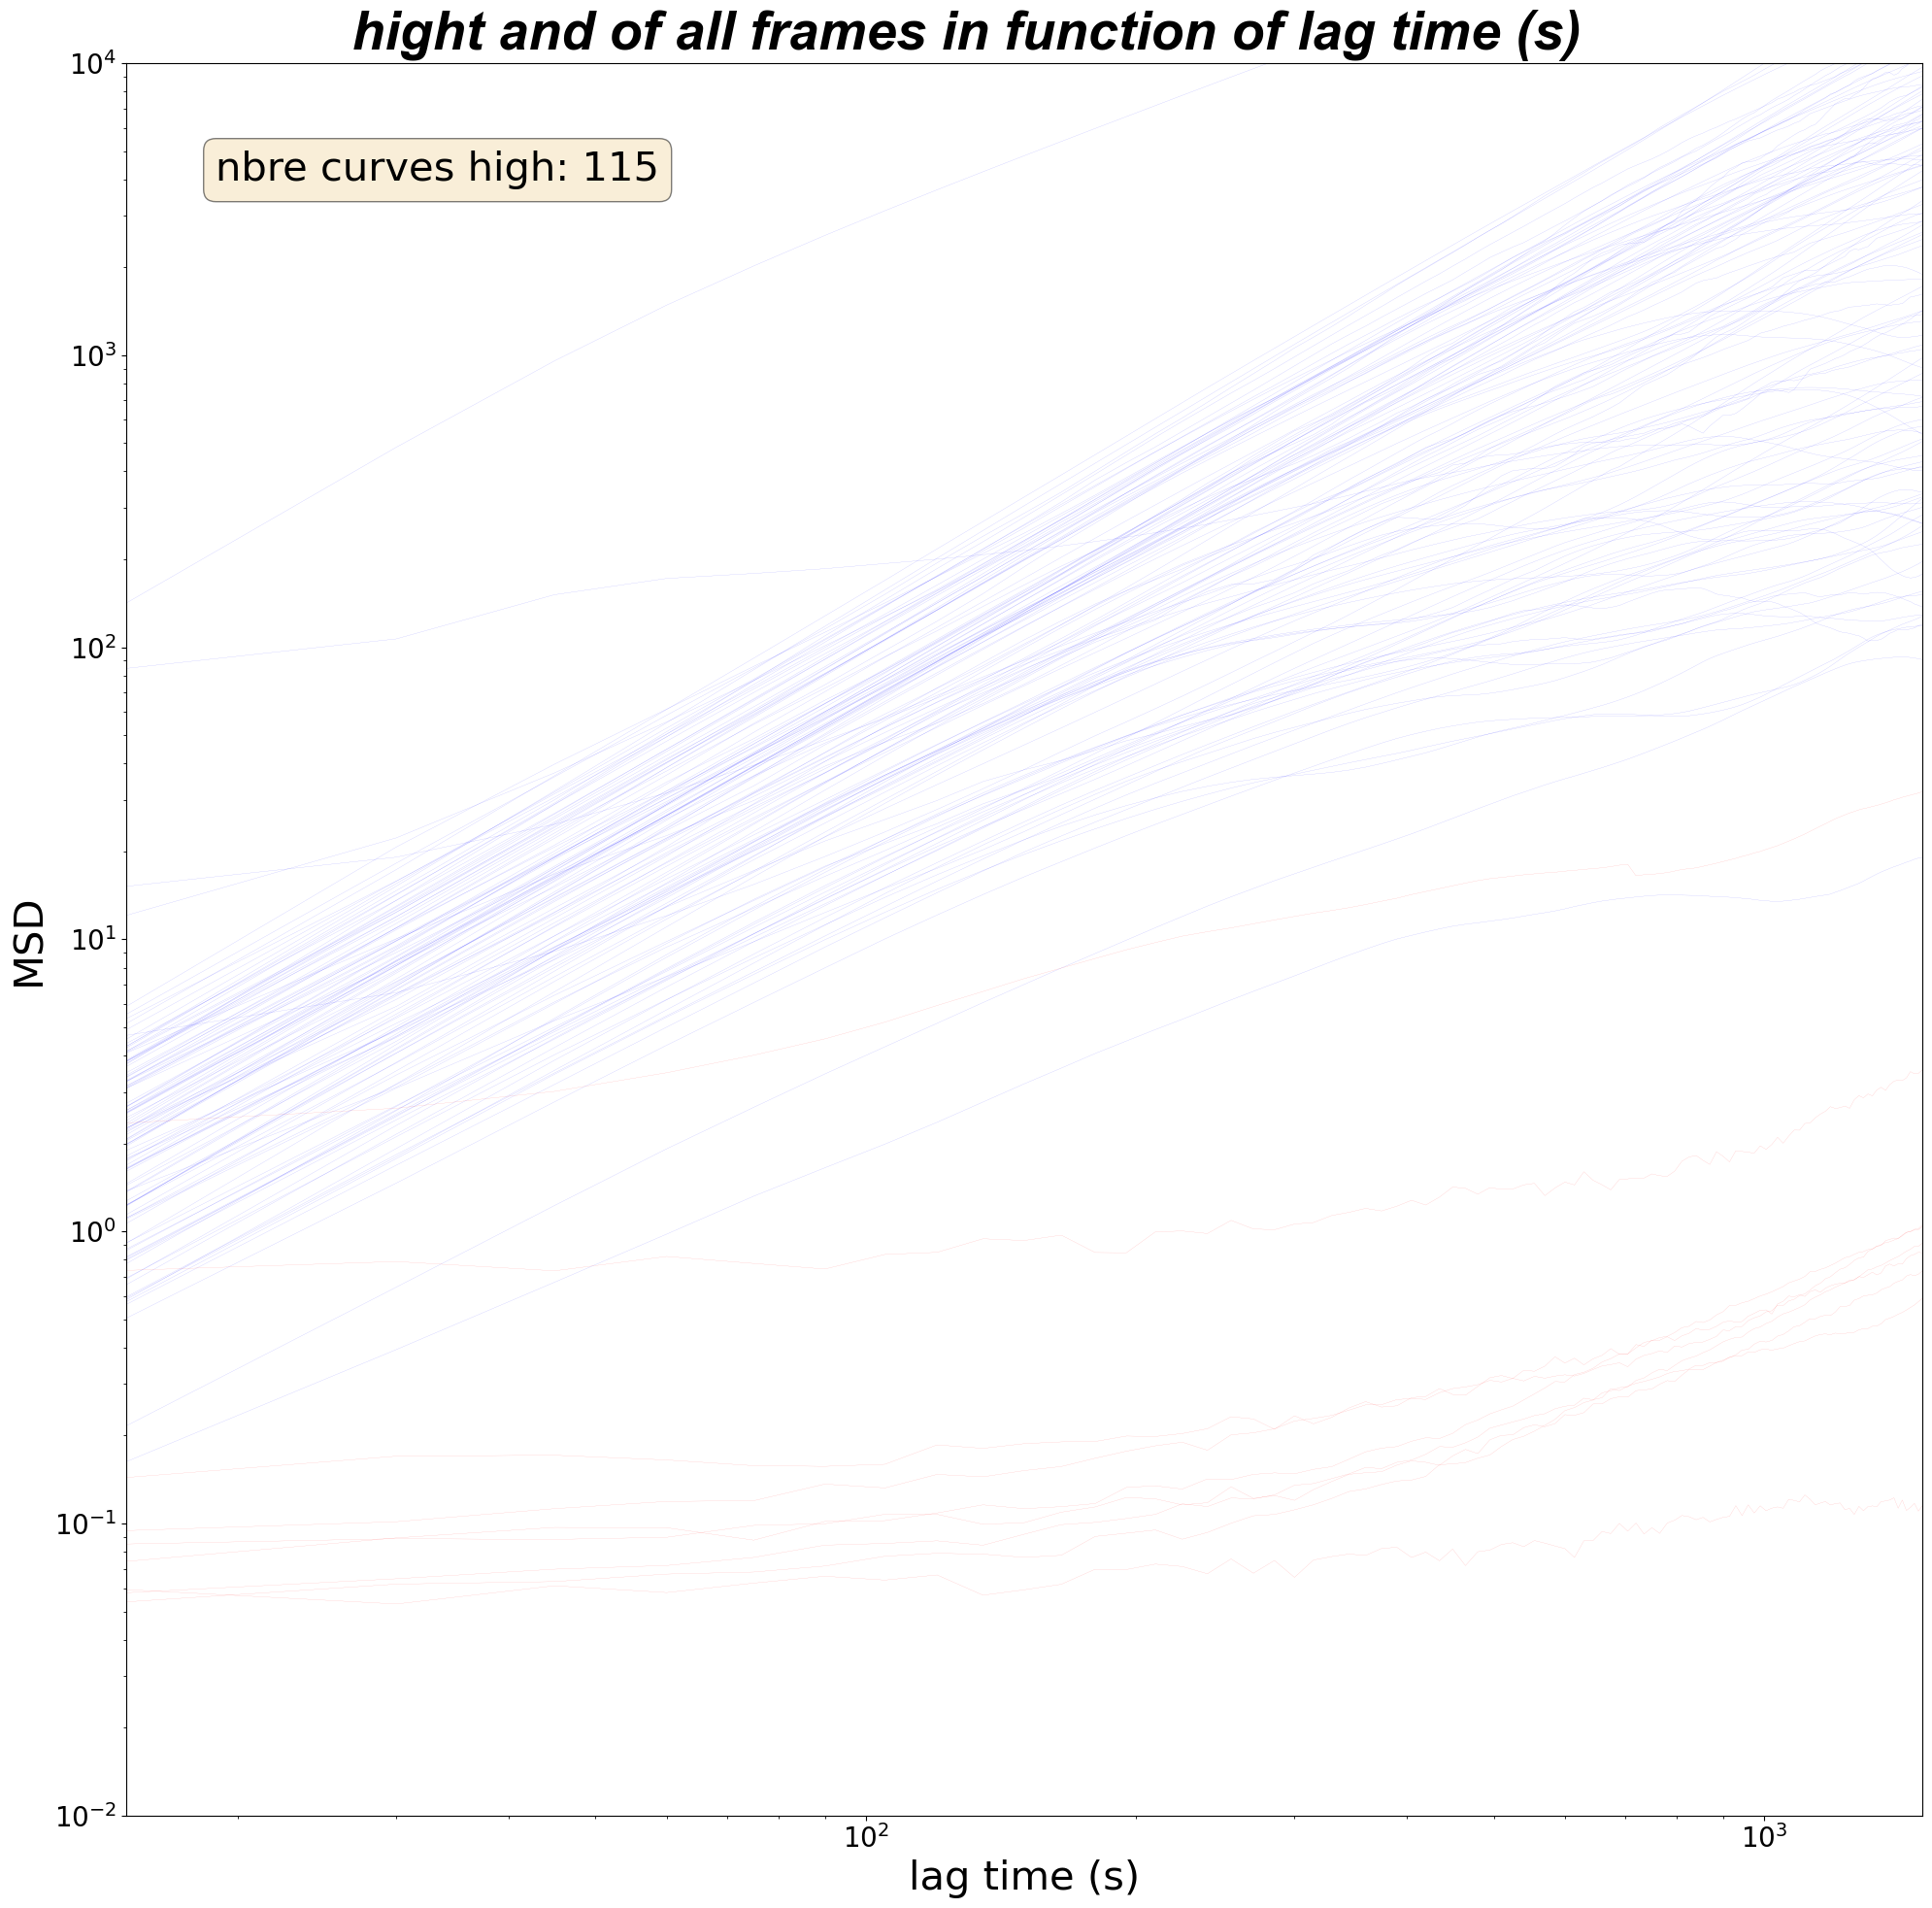

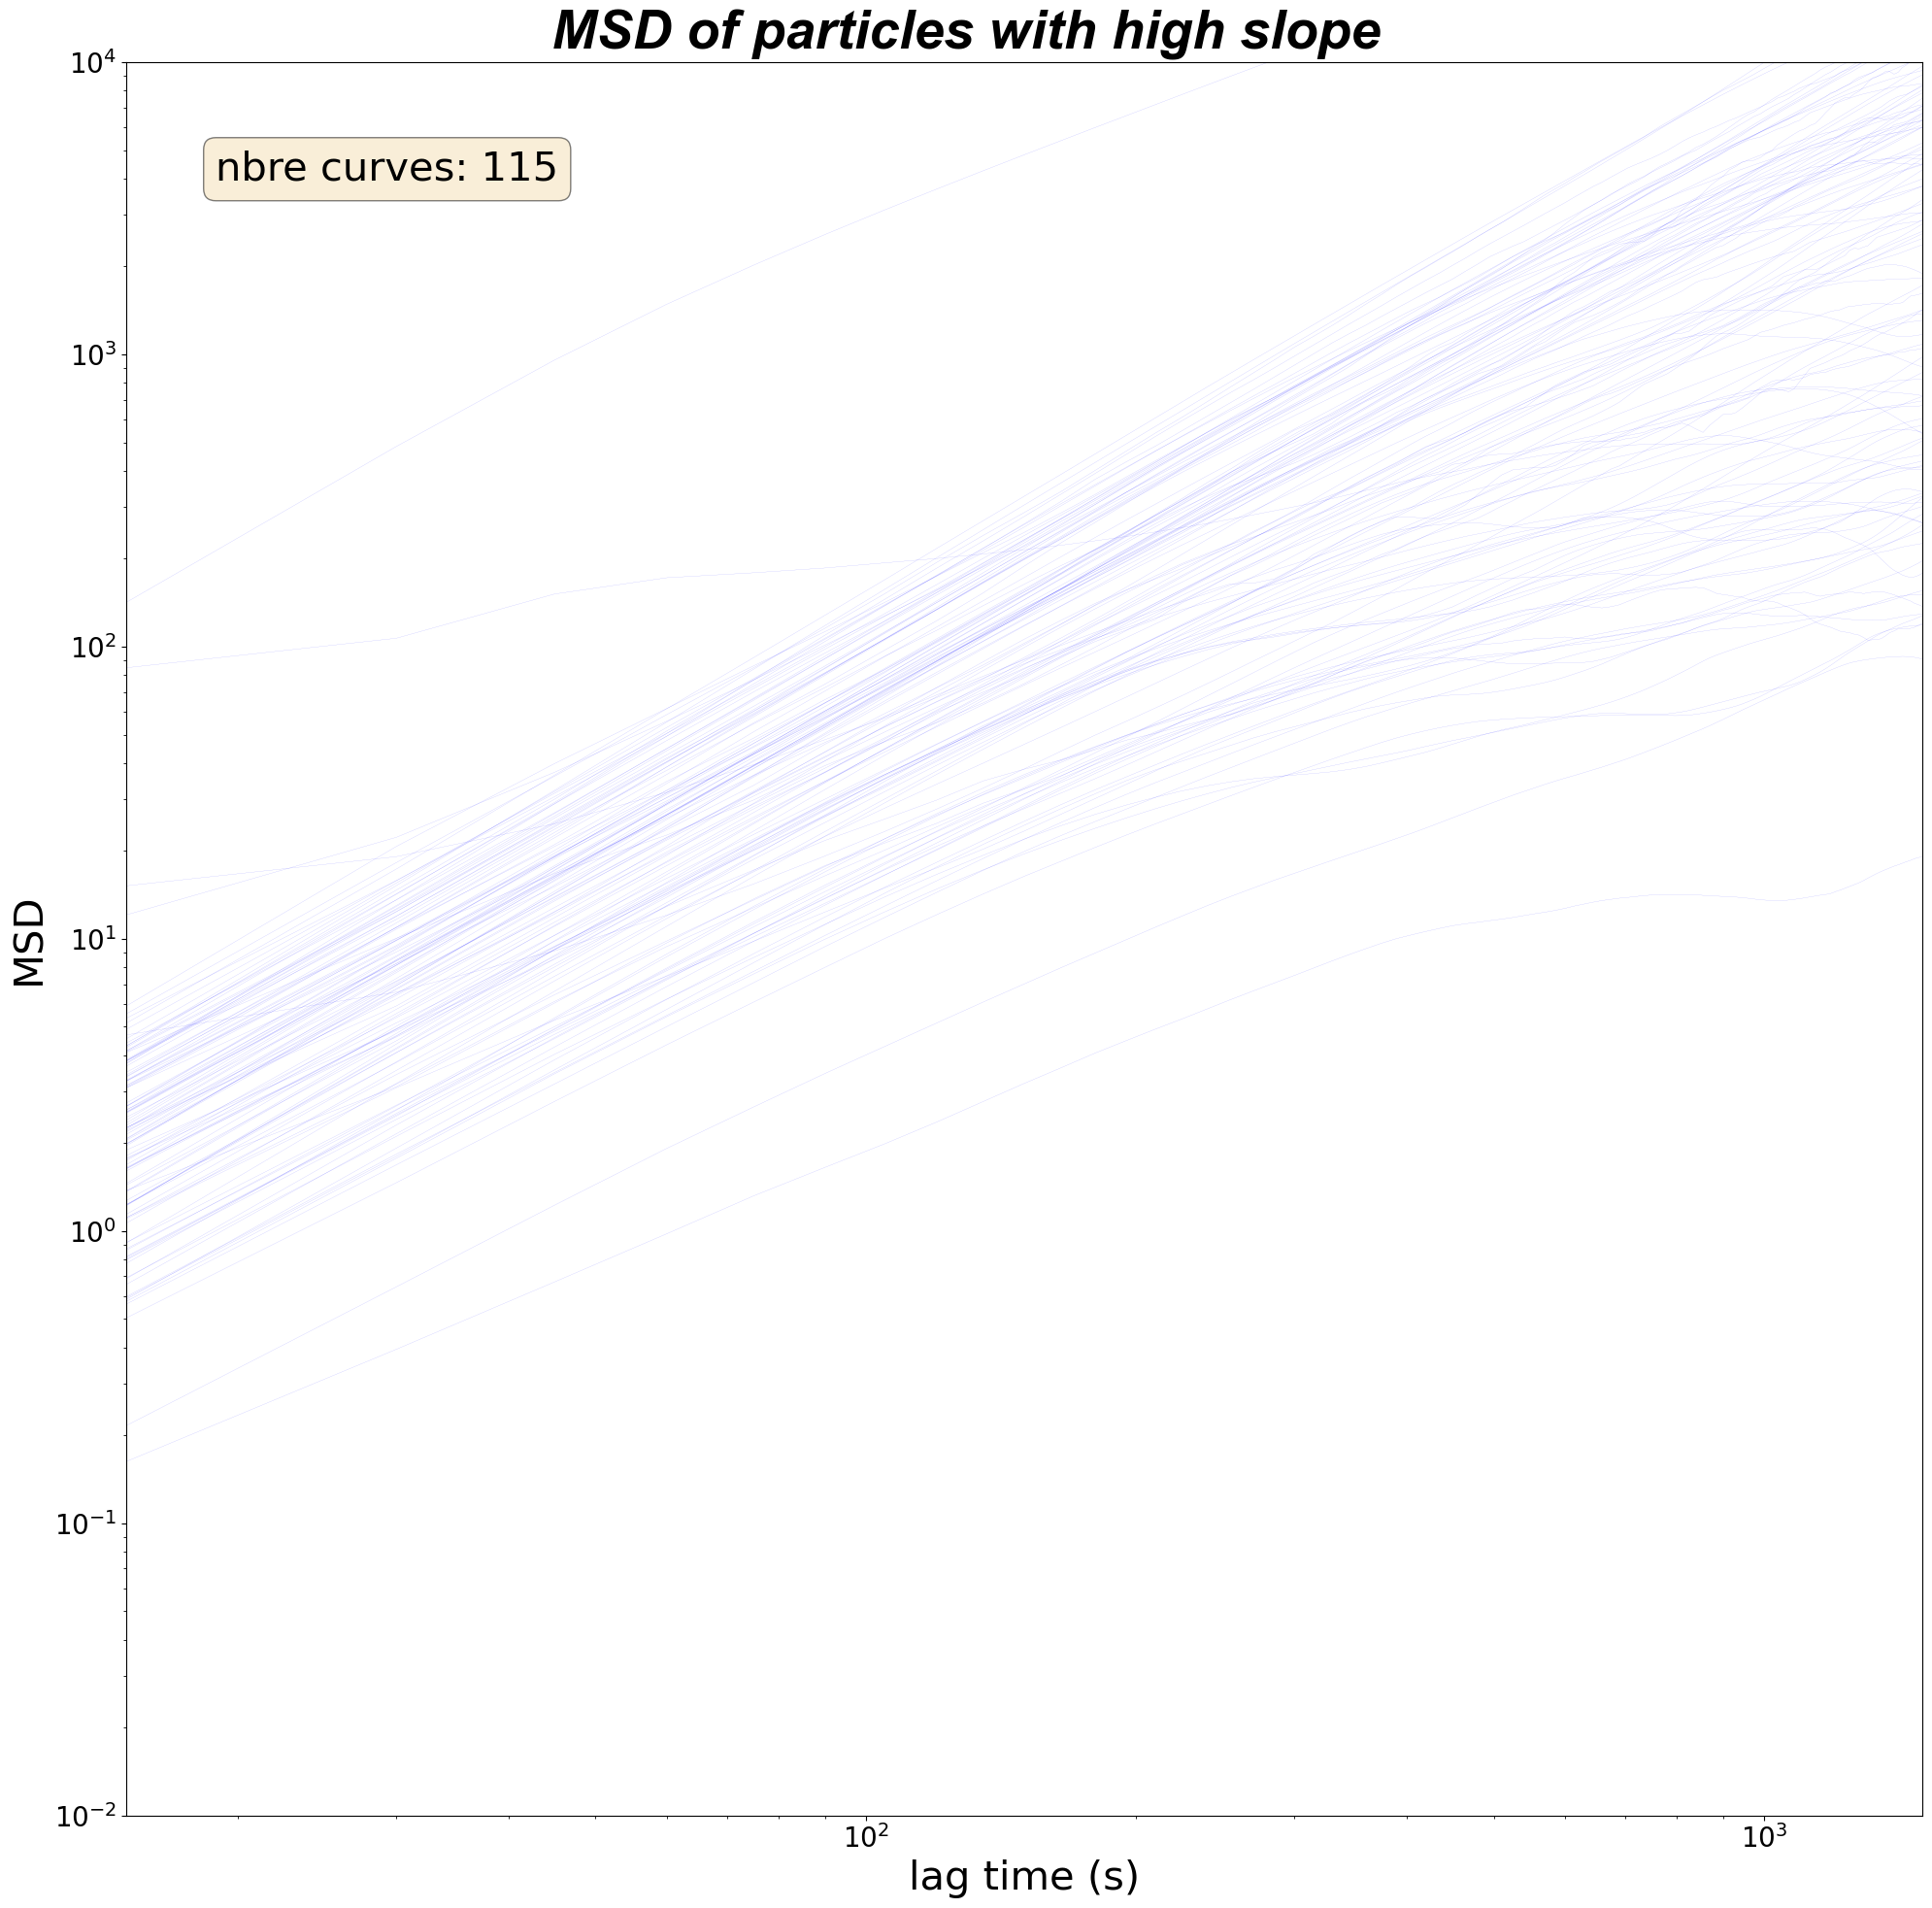

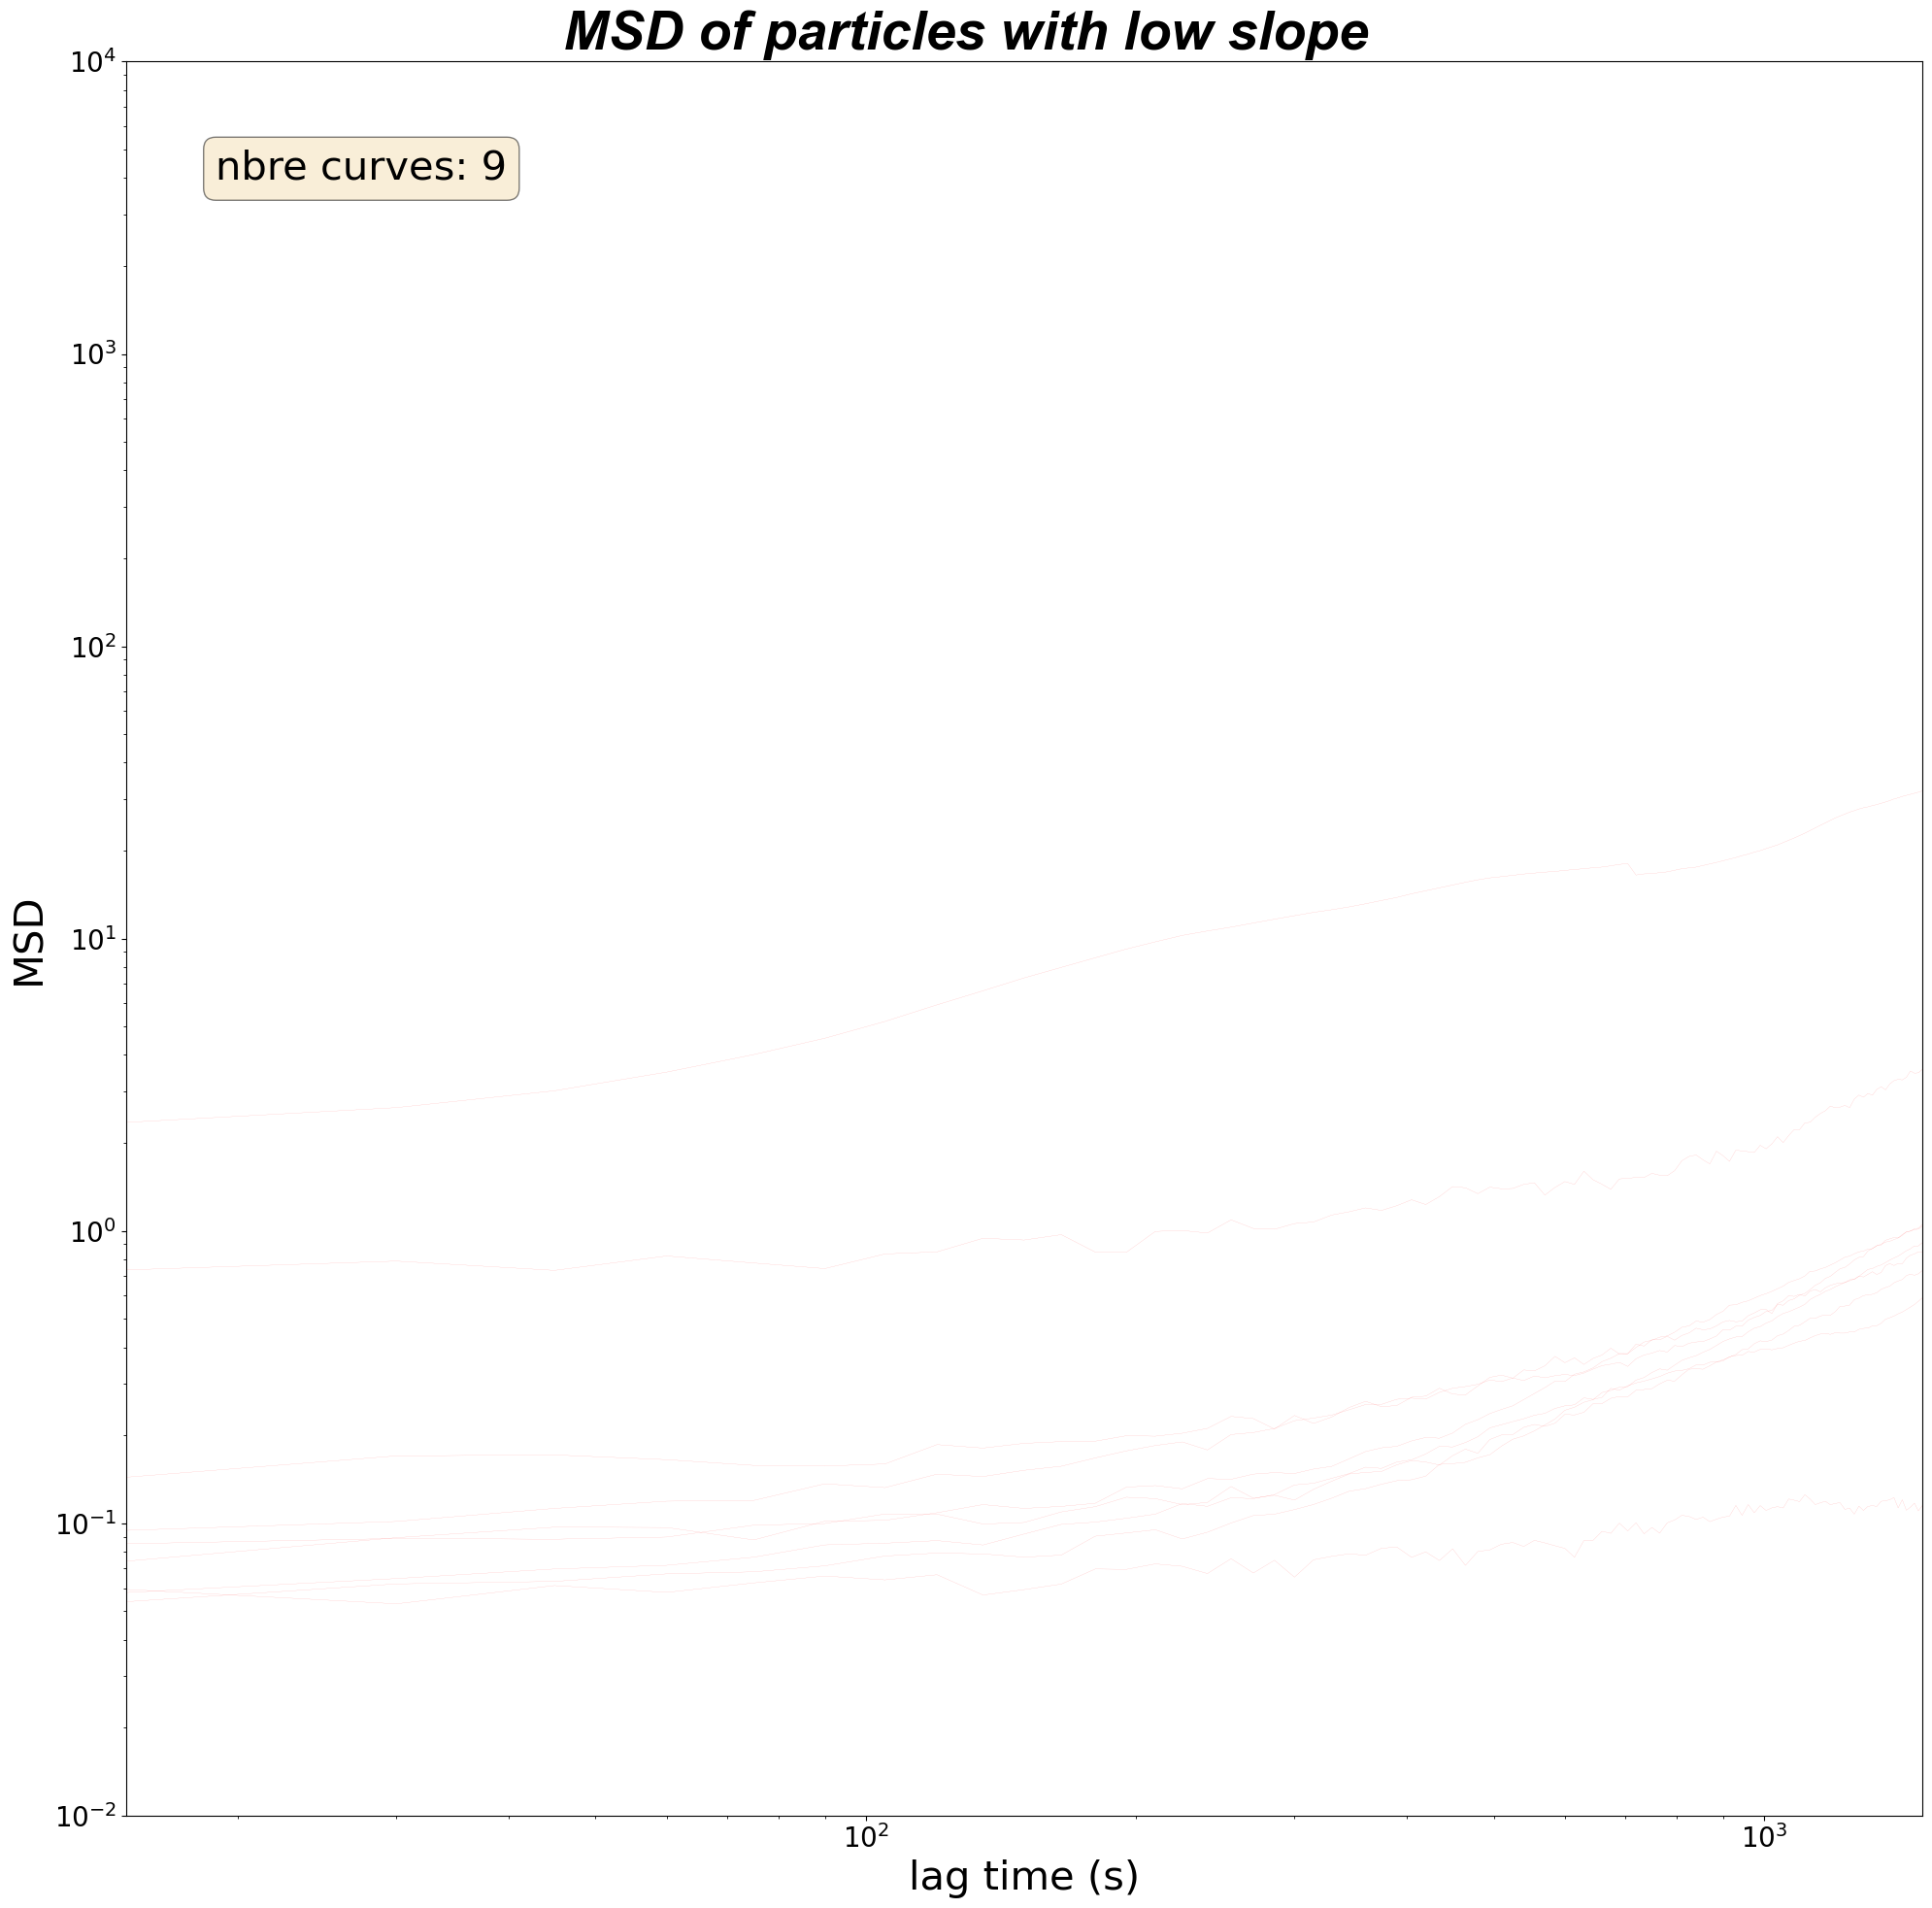

In [510]:
# In[plot MSD graph]
if len(DATA_INF) > 0 and len(DATA_SUP) > 0:
    lib.plot_msd_inf_sup(msd_inf=IMSD.loc[:, PART_COEF_INF], msd_sup=IMSD.loc[:, PART_COEF_SUP],
                         fps=FPS, name="hight and of all frames in function of lag time (s)",
                         save=True, pathway_saving=path_save_pic, alpha=ALPHA,
                         linewidth=LINEWIDTH, img_type='jpg', color_sup_inf=color_sup_inf)

if len(DATA_SUP) > 0:
    lib.plot_msd(msd=IMSD.loc[:, PART_COEF_SUP],
                 fps=FPS, name='MSD of particles with high slope', color_plot=color_sup_inf[0],
                 save=True, pathway_saving=path_save_pic, alpha=ALPHA, linewidth=LINEWIDTH)
if len(DATA_INF) > 0:
    lib.plot_msd(msd=IMSD.loc[:, PART_COEF_INF],
                 fps=FPS, name='MSD of particles with low slope', color_plot=color_sup_inf[1],
                 save=True, pathway_saving=path_save_pic, alpha=ALPHA, linewidth=LINEWIDTH)


In [511]:
# %% [Compute and plot the EMSD]

if len(DATA_INF) == 0:
    DATA_INF = pd.DataFrame()
# lib.plot_emsd(traj_inf=DATA_INF, traj_sup=DATA_SUP, size_pix=SIZE_PIX, color_sup_inf=color_sup_inf,
#               fps=FPS, max_lagtime=LAG_TIME_FIT, pathway_saving=path_save_pic)

if len(DATA_INF) > 0:
    bool_mask = IMSD_INF.iloc[0] > 3

    # Récupérer les noms de particules vérifiant la condition
    names = IMSD_INF.columns[bool_mask].tolist()

    bool_mask = DATA_INF['particle'].isin(names)

    # Récupérer les lignes correspondantes dans DATA_INF
    result = DATA_INF[bool_mask]
    if len(result) < 0:
        lib.plot_msd(msd=tp.imsd(traj=result, mpp=SIZE_PIX, fps=FPS), color_plot=color_sup_inf[1],
                     fps=FPS, name='MSD with low slope and sup at 10 at t0',
                     save=False, pathway_saving=path_save_pic, alpha=1, linewidth=0.5)


In [512]:
# %% [GIF]
# #############################################################################
# ################################## GIF ######################################
# ############################################################################
gif = False
if gif:
    import glob
    experiment = 'ASMOT035'
    condition = 'NonT_SorC'
    picture_path = f'/Users/souchaud/Desktop/{condition}/'
    # Utilisez glob pour rechercher les chemins correspondants
    matching_paths = glob.glob(f"{picture_path}*{experiment}*")

    # Affichez les chemins trouvés
    for path in matching_paths:
        print("Chemin trouvé :", path)

    lib.gif_and_traj(data=DATA, size_pix=SIZE_PIX, condition=condition,
                     experiment=experiment,
                     pathway_experiment=matching_paths[0] + '/mosaic/',
                     pathway_saving=f'/Users/souchaud/Desktop/Analyses/gif_{experiment}/',
                     dot_size=50)

In [513]:
import pandas as pd
import numpy as np

# Supposons que df est votre DataFrame contenant les résultats du tracking
# df devrait avoir des colonnes 'particle', 'frame', 'x', et 'y'
df = DATA
# Fonction pour calculer le vecteur de déplacement
def displacement_vectors(df):
    df['dx'] = df.groupby('particle')['x'].diff()
    df['dy'] = df.groupby('particle')['y'].diff()
    return df.dropna()

# Normaliser les vecteurs de déplacement
def normalize_vectors(df):
    df = df.copy()
    magnitude = np.sqrt(df['dx']**2 + df['dy']**2)
    df.loc[:, 'dx_norm'] = df['dx'] / magnitude
    df.loc[:, 'dy_norm'] = df['dy'] / magnitude
    return df

# Calculer l'angle des vecteurs
# Arctan2 permet de calculer l'angle en radians entre la partie positive de l'axe des abscisses d'un plan et le point (x,y)
# Angle positif dans le sens trigo et négativ dans le sens inverse trigo
def calculate_angles(df):
    df = df.copy()
    df.loc[:, 'angle'] = np.arctan2(df['dy_norm'], df['dx_norm'])
    return df

# Calculer l'autocorrélation directionnelle
def direction_autocorrelation(df, max_lag):
    results = []
    for particle in df['particle'].unique():
        particle_df = df[df['particle'] == particle].copy()
        for lag in range(1, max_lag + 1):
            particle_df['angle_lag'] = particle_df['angle'].shift(-lag)
            cos_diff = np.cos(particle_df['angle'] - particle_df['angle_lag'])
            autocorr = cos_diff.mean()
            results.append({'particle': particle, 'lag': lag, 'autocorrelation': autocorr})
    return pd.DataFrame(results).dropna()

# Appliquer les fonctions
df = displacement_vectors(df)
df = normalize_vectors(df)
df = calculate_angles(df)
max_lag = 10  # Ajustez en fonction de la longueur de vos trajectoires
autocorr_df = direction_autocorrelation(df, max_lag)

# Vous pouvez maintenant analyser autocorr_df pour comprendre la persistance directionnelle


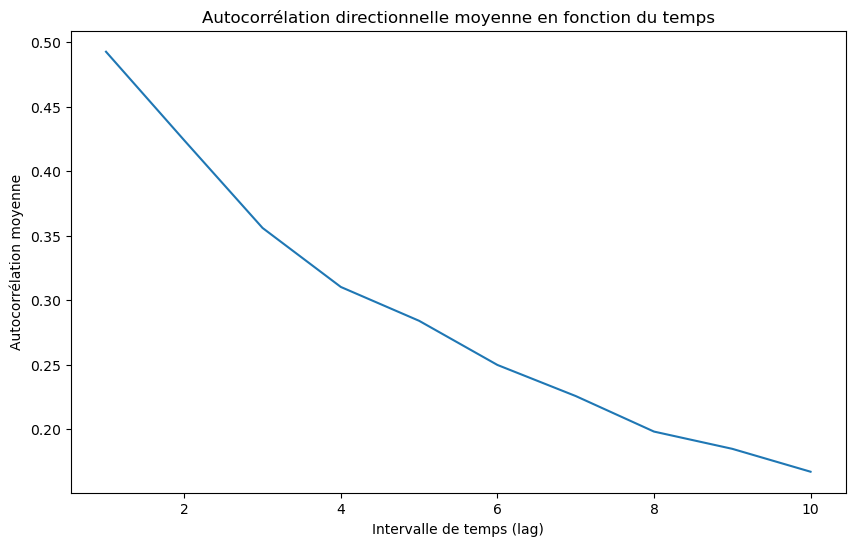

In [514]:
# Supposons que autocorr_df est votre DataFrame contenant les résultats d'autocorrélation

# Calculer la moyenne de l'autocorrélation pour chaque intervalle de temps
mean_autocorr = autocorr_df.groupby('lag')['autocorrelation'].mean()

# Tracer la courbe d'autocorrélation
plt.figure(figsize=(10, 6))
mean_autocorr.plot(kind='line')
plt.xlabel('Intervalle de temps (lag)')
plt.ylabel('Autocorrélation moyenne')
plt.title('Autocorrélation directionnelle moyenne en fonction du temps')
plt.savefig(path_save_pic + f"Autocorrélation directionnelle moyenne en fonction lagtime {CONDITION_simple}.png", format='png')
plt.show()

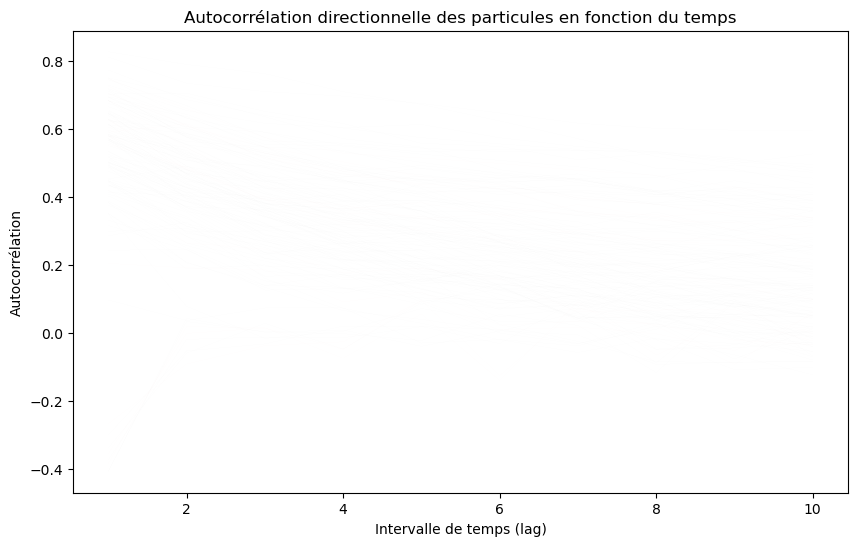

In [515]:
import matplotlib.pyplot as plt

# Supposons que autocorr_df est votre DataFrame contenant les résultats d'autocorrélation

# Obtenir la liste des particules uniques
particles = autocorr_df['particle'].unique()

plt.figure(figsize=(10, 6))

for particle in particles:
    particle_data = autocorr_df[autocorr_df['particle'] == particle]
    plt.plot(particle_data['lag'], particle_data['autocorrelation'], linewidth=0.01, alpha=0.2)

plt.xlabel('Intervalle de temps (lag)')
plt.ylabel('Autocorrélation')
plt.title('Autocorrélation directionnelle des particules en fonction du temps')
# plt.legend()  # Commentez ou supprimez si la légende est trop encombrée
plt.savefig(path_save_pic + f"Autocorrélation directionnelle particules en fonction lagtime {CONDITION_simple}.png", format='png')
plt.show()


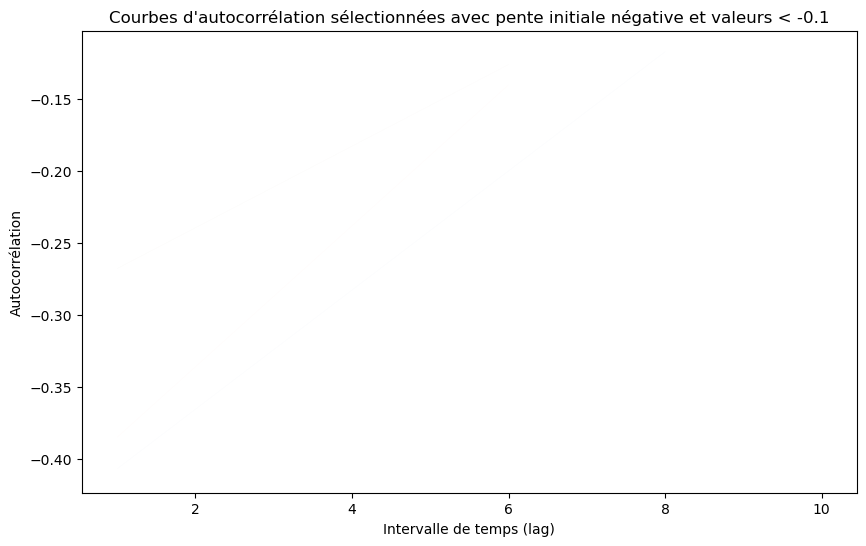

In [516]:
# Assurez-vous que chaque groupe a au moins deux observations avant de calculer la pente
def calculate_slope(x):
    if len(x) > 1:  # Vérifiez si le groupe a au moins 2 lignes
        return (x.autocorrelation.iloc[1] - x.autocorrelation.iloc[0]) / (x.lag.iloc[1] - x.lag.iloc[0])
    else:
        return np.nan  # Retourner NaN si seulement une ligne pour éviter l'erreur

slopes = autocorr_df.groupby('particle').apply(calculate_slope)

# Filtrer les pentes négatives et non-NaN
particles_of_interest = slopes[slopes > 0].dropna().index
autocorr_of_interest = autocorr_df[autocorr_df['particle'].isin(particles_of_interest)]

# Filtrer encore pour les valeurs inférieures à -0.1
autocorr_of_interest = autocorr_of_interest[autocorr_of_interest['autocorrelation'] < -0.1]

# Tracer les courbes d'autocorrélation sélectionnées
plt.figure(figsize=(10, 6))
for particle in autocorr_of_interest['particle'].unique():
    particle_data = autocorr_of_interest[autocorr_of_interest['particle'] == particle]
    plt.plot(particle_data['lag'], particle_data['autocorrelation'], label=f'Particule {particle}', linewidth=0.01, alpha=0.5)

plt.xlabel('Intervalle de temps (lag)')
plt.ylabel('Autocorrélation')
plt.title('Courbes d\'autocorrélation sélectionnées avec pente initiale négative et valeurs < -0.1')
# Peut-être enlever la légende si trop de courbes
# plt.legend()
plt.savefig(path_save_pic + f"Autocorrélation directionnelle particules lentes en fonction lagtime {CONDITION_simple}.png", format='png')
plt.show()


In [517]:
# Supposons que `df`=DATA est votre DataFrame principal contenant toutes les données de particules
# et que `autocorr_of_interest` est le DataFrame avec les particules que vous voulez exclure
# particles_to_exclude étant les cellules avec un pente positive et une valeur à 0 negative.

# Obtenir la liste unique des identifiants de particules à exclure
particles_to_exclude = autocorr_of_interest['particle'].unique()

# Filtrer le DataFrame principal pour exclure ces particules
df_autocor_positive = df[~df['particle'].isin(particles_to_exclude)]
df_autocor_negative = df[df['particle'].isin(particles_to_exclude)]

# Maintenant, `df_filtered` contient toutes les données sauf celles des particules que vous vouliez exclure


In [518]:
# %% [MSD computation]
IMSD_pos = tp.imsd(traj=df_autocor_positive[df_autocor_positive['frame'] < 240],
               mpp=SIZE_PIX, fps=FPS,
               max_lagtime=200, statistic='msd',
               pos_columns=None)
IMSD_neg = tp.imsd(traj=df_autocor_negative[df_autocor_negative['frame'] < 240],
               mpp=SIZE_PIX, fps=FPS,
               max_lagtime=200, statistic='msd',
               pos_columns=None)

# negative slope 0


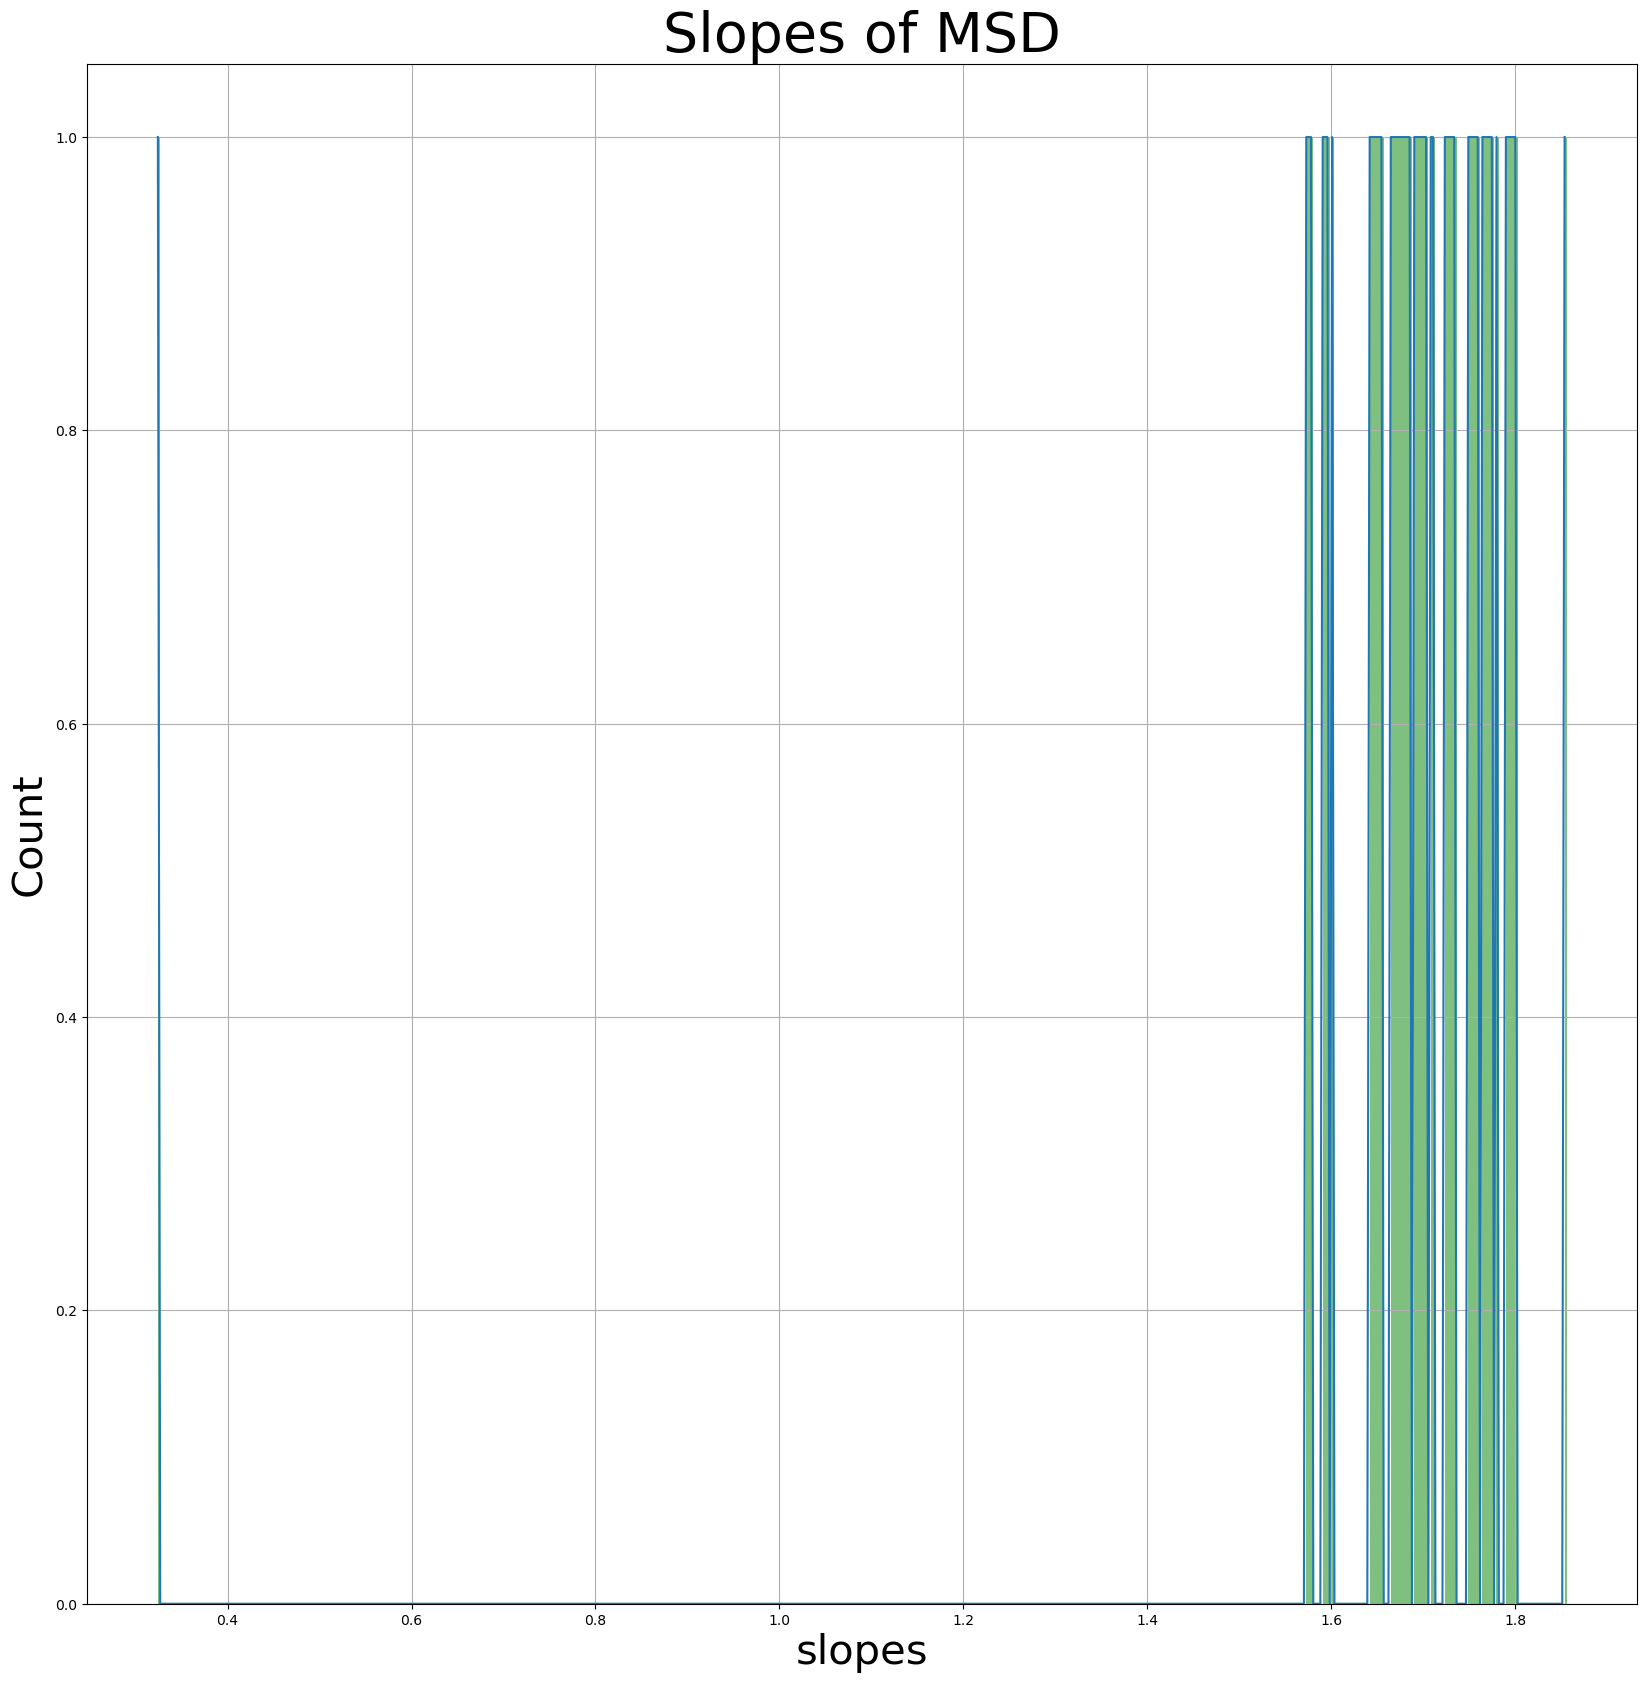

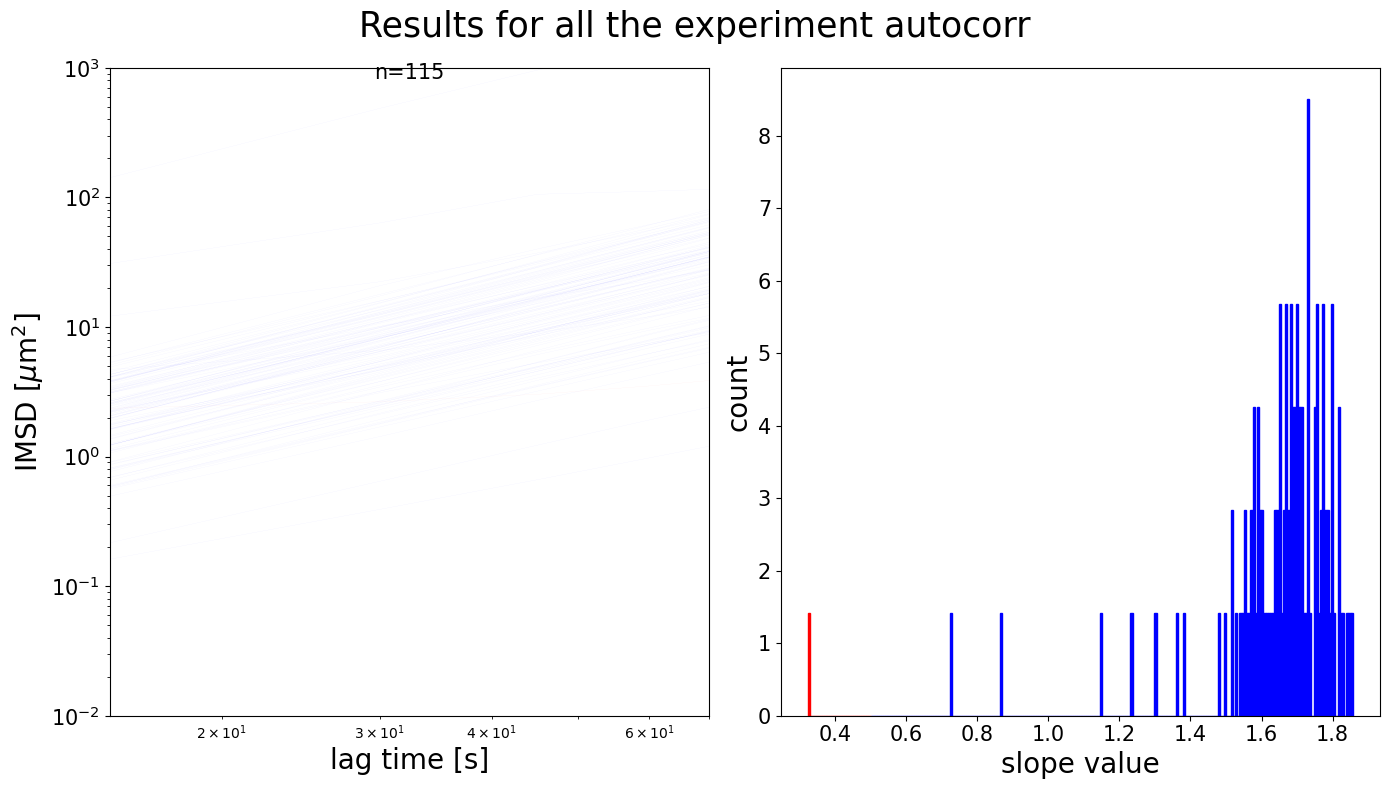

In [519]:
# %% [traj clustering with fit and defining a cutoff]
LAG_TIME_FIT = 5
# Compute et plot the director factor of the imsd

COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF =\
    lib.traj_clustering_with_fit_cutoff(df_autocor_positive[df_autocor_positive['frame'] < 240], imsd=IMSD_pos, hist=True,
                                        lag_time_fit=LAG_TIME_FIT,
                                        micronperpixel=SIZE_PIX,
                                        fps=FPS, binsize=600,
                                        peak_height=50, peak_width=1,
                                        save=True, pathway_fig=path_save_pic,
                                        name='all the experiment autocorr', img_type="jpg",
                                        plot=True, color_sup_inf=color_sup_inf,
                                        cutoff_default=0.5
                                        )

# # DATA_INF, DATA_SUP, IMSD_INF, IMSD_SUP,
# DATA_INF = DATA[DATA['particle'].isin(PART_COEF_INF)]
# DATA_SUP = DATA[DATA['particle'].isin(PART_COEF_SUP)]
# IMSD_INF = IMSD.loc[:, IMSD.columns.isin(PART_COEF_INF)]
# IMSD_SUP = IMSD.loc[:, IMSD.columns.isin(PART_COEF_SUP)]

In [520]:
# Réinitialiser les index des deux DataFrames et s'assurer qu'ils ont la même longueur
df_autocor_negative

level_0            y            x         mass       size       ecc  \
1681      1681  5109.162599  6277.237745  5358.393125  12.580613  0.000665   
1682      1682  5109.252609  6277.537519  4752.639870  12.405384  0.006641   
1683      1683  5109.225950  6277.445910  4740.494701  12.424967  0.002225   
1684      1684  5109.246481  6277.563070  6154.195143  13.520827  0.001041   
1685      1685  5109.102770  6277.612490  4845.904857  12.357305  0.002928   
...        ...          ...          ...          ...        ...       ...   
22940    22940   754.926874   849.906759  4040.379564   9.416823  0.058989   
22941    22941   754.823756   850.076649  3970.000174   9.329862  0.056781   
22942    22942   754.824133   849.256543  3988.687445   9.361631  0.064231   
22943    22943   754.820664   849.879518  4005.416819   9.371738  0.053442   
22944    22944   754.838243   849.296818  4010.017052   9.403244  0.058070   

         signal  raw_mass        ep  frame  ...  displacement [pix]  \
1681   7.615727   19237.0  0.092843      1  ...            0.197004   
1682   7.108903   18212.0  0.051382      2  ...            0.312995   
1683   6.967729   18175.0  0.006014      3  ...            0.095409   
1684   7.823938   17716.0  0.009858      4  ...            0.118945   
1685   7.173804   18443.0  0.149311      5  ...            0.151971   
...         ...       ...       ...    ...  ...                 ...   
22940  9.008376  273827.0  1.630876    235  ...            0.368107   
22941  9.002820  273864.0  1.629679    236  ...            0.198736   
22942  9.113268  273469.0  1.649584    237  ...            0.820106   
22943  9.038228  273859.0  1.630678    238  ...            0.622985   
22944  9.038908  273569.0  1.642989    239  ...            0.582965   

       VitInst [um/min]  Xc [pix]  Yc [pix] cumulative displacement [um]  \
1681           0.501967  0.109839 -0.163542                     0.125492   
1682           0.797512  0.409613 -0.073533                     0.324870   
1683           0.243102  0.318004 -0.100192                     0.385645   
1684           0.303071  0.435164 -0.079661                     0.461413   
1685           0.387222  0.484584 -0.223372                     0.558218   
...                 ...       ...       ...                          ...   
22940          0.937937 -0.193379 -1.231812                    48.246330   
22941          0.506378 -0.023490 -1.334931                    48.372925   
22942          2.089630 -0.843596 -1.334553                    48.895332   
22943          1.587365 -0.220621 -1.338023                    49.292173   
22944          1.485394 -0.803321 -1.320443                    49.663522   

             dx        dy   dx_norm   dy_norm     angle  
1681   0.109839 -0.163542  0.557547 -0.830145 -0.979368  
1682   0.299774  0.090009  0.957758  0.287574  0.291693  
1683  -0.091609 -0.026659 -0.960170 -0.279416 -2.858407  
1684   0.117160  0.020531  0.984991  0.172607  0.173476  
1685   0.049420 -0.143711  0.325194 -0.945647 -1.239579  
...         ...       ...       ...       ...       ...  
22940  0.349246  0.116319  0.948762  0.315992  0.321502  
22941  0.169889 -0.103119  0.854851 -0.518874 -0.545533  
22942 -0.820106  0.000377 -1.000000  0.000460  3.141133  
22943  0.622975 -0.003469  0.999984 -0.005569 -0.005569  
22944 -0.582700  0.017580 -0.999545  0.030156  3.111432  

[2121 rows x 29 columns]

# negative slope 0


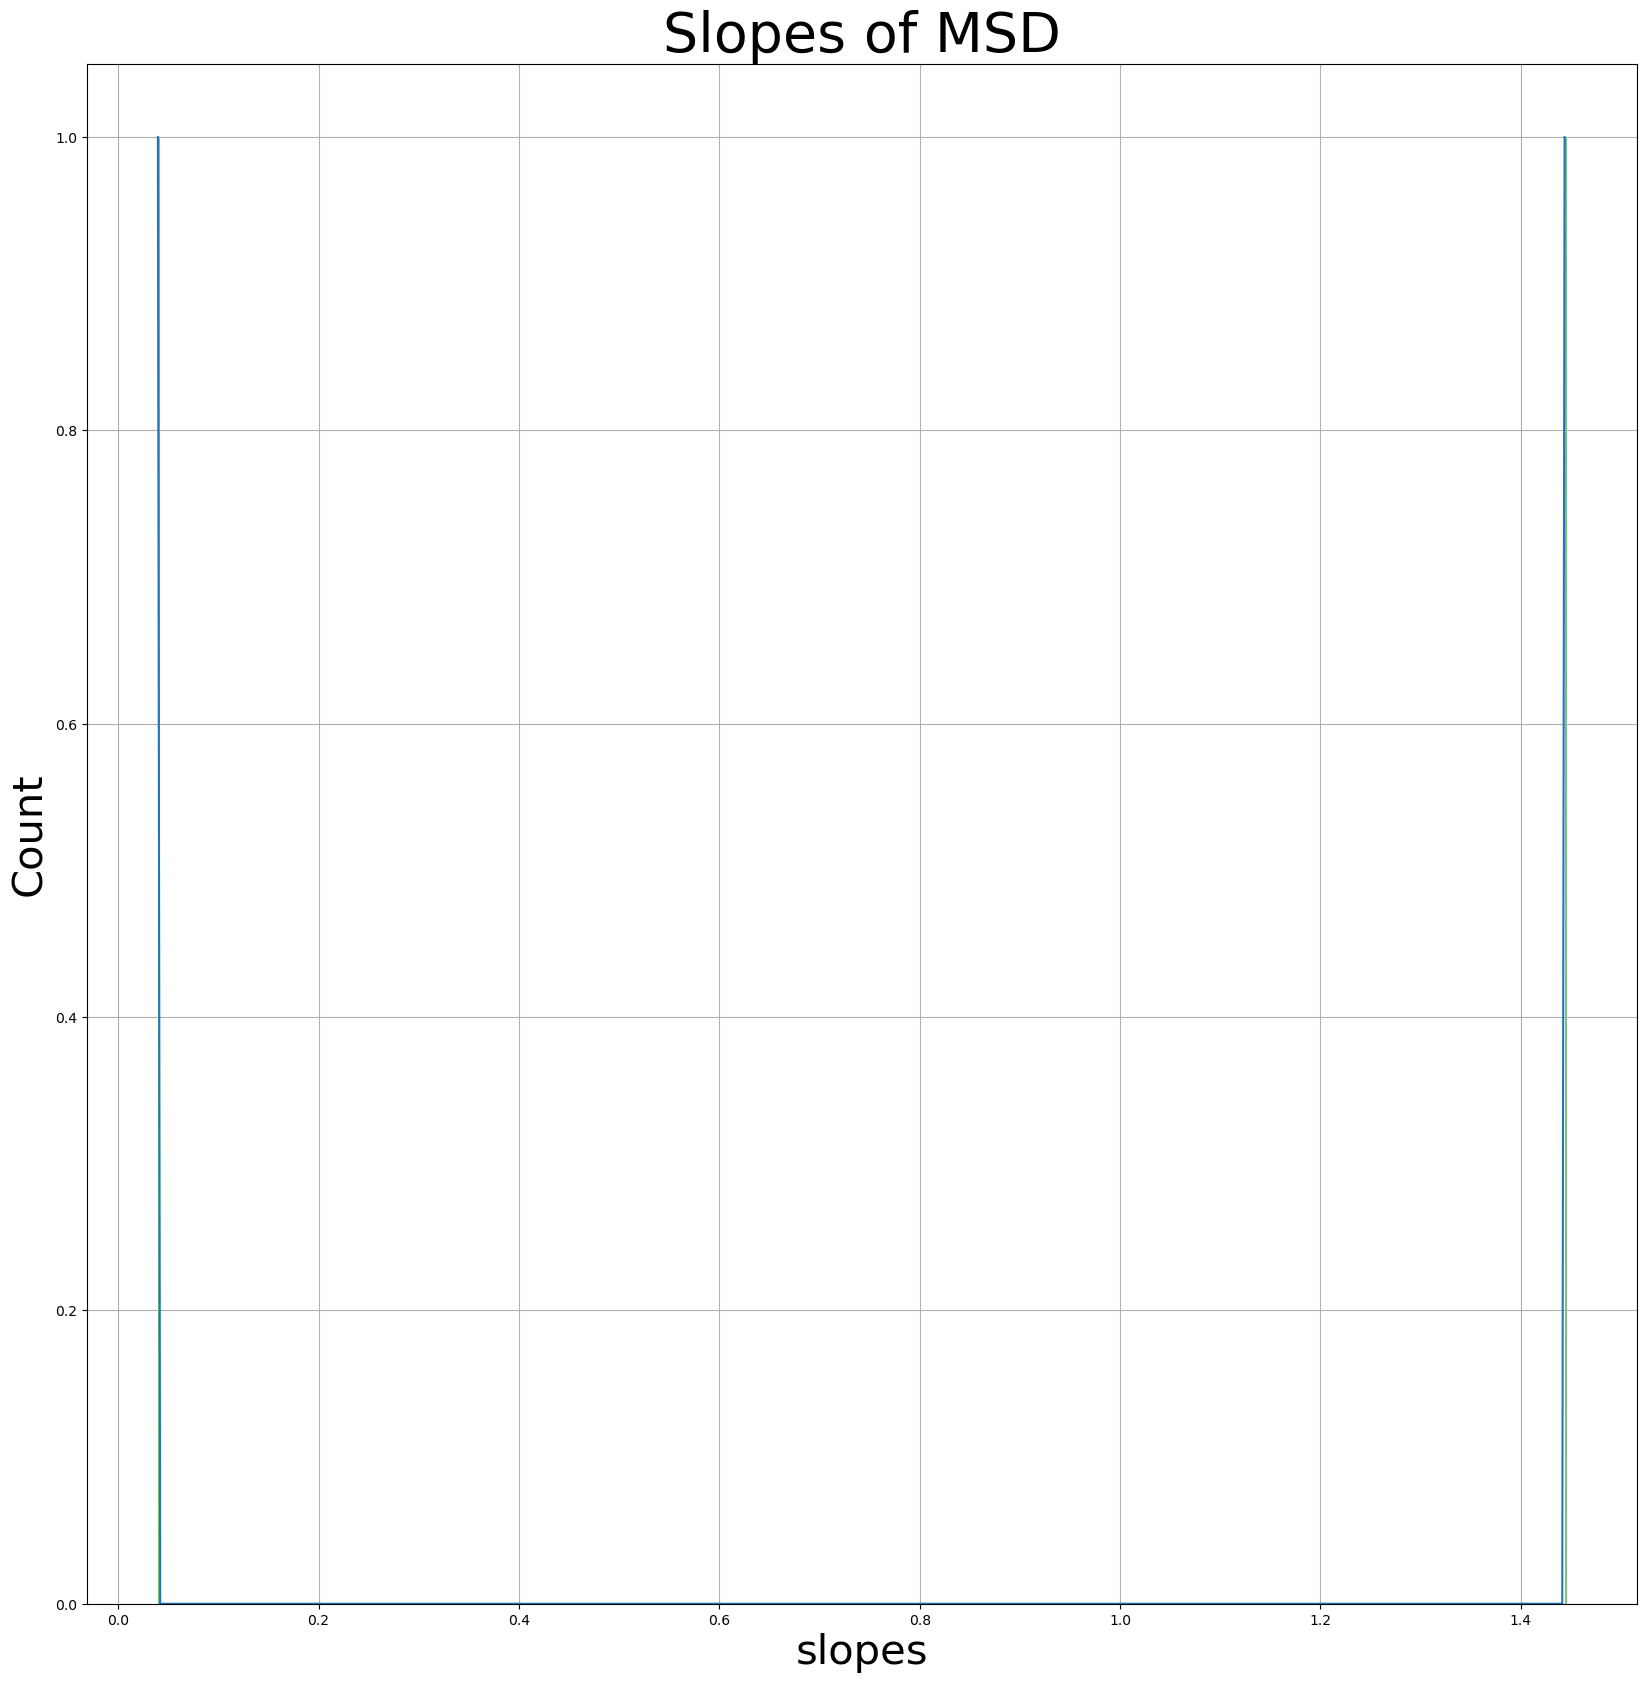

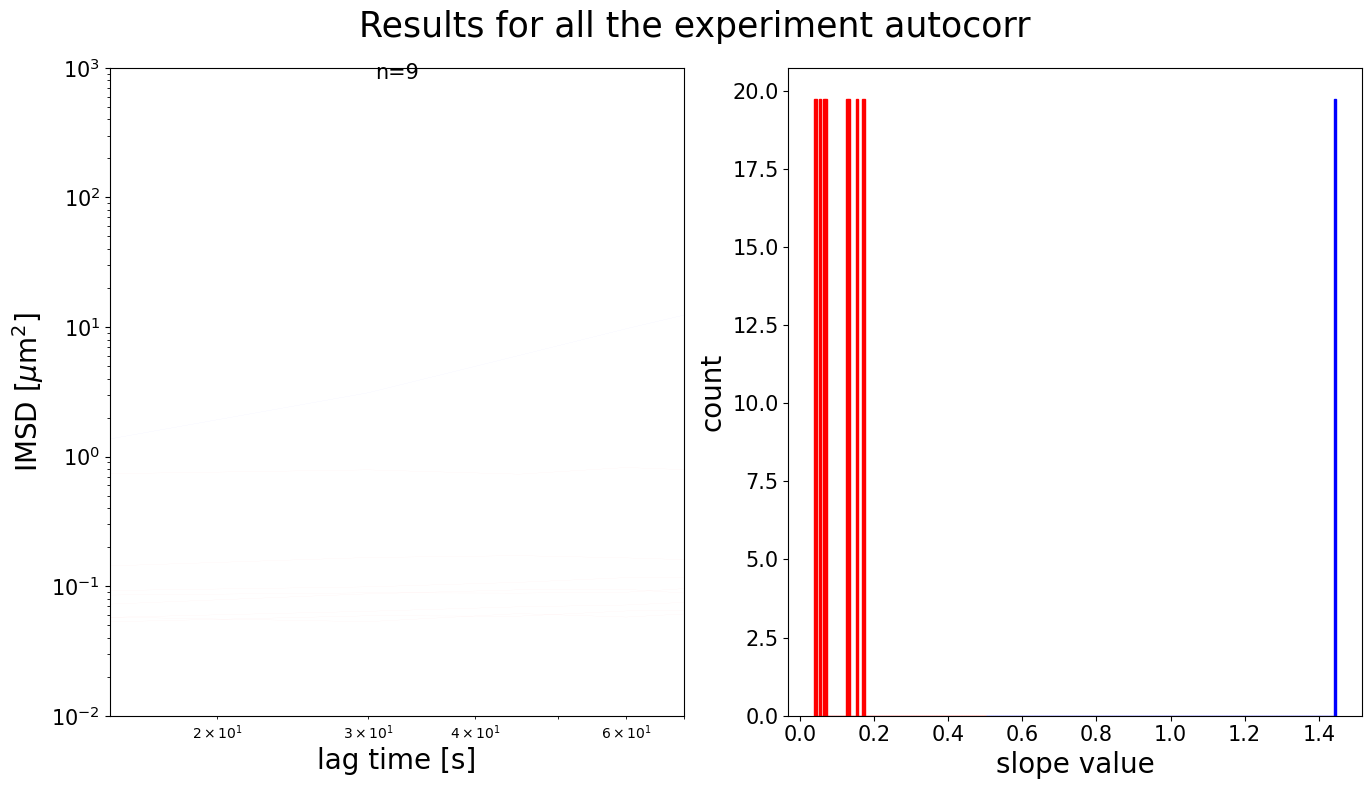

In [521]:
# %% [traj clustering with fit and defining a cutoff]
LAG_TIME_FIT = 5
# Compute et plot the director factor of the imsd

COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF =\
    lib.traj_clustering_with_fit_cutoff(df_autocor_negative[df_autocor_negative['frame'] < 240], imsd=IMSD_neg, hist=True,
                                        lag_time_fit=LAG_TIME_FIT,
                                        micronperpixel=SIZE_PIX,
                                        fps=FPS, binsize=600,
                                        peak_height=50, peak_width=1,
                                        save=True, pathway_fig=path_save_pic,
                                        name='all the experiment autocorr', img_type="jpg",
                                        plot=True, color_sup_inf=color_sup_inf,
                                        cutoff_default=0.5
                                        )

# # DATA_INF, DATA_SUP, IMSD_INF, IMSD_SUP,
# DATA_INF = DATA[DATA['particle'].isin(PART_COEF_INF)]
# DATA_SUP = DATA[DATA['particle'].isin(PART_COEF_SUP)]
# IMSD_INF = IMSD.loc[:, IMSD.columns.isin(PART_COEF_INF)]
# IMSD_SUP = IMSD.loc[:, IMSD.columns.isin(PART_COEF_SUP)]

In [522]:
# for numero_particule in df_negative['particle'].unique():
#     print(numero_particule)
#     print("Etude de la particule : ", numero_particule, ' dans la manip', DATA[DATA['particle']==numero_particule]['experiment'].iloc[0])
#     lib.create_cropped_tracking_gif(datas=DATA, target_particle = numero_particule,
#                                     condition = CONDITION_simple,
#                                     dot_size= 7,
#                                     crop_size=100, 
#                                     gif=False,
#                                     pathway_saving=None,
                                    # pathway_initial='/Volumes/Labo_Alex_Mac/A_analyser/')

In [523]:
# Étape 1: Calculer la masse moyenne pour chaque particule dans chaque expérience
mass_means_neg = df_autocor_negative.groupby(['particle', 'experiment'])['mass'].mean().reset_index(name='mean_mass')
mass_means_pos = df_autocor_positive.groupby(['particle', 'experiment'])['mass'].mean().reset_index(name='mean_mass')

# Étape 2: Calculer la moyenne des moyennes pour chaque expérience
experiment_mass_means_neg = mass_means_neg.groupby('experiment')['mean_mass'].mean()
experiment_mass_means_pos = mass_means_pos.groupby('experiment')['mean_mass'].mean()

In [524]:
import pandas as pd

# Supposons que df_autocor_negative est votre DataFrame
# Calculer la masse moyenne pour chaque particule dans chaque expérience
mass_means_per_particle_neg = df_autocor_negative.groupby(['particle', 'experiment'])['mass'].mean().reset_index()
mass_means_per_particle_pos = df_autocor_positive.groupby(['particle', 'experiment'])['mass'].mean().reset_index()

# Calculer la moyenne des moyennes de la masse pour chaque expérience
mean_of_mass_means_per_experiment_neg = mass_means_per_particle_neg.groupby('experiment')['mass'].mean()
mean_of_mass_means_per_experiment_pos = mass_means_per_particle_pos.groupby('experiment')['mass'].mean()

# Afficher la moyenne des moyennes pour chaque expérience
# print(mean_of_mass_means_per_experiment_neg)
# print(mean_of_mass_means_per_experiment_pos)



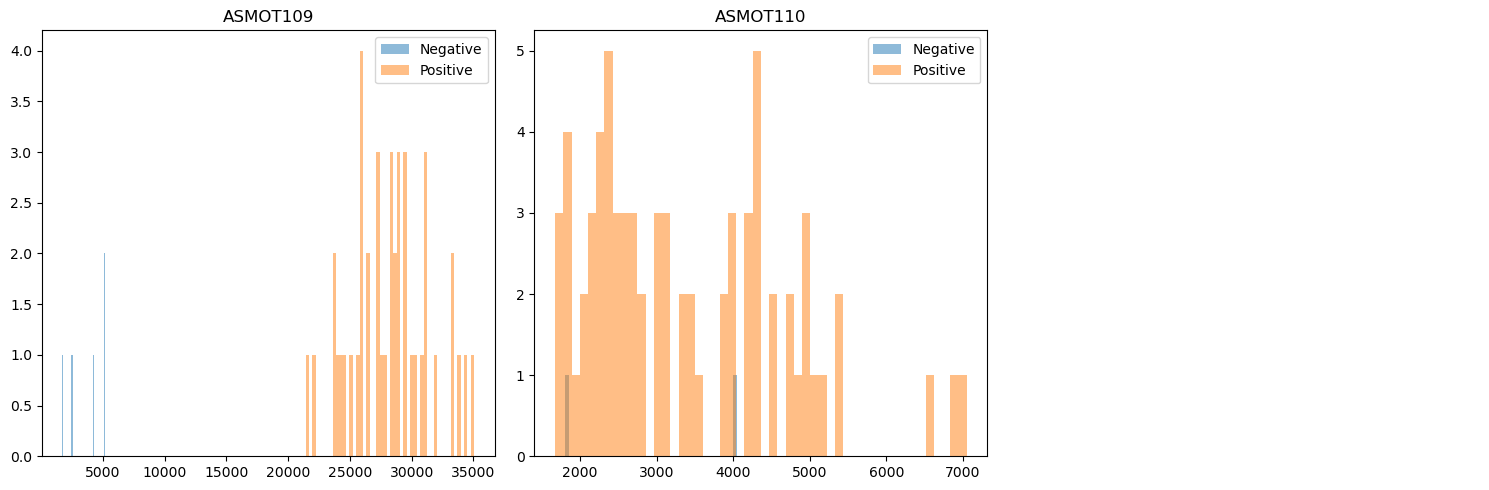

In [525]:
import matplotlib.pyplot as plt

# Supposons que mass_means_per_particle_neg et mass_means_per_particle_pos sont vos DataFrames
# Obtenir les expériences uniques pour les itérations
experiments = DATA['experiment'].unique()

# Déterminer le nombre de lignes et de colonnes pour les subplots
# Vous pouvez ajuster cela en fonction du nombre total d'expériences
n_cols = 3  # Par exemple, 3 colonnes
n_rows = (len(experiments) + n_cols - 1) // n_cols  # Arrondir vers le haut pour le nombre de lignes

# Créer un figure et axes pour les subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Ajustez la taille selon vos besoins

# Aplatir le tableau d'axes s'il y a plus d'une ligne
axs = axs.flatten()

# Tracer les histogrammes pour chaque expérience
for i, exp in enumerate(experiments):
    # Sélectionner le sous-graphique à utiliser
    ax = axs[i]
    
        # Tracer l'histogramme pour les données négatives de l'expérience
    ax.hist(mass_means_per_particle_neg[mass_means_per_particle_neg['experiment'] == exp].groupby('particle')['mass'].mean(), 
            alpha=0.5, bins=50, label='Negative')

    # Tracer l'histogramme pour les données positives de l'expérience
    ax.hist(mass_means_per_particle_pos[mass_means_per_particle_pos['experiment'] == exp].groupby('particle')['mass'].mean(), 
            alpha=0.5, bins=50, label='Positive')

    # Configurer le titre et les légendes pour le sous-graphique
    ax.set_title(exp)
    ax.legend()

# Masquer les axes non utilisés s'il y en a
for ax in axs[len(experiments):]:
    ax.axis('off')

# Ajuster la mise en page pour éviter le chevauchement
plt.tight_layout()

# Afficher le graphique multiplot
plt.show()

fig.savefig(path_save_pic + f"Mean mass per particules {CONDITION_simple}.png", format='png')

In [526]:
# Assurez-vous que sums_df est un DataFrame Pandas
sums_df = pd.DataFrame(columns=['experiment', 'particle', 'displacement_sum'])

rows = []

for exp in DATA['experiment'].unique():
    exp_data = DATA[DATA['experiment'] == exp]
    for particle_id, part in exp_data.groupby('particle'):
        displacement_sum = part['displacement [pix]'].head(200).sum()
        new_row = {'experiment': exp, 'particle': particle_id, 'displacement_sum': displacement_sum}
        rows.append(new_row)

# Création d'un nouveau DataFrame à partir de la liste de dictionnaires
sums_df = pd.DataFrame(rows)


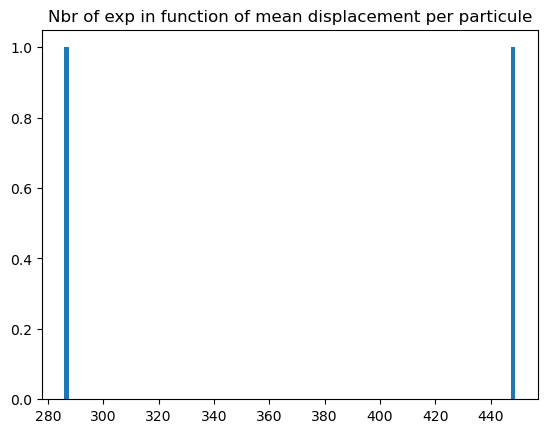

In [527]:
mean_sum = []
for _, exp in sums_df.groupby('experiment'):
    mean_sum.append(exp['displacement_sum'].mean())

plt.hist(mean_sum, bins = 100)
plt.title("Nbr of exp in function of mean displacement per particule")
plt.savefig(path_save_pic + f"Nbr of exp in function of mean displacement per particule {CONDITION_simple}.png", format='png') 
plt.show()

In [528]:
# Y'a t'il l'air d'enregistrer? 
# size en fonction ? 
# faire des manip en x10
# calculer un pseudo packing fraction : nombre de cellule par unité d'air. Ensuite, on essaye de voir la size des cells. 
# Cela dit, c'est vraiment le nombre de cellules par unité d'aire qui m'interesse

In [529]:
for exp in DATA['experiment'].unique():
    # Calculer ymax et xmax pour chaque expérience
    ymax = math.ceil(DATA[DATA['experiment'] == exp]['y'].max() / 2048)
    xmax = math.ceil(DATA[DATA['experiment'] == exp]['x'].max() / 2048)

    # Convertir en int si nécessaire (math.ceil retourne déjà un int)
    ymax = int(ymax)
    xmax = int(xmax)
    # Filtrer le DataFrame pour l'expérience 'ASMOT050' et les 200 premières frames
    exp_data = DATA[(DATA['experiment'] == exp) & (DATA['frame'] < 200)]

    # Grouper par 'frame' et compter les particules
    particules_par_frame = exp_data.groupby('frame')['particle'].nunique()

    # Calculer la moyenne du nombre de particules
    moyenne_particules = particules_par_frame.mean()
    nombre_part_par_champs = moyenne_particules/(xmax*ymax)

    print(f"Nombre de cellules par champs pour la manips {exp}:", int(nombre_part_par_champs))


Nombre de cellules par champs pour la manips ASMOT109: 2
Nombre de cellules par champs pour la manips ASMOT110: 3


In [530]:
import pandas as pd
import math


# Liste pour stocker les données de chaque expérience
data = []

for exp in DATA['experiment'].unique():
    # Calculer ymax et xmax
    ymax = math.ceil(DATA[DATA['experiment'] == exp]['y'].max() / 2048)
    xmax = math.ceil(DATA[DATA['experiment'] == exp]['x'].max() / 2048)
    ymax, xmax = int(ymax), int(xmax)

    # Filtrer pour l'expérience et les 200 premières frames
    exp_data = DATA[(DATA['experiment'] == exp) & (DATA['frame'] < 200)]

    # Compter les particules par frame et calculer la moyenne
    moyenne_particules = exp_data.groupby('frame')['particle'].nunique().mean()
    nombre_part_par_champs = int(moyenne_particules / (xmax * ymax))

    # Calculer mean_sum pour l'expérience
    mean_sum = int(sums_df[sums_df['experiment'] == exp]['displacement_sum'].mean())

    #Calcul de la vitesse moyenne des particules
    mean_speed = exp_data.groupby('particle')['VitInst [um/min]'].mean().mean()

    # Calcul de la proportion des rapides et lentes par manip
    N_pos = df_autocor_positive[df_autocor_positive['experiment']==exp]['particle'].nunique()
    N_neg = df_autocor_negative[df_autocor_negative['experiment']==exp]['particle'].nunique()
    pro_neg = N_neg/(N_neg + N_pos)
    pro_pos = N_pos/((N_neg + N_pos))

    # Ajouter les données calculées à la liste
    data.append({
        'experiment': exp,
        'mean_sum': mean_sum,
        'taille': xmax * ymax,
        'nombre_part_par_champs': nombre_part_par_champs,
        'mean_speed [um/min]': mean_speed,
        'proportion_neg': pro_neg
    })

# Création du DataFrame
result_df = pd.DataFrame(data)

# # Affichage du DataFrame
# print(result_df)

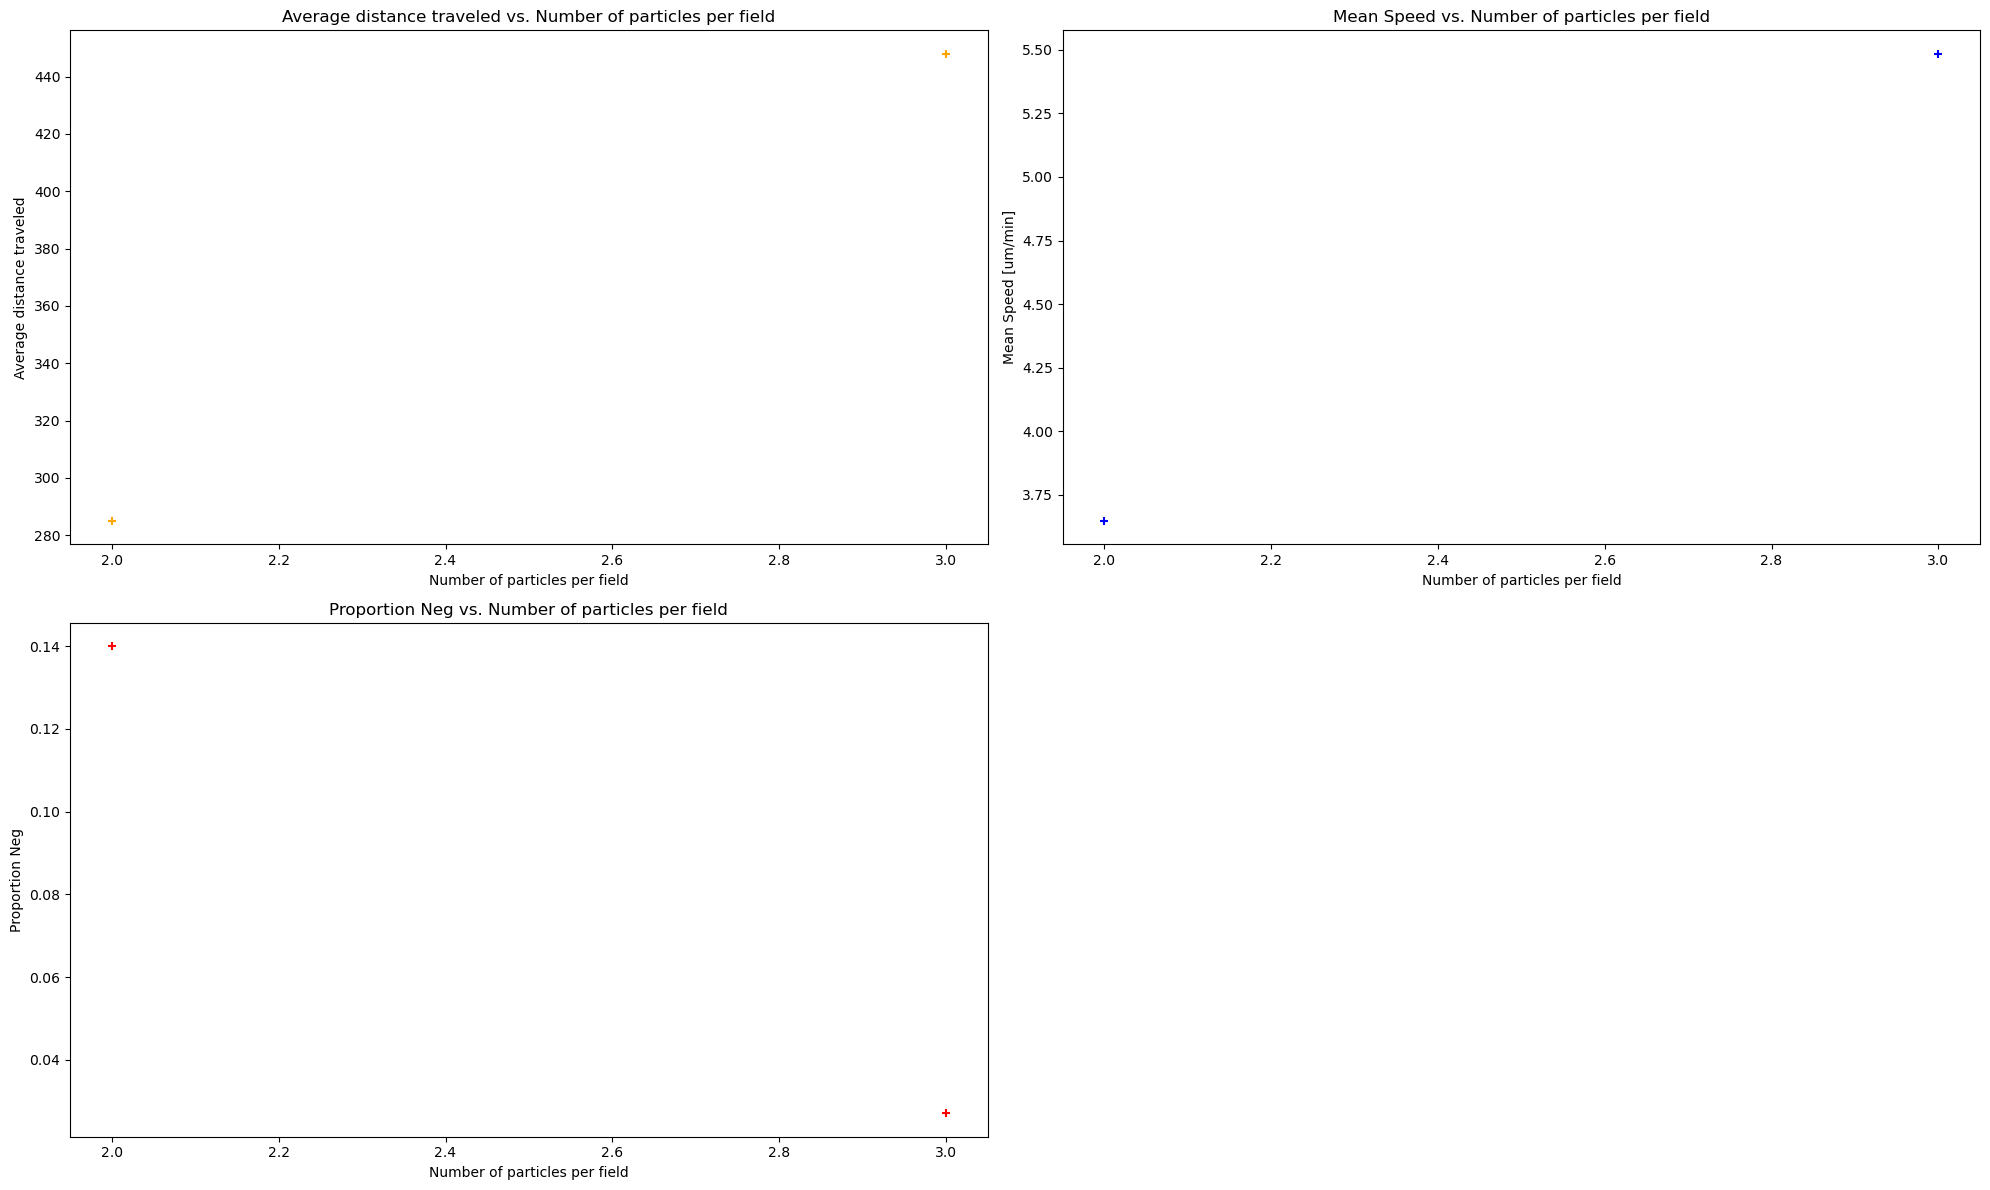

In [531]:
import matplotlib.pyplot as plt

# Supposons que result_df est votre DataFrame contenant les données nécessaires

# Création d'une grille de sous-graphiques 2x2
fig, axes = plt.subplots(2, 2, figsize=(20, 12))  # Ajustez la taille selon vos besoins

# Aplatir le tableau d'axes pour un accès plus facile
ax1, ax2, ax3, ax4 = axes.flatten()

# Premier graphique: Mean Sum vs. Nombre de Particules par Champ
ax1.scatter(result_df['nombre_part_par_champs'], result_df['mean_sum'], marker='+', color='orange')
ax1.set_title('Average distance traveled vs. Number of particles per field')
ax1.set_xlabel('Number of particles per field')
ax1.set_ylabel('Average distance traveled')

# Deuxième graphique: Mean Speed vs. Nombre de Particules par Champ
ax2.scatter(result_df['nombre_part_par_champs'], result_df['mean_speed [um/min]'], marker='+', color='blue')
ax2.set_title('Mean Speed vs. Number of particles per field')
ax2.set_xlabel('Number of particles per field')
ax2.set_ylabel('Mean Speed [um/min]')

# Troisième graphique: Proportion Neg vs. Nombre de Particules par Champ
ax3.scatter(result_df['nombre_part_par_champs'], result_df['proportion_neg'], marker='+', color='red')
ax3.set_title('Proportion Neg vs. Number of particles per field')
ax3.set_xlabel('Number of particles per field')
ax3.set_ylabel('Proportion Neg')

# Masquer le quatrième axe car il n'est pas utilisé
ax4.axis('off')

# Ajustement de la mise en page pour éviter le chevauchement des titres
plt.tight_layout()

# Afficher les graphiques
plt.show()

fig.savefig(path_save_pic + f"graph in function of nbr of particles per field {CONDITION_simple}.png", format='png') 

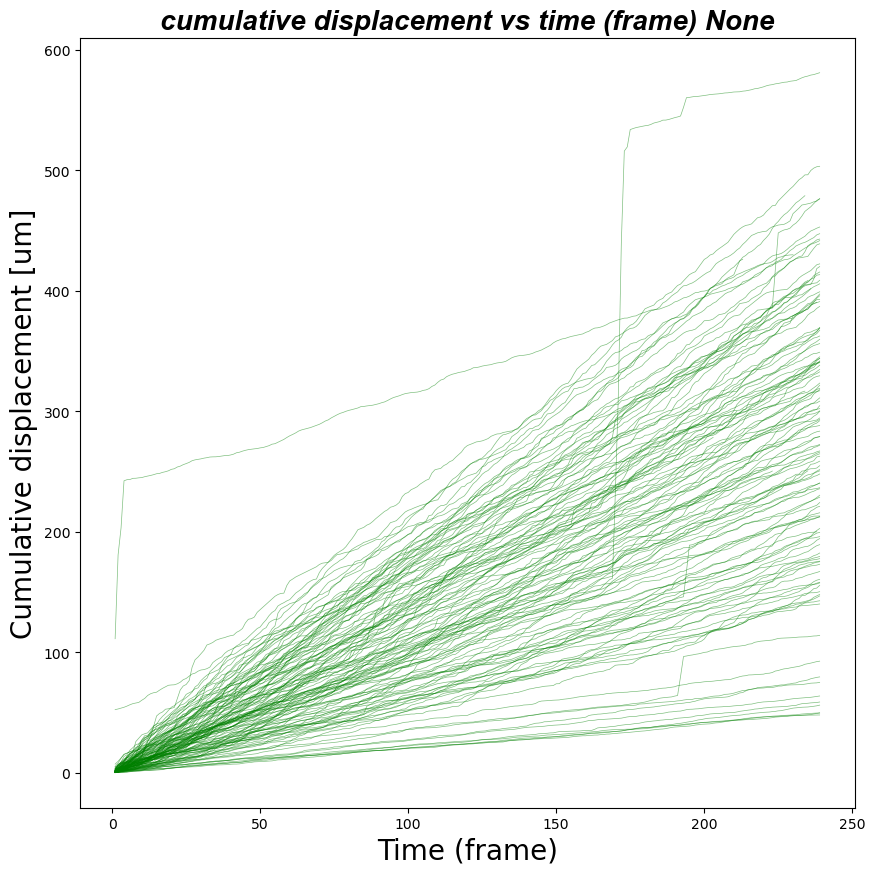

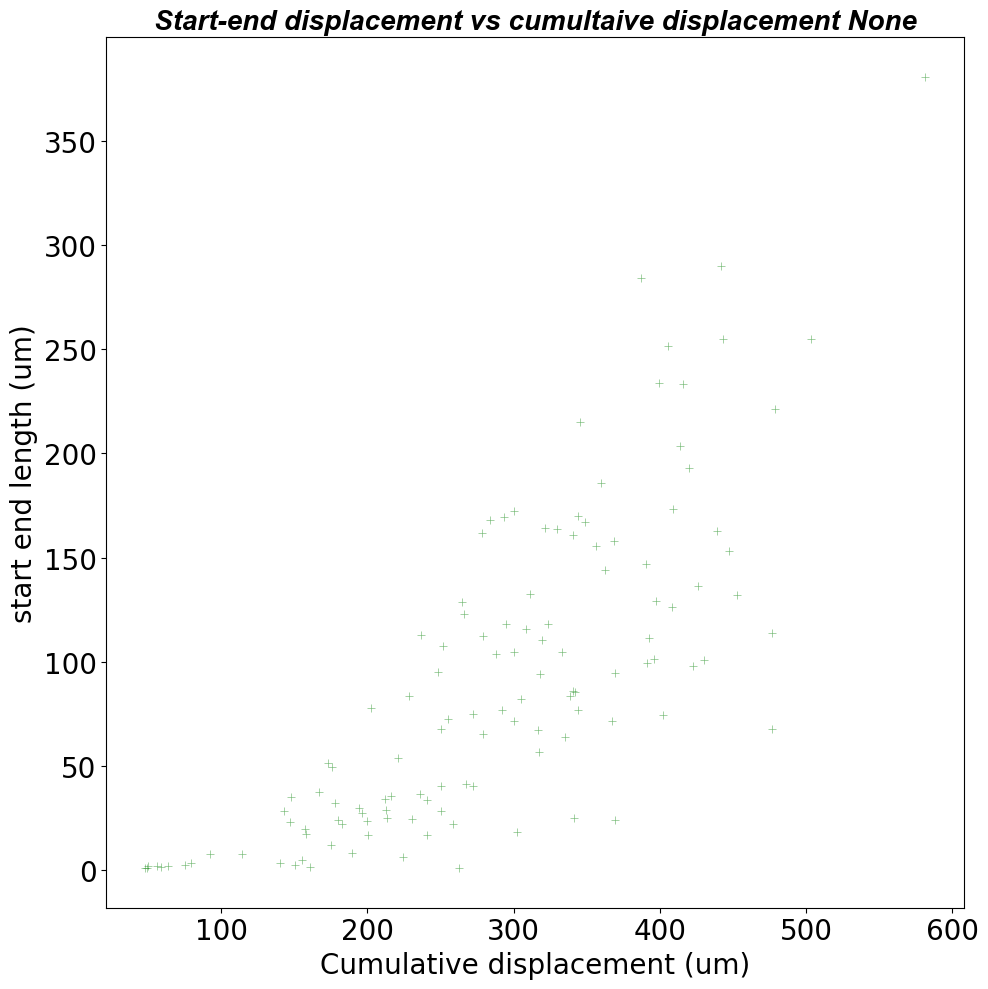

In [532]:
importlib.reload(lib)
lib.plot_displacement(DATA, start_end=start_end, alpha = 0.5, linewidth=0.5)

(array([12.,  5.,  1.,  0.,  5.,  4.,  5.,  5.,  4.,  3.,  3.,  0.,  1.,
         2.,  1.,  0.,  2.,  3.,  3.,  3.,  2.,  3.,  2.,  0.,  3.,  2.,
         2.,  3.,  2.,  4.,  3.,  0.,  2.,  2.,  2.,  1.,  0.,  1.,  1.,
         0.,  2.,  1.,  4.,  3.,  2.,  2.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,
         0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  0.98455026,   4.78039925,   8.57624825,  12.37209725,
         16.16794624,  19.96379524,  23.75964423,  27.55549323,
         31.35134223,  35.14719122,  38.94304022,  42.73888921,
         46.53473821,  50.33058721,  54.1264362 ,  57.9222852 ,
         61.71813419,  65.51398319,  69.30983218,  73.10568118,
         76.90153018,  80.69737917,  84.49322817,  88.28907716,
         92.08492616,  95.88077516,  99.67662415, 

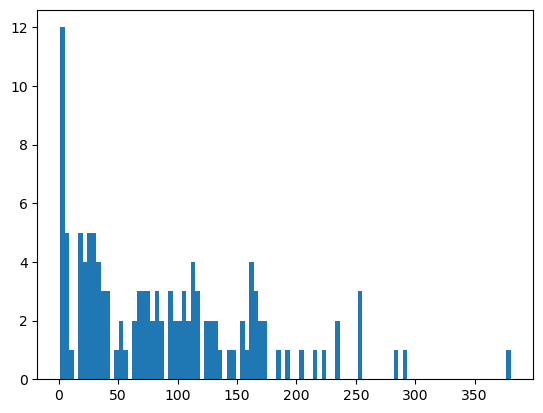

In [533]:
plt.hist(start_end, bins=100)

In [534]:
start_end

start-end [um]
particle                
0              22.319314
1              49.577984
2              28.369704
3             167.797033
4              72.564864
...                  ...
148           173.502326
152            74.436534
153           126.077232
154           221.402991
158           136.228044

[124 rows x 1 columns]

In [535]:
DATA

level_0             y            x          mass       size       ecc  \
0            0   6580.025732  7507.575269  21825.224193  13.842319  0.041376   
1            1   6580.446854  7507.805738  22523.593684  13.854250  0.031838   
2            2   6580.556886  7507.848563  23885.066253  13.806886  0.011206   
3            3   6581.437222  7507.309944  22873.487897  13.775155  0.019708   
4            4   6582.427065  7506.324405  22426.650413  13.876729  0.029371   
...        ...           ...          ...           ...        ...       ...   
28870    28870  10034.244315  5681.066202   4009.367123  10.915893  0.147821   
28871    28871  10031.965352  5681.149060   2612.423625   9.697050  0.219889   
28872    28872  10025.775524  5673.853776    355.612398   6.940051  0.605932   
28873    28873  10026.596464  5665.110684    257.021531   4.837085  0.153026   
28874    28874  10027.460461  5663.615089    506.389069   5.414607  0.020510   

          signal  raw_mass        ep  frame  ...  total_path_first_n  \
0      27.732178  111202.0  0.027792      0  ...          107.985305   
1      28.518467  117003.0  0.015264      1  ...          107.985305   
2      30.297466  124836.0  0.007496      2  ...          107.985305   
3      29.264464  118446.0  0.000923      3  ...          107.985305   
4      28.051680  115990.0  0.001506      4  ...          107.985305   
...          ...       ...       ...    ...  ...                 ...   
28870   6.694749  282793.0  1.362413    235  ...          308.067063   
28871   6.180314  277147.0  1.520230    236  ...          308.067063   
28872   5.409480  268777.0  1.840806    237  ...          308.067063   
28873   5.432815  258568.0  2.454767    238  ...          308.067063   
28874   5.675594  258237.0  2.482831    239  ...          308.067063   

       dx [pix]  dy [pix] displacement [pix] VitInst [um/min]    Xc [pix]  \
0           NaN       NaN                NaN              NaN    0.000000   
1      0.230469  0.421121           0.480061         1.223196    0.230469   
2      0.042825  0.110033           0.118073         0.300849    0.273294   
3     -0.538620  0.880335           1.032038         2.629632   -0.265326   
4     -0.985539  0.989844           1.396810         3.559072   -1.250865   
...         ...       ...                ...              ...         ...   
28870 -1.859377 -0.060865           1.860373         4.740230  144.074544   
28871  0.082858 -2.278963           2.280469         5.810635  144.157403   
28872 -7.295285 -6.189828           9.567400        24.377736  136.862118   
28873 -8.743091  0.820940           8.781548        22.375385  128.119027   
28874 -1.495595  0.863997           1.727221         4.400960  126.623432   

         Yc [pix]  cumulative displacement [um]        dx        dy  
0        0.000000                           NaN       NaN       NaN  
1        0.421121                      0.305799  0.230469  0.421121  
2        0.531154                      0.381011  0.042825  0.110033  
3        1.411489                      1.038419 -0.538620  0.880335  
4        2.401333                      1.928187 -0.985539  0.989844  
...           ...                           ...       ...       ...  
28870 -165.559075                    411.884634 -1.859377 -0.060865  
28871 -167.838038                    413.337293  0.082858 -2.278963  
28872 -174.027866                    419.431727 -7.295285 -6.189828  
28873 -173.206926                    425.025573 -8.743091  0.820940  
28874 -172.342929                    426.125813 -1.495595  0.863997  

[28875 rows x 26 columns]